In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import (split_train_test, 
                                                        logistic_regression_multiclass, 
                                                        f1_score_over_time_multiclass,
                                                        plot_f1_score_over_time,
                                                        create_f1_score_dataframe,
                                                        compute_average_f1_score,
                                                        plot_average_f1_score_difference,
                                                        compute_metrics_for_dataframes,
                                                        compute_differences,
                                                        compute_graph_metrics,
                                                        compute_histogram,
                                                        compute_kl_divergence,
                                                        plot_differences_together,
                                                        random_subsample,
                                                        compute_jaccard_similarities,
                                                        plot_jaccard_results,
                                                        produce_performance_metrics,)

import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

from scipy.interpolate import CubicSpline
from sklearn.metrics.pairwise import cosine_similarity
from scipy.interpolate import CubicSpline, interp1d
from sklearn.decomposition import PCA




pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
#these arefunctions that will search for the embryo_stats_csv file and then attempt to create it
def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.
    Parameters:
        model_path (str): The base path to start searching.
    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path


def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample=True,
    wt_downsample_frac=0.05,
    non_wt_downsample_frac=0.05,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample data if enabled
    if downsample:
        # Identify unique perturbation groups
        groups = df['phenotype'].unique()
        downsampled_dfs = []

        for group in groups:
            group_df = df[df['phenotype'] == group]
            unique_embryos = group_df['embryo_id'].unique()
            
            # Set downsampling fraction
            if group == 'wt':
                downsample_frac = wt_downsample_frac
            else:
                downsample_frac = non_wt_downsample_frac
            
            # Calculate the number of embryos to sample
            n_sample = max(1, int(len(unique_embryos) * downsample_frac))
            
            # Randomly sample embryo_ids
            sampled_embryos = np.random.RandomState(random_state).choice(
                unique_embryos, size=n_sample, replace=False
            )
            
            # Filter the group dataframe
            group_df_sampled = group_df[group_df['embryo_id'].isin(sampled_embryos)]
            downsampled_dfs.append(group_df_sampled)

        # Combine downsampled data
        df = pd.concat(downsampled_dfs, ignore_index=True)
        
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            # color='phenotype',
            size='marker_size',
            opacity=opacity,
            title=title,
            color_discrete_map=color_discrete_map
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the figure object for further use

    
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

plt.style.use('default')

def plot_pca_2d_highlighted_embryos_matplotlib(test_df, z_mu_biological_columns, downsample_wt=False, wt_downsample_frac=0.1, marker_size=3, pert_comparisons=pert_comparisons,title=None):
    """
    Plots a 2D PCA projection of the data with wild-type embryos optionally downsampled.
    
    Parameters:
        test_df (pd.DataFrame): Test dataset.
        z_mu_biological_columns (list): Columns representing latent variables.
        downsample_wt (bool): Whether to downsample wild-type data.
        wt_downsample_frac (float): Fraction of wild-type data to keep if downsampling.
        marker_size (int): Size of the scatterplot markers.
        pert_comparisons (list): List of phenotypes to include in the plot.
    """
    # Perform PCA
    pca = PCA(n_components=2)
    if pert_comparisons:
        test_df = test_df[test_df["phenotype"].isin(pert_comparisons)]
    pca_result = pca.fit_transform(test_df[z_mu_biological_columns])

    # Add PCA columns to the dataframe
    test_df['PCA1'] = pca_result[:, 0]
    test_df['PCA2'] = pca_result[:, 1]

    # Optional: Downsample wild-type embryos
    if downsample_wt:
        wt_mask = test_df['phenotype'] == 'wt'
        non_wt_df = test_df[~wt_mask]
        wt_df = test_df[wt_mask].sample(frac=wt_downsample_frac, random_state=42)
        test_df = pd.concat([wt_df, non_wt_df])

    # Get unique phenotypes and assign seaborn colors
    unique_phenotypes = test_df['phenotype'].unique()
    palette = sns.color_palette("deep", len(unique_phenotypes))
    color_map = dict(zip(unique_phenotypes, palette))
    test_df['color'] = test_df['phenotype'].map(color_map)

    # Plot the data
    plt.figure(figsize=(10, 8))
    for phenotype, group_df in test_df.groupby('phenotype'):
        plt.scatter(
            group_df['PCA1'], 
            group_df['PCA2'], 
            c=[color_map[phenotype]], 
            label=phenotype, 
            s=marker_size, 
            alpha=0.7
        )

    # Add a legend
    plt.legend(title="Phenotypes")
    if title:
        plt.title(title)
    else:
        plt.title('PCA 2D Projection with Highlighted Embryos')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

In [ ]:
class LocalPrincipalCurve:
    def __init__(self, bandwidth=0.5, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None):
        """
        Initialize the Local Principal Curve solver.

        Parameters:
        - bandwidth: The kernel bandwidth (h). If h is not provided, bandwidth is used as h.
        - max_iter: Maximum number of iterations for forward/backward runs.
        - tol: Tolerance for stopping criterion based on changes in µ_x.
        - angle_penalty_exp: Exponent k used in angle penalization: a_x(i) = |cos(alpha_x(i))|^k.
        - h: Step size t0. If None, set t0 = bandwidth.
        """

        self.bandwidth = bandwidth
        self.h = h if h is not None else self.bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.angle_penalty_exp = angle_penalty_exp

        self.initializations = []
        self.paths = []
        self.cubic_splines_eq = []
        self.cubic_splines = []

    def _kernel_weights(self, dataset, x):
        """Compute Gaussian kernel weights w_i = K_h(X_i - x)."""
        dists = np.linalg.norm(dataset - x, axis=1)
        weights = np.exp(- (dists**2) / (2 * self.bandwidth**2))
        w = weights / np.sum(weights)
        return w

    def _local_center_of_mass(self, dataset, x):
        """Compute µ_x, the local center of mass around x."""
        w = self._kernel_weights(dataset, x)
        mu = np.sum(dataset.T * w, axis=1)
        return mu

    def _local_covariance(self, dataset, x, mu):
        """Compute the local covariance matrix Σ_x."""
        w = self._kernel_weights(dataset, x)
        centered = dataset - mu
        cov = np.zeros((dataset.shape[1], dataset.shape[1]))
        for i in range(len(dataset)):
            cov += w[i] * np.outer(centered[i], centered[i])
        return cov

    def _principal_component(self, cov, prev_vec=None):
        """Compute the first local principal component γ_x, with angle penalization."""
        vals, vecs = np.linalg.eig(cov)
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]

        gamma = vecs[:, 0]  # first principal component

        # Sign flipping to maintain direction if prev_vec is given
        if prev_vec is not None and np.linalg.norm(prev_vec) != 0:
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            if cos_alpha < 0:
                gamma = -gamma

            # Angle penalization
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            a_x = (abs(cos_alpha))**self.angle_penalty_exp
            gamma = a_x * gamma + (1 - a_x) * prev_vec
            gamma /= np.linalg.norm(gamma)

        return gamma

    def _forward_run(self, dataset, x_start):
        """Run the algorithm forward from a starting point using the full dataset."""
        x = x_start
        path_x = [x]
        prev_gamma = None

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            # Check convergence
            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _backward_run(self, dataset, x0, gamma0):
        """Run the algorithm backwards from x(0) along -γ_x(0) using the full dataset."""
        x = x0
        path_x = [x]
        prev_gamma = -gamma0

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _find_starting_point(self, dataset, start_point):
        """Ensure starting point is in dataset or choose closest."""
        if start_point is None:
            idx = np.random.choice(len(dataset))
            return dataset[idx], idx
        else:
            diffs = dataset - start_point
            dists = np.linalg.norm(diffs, axis=1)
            min_idx = np.argmin(dists)
            closest_pt = dataset[min_idx]
            if not np.allclose(closest_pt, start_point):
                print(f"Starting point not in dataset. Using closest point: {closest_pt}")
            return closest_pt, min_idx

    def fit(self, dataset, start_points=None, remove_similar_end_start_points=True):
        """
        Fit LPC on the dataset using possibly multiple starting points.

        Parameters:
        - dataset: n x p array
        - start_points: List of starting points or None.

        Returns:
        - self.paths: List of arrays, each array is a path from one initialization.
        """
        dataset = np.array(dataset)
        self.paths = []
        self.initializations = []

        if start_points is None:
            start_points = [None]

        for sp in start_points:
            x0, _ = self._find_starting_point(dataset, sp)

            forward_path = self._forward_run(dataset, x0)
            if len(forward_path) > 1:
                initial_gamma_direction = (forward_path[1] - forward_path[0]) / self.h
            else:
                initial_gamma_direction = np.zeros(dataset.shape[1])

            if np.linalg.norm(initial_gamma_direction) > 0:
                backward_path = self._backward_run(dataset, x0, initial_gamma_direction)
                full_path = np.vstack([backward_path[::-1], forward_path[1:]])
            else:
                full_path = forward_path

            # Check orientation: which end of the path is closer to the starting point x0?
            dist_start_to_first = np.linalg.norm(x0 - full_path[0])
            dist_start_to_last = np.linalg.norm(x0 - full_path[-1])

            if dist_start_to_last < dist_start_to_first:
                # Reverse the path if the last point is closer to the starting point
                full_path = full_path[::-1]

            # Remove points too close to the start or end point, except for the endpoints themselves
            if remove_similar_end_start_points:
                # Remove points too close to the start or end point, except for the endpoints themselves
                start_pt = full_path[0]
                end_pt = full_path[-1]

                dist_to_start = np.linalg.norm(full_path - start_pt, axis=1)
                dist_to_end = np.linalg.norm(full_path - end_pt, axis=1)

                # Create a mask to keep points that are not too close
                mask = np.ones(len(full_path), dtype=bool)
                # Mark points for removal if they are too close to start or end
                # but we will keep the endpoints themselves
                mask[(dist_to_start < self.tol) | (dist_to_end < self.tol)] = False
                mask[0] = True  # Keep the first point
                mask[-1] = True # Keep the last point

                # Apply the mask to remove these unecasary poinrs
                full_path = full_path[mask]

            
            self.paths.append(full_path)
            self.initializations.append(x0)

        self._fit_cubic_splines_eq()
        self._compute_cubic_spline_points()
        return self.paths
    def _fit_cubic_splines_eq(self):
        """Fit cubic splines (equations) for all paths."""
        self.cubic_splines_eq = []
        for path in self.paths:
            if len(path) < 4:
                self.cubic_splines_eq.append(None)
                continue
            t = np.arange(len(path))
            splines_dict = {}
            for dim in range(path.shape[1]):
                splines_dict[dim] = CubicSpline(t, path[:, dim])
            self.cubic_splines_eq.append(splines_dict)

    def _compute_cubic_spline_points(self, num_points=500):
        """
        Compute parameterized points from each cubic spline equation.
        This fills self.cubic_splines with arrays of evaluated points.
        """
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            path = self.paths[i]
            t_values = np.linspace(0, len(path) - 1, num_points)
            spline_points = self.evaluate_cubic_spline(i, t_values)
            self.cubic_splines.append(spline_points)

    def evaluate_cubic_spline(self, path_idx, t_values):
        """Evaluate the cubic spline equation for a specific path at given parameter values."""
        if path_idx >= len(self.cubic_splines_eq) or self.cubic_splines_eq[path_idx] is None:
            raise ValueError(f"No cubic spline found for path index {path_idx}.")
        spline = self.cubic_splines_eq[path_idx]
        points = np.array([spline[dim](t_values) for dim in range(len(spline))]).T
        return points

    def plot_path_3d(self, dataset, path_idx=0):
        """Plot dataset and one LPC path in 3D for visualization."""
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        dataset = np.array(dataset)
        path = self.paths[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
        ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
        ax.legend()
        plt.show()

    def plot_cubic_spline_3d(self, path_idx, t_values=None, show_path=True):
        """
        Plot the cubic spline for a specific path in 3D.

        Parameters:
        - path_idx: Index of the path to plot the spline for.
        - t_values: Optional parameter values to plot the spline at.
                    If None, t_values will be automatically generated.
        - show_path: Boolean flag to indicate whether to plot the LPC path points.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        if path_idx >= len(self.paths):
            raise IndexError(f"Path index {path_idx} is out of range. Total paths: {len(self.paths)}.")

        path = self.paths[path_idx]
        if t_values is None:
            t_values = np.linspace(0, len(path) - 1, 500)

        spline_points = self.evaluate_cubic_spline(path_idx, t_values)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if show_path:
            ax.scatter(path[:, 0], path[:, 1], path[:, 2], label="LPC Path", alpha=0.5)

        ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2], color="red", label="Cubic Spline")
        ax.legend()
        plt.show()
        
def extract_spline(splines_df, dataset_label, perturbation):
    sdf = splines_df[(splines_df["dataset"] == dataset_label) & (splines_df["Perturbation"] == perturbation)]
    sdf = sdf.sort_values("point_index")
    points = sdf[["PCA_1", "PCA_2", "PCA_3"]].values
    return points



def kabsch_alignment(P, Q):
    # Kabsch alignment to find rotation & translation minimizing RMSD between P and Q
    # P and Q are Nx3 sets of points
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    H = P_centered.T @ Q_centered
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    # Correct any reflection
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_P - R @ centroid_Q
    return R, t



# def kabsch_alignment(P, Q, weighted_beg_end=1):
#     """
#     Perform Kabsch alignment to find the rotation and translation that minimize the RMSD between P and Q.
#     Optionally applies a weighting scheme to emphasize alignment at the beginning and end points.

#     Parameters
#     ----------
#     P : ndarray of shape (N, 3)
#         Set of N points in 3D space.
#     Q : ndarray of shape (N, 3)
#         Set of N corresponding points in 3D space.
#     weighted_beg_end : None or float
#         If None, no weighting is applied.
#         If a float, e.g. 1.0, then a Gaussian-based weighting is applied to emphasize alignment at the start and end.
#         Larger values increase the emphasis on the ends.

#     Returns
#     -------
#     R : ndarray of shape (3, 3)
#         The rotation matrix.
#     t : ndarray of shape (3,)
#         The translation vector.
#     """

#     # Basic checks
#     if P.shape != Q.shape:
#         raise ValueError("P and Q must have the same shape.")
#     if P.shape[1] != 3:
#         raise ValueError("Points must be 3D.")

#     N = P.shape[0]

#     # Compute weights if needed
#     if weighted_beg_end is not None:
#         # Example weighting scheme:
#         # Use a Gaussian that peaks at the start (i=0) and end (i=N-1).
#         # w_i = 1 + weighted_beg_end * (exp(-i^2/(2σ²)) + exp(-(N-1 - i)^2/(2σ²)))
#         sigma = max(N/10.0, 1.0)  # You can adjust sigma as needed
#         indices = np.arange(N)
#         dist_start = np.exp(-(indices**2) / (2*sigma**2))
#         dist_end = np.exp(-((N - 1 - indices)**2) / (2*sigma**2))
#         weights = 1.0 + weighted_beg_end * (dist_start + dist_end)
#     else:
#         # Uniform weights
#         weights = np.ones(N)

#     # Normalize weights so total sum is N (not strictly necessary, but often nice)
#     weights = weights / np.mean(weights)

#     # Compute weighted centroids
#     W_sum = np.sum(weights)
#     centroid_P = np.sum(P * weights[:, None], axis=0) / W_sum
#     centroid_Q = np.sum(Q * weights[:, None], axis=0) / W_sum

#     # Center the points
#     P_centered = P - centroid_P
#     Q_centered = Q - centroid_Q

#     # Compute the weighted cross-covariance matrix
#     # H = sum_i w_i * (P_i - centroid_P)(Q_i - centroid_Q)^T
#     H = (P_centered.T * weights) @ Q_centered

#     # SVD
#     U, S, Vt = np.linalg.svd(H)
#     R = Vt.T @ U.T

#     # Correct reflection if necessary
#     if np.linalg.det(R) < 0:
#         Vt[-1, :] *= -1
#         R = Vt.T @ U.T

#     # Translation
#     t = centroid_P - R @ centroid_Q

#     return R, t




In [ ]:


class LocalPrincipalCurve:
    def __init__(self, bandwidth=0.5, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None):
        """
        Initialize the Local Principal Curve solver.
        """
        self.bandwidth = bandwidth
        self.h = h if h is not None else self.bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.angle_penalty_exp = angle_penalty_exp

        self.initializations = []
        self.paths = []
        self.cubic_splines_eq = []
        self.cubic_splines = []

    def _kernel_weights(self, dataset, x):
        """Compute Gaussian kernel weights w_i = K_h(X_i - x)."""
        dists = np.linalg.norm(dataset - x, axis=1)
        weights = np.exp(- (dists**2) / (2 * self.bandwidth**2))
        w = weights / np.sum(weights)
        return w

    def _local_center_of_mass(self, dataset, x):
        """Compute µ_x, the local center of mass around x."""
        w = self._kernel_weights(dataset, x)
        mu = np.sum(dataset.T * w, axis=1)
        return mu

    def _local_covariance(self, dataset, x, mu):
        """Compute the local covariance matrix Σ_x."""
        w = self._kernel_weights(dataset, x)
        centered = dataset - mu
        cov = np.zeros((dataset.shape[1], dataset.shape[1]))
        for i in range(len(dataset)):
            cov += w[i] * np.outer(centered[i], centered[i])
        return cov

    def _principal_component(self, cov, prev_vec=None):
        """Compute the first local principal component γ_x, with angle penalization."""
        vals, vecs = np.linalg.eig(cov)
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]

        gamma = vecs[:, 0]  # first principal component

        # Sign flipping to maintain direction if prev_vec is given
        if prev_vec is not None and np.linalg.norm(prev_vec) != 0:
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            if cos_alpha < 0:
                gamma = -gamma

            # Angle penalization
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            a_x = (abs(cos_alpha))**self.angle_penalty_exp
            gamma = a_x * gamma + (1 - a_x) * prev_vec
            gamma /= np.linalg.norm(gamma)

        return gamma

    def _forward_run(self, dataset, x_start):
        """Run the algorithm forward from a starting point using the full dataset."""
        x = x_start
        path_x = [x]
        prev_gamma = None

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            # Check convergence
            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _backward_run(self, dataset, x0, gamma0):
        """Run the algorithm backwards from x(0) along -γ_x(0)."""
        x = x0
        path_x = [x]
        prev_gamma = -gamma0

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _find_starting_point(self, dataset, start_point):
        """Ensure starting point is in dataset or choose closest."""
        if start_point is None:
            idx = np.random.choice(len(dataset))
            return dataset[idx], idx
        else:
            diffs = dataset - start_point
            dists = np.linalg.norm(diffs, axis=1)
            min_idx = np.argmin(dists)
            closest_pt = dataset[min_idx]
            if not np.allclose(closest_pt, start_point):
                print(f"Starting point not in dataset. Using closest point: {closest_pt}")
            return closest_pt, min_idx

    def fit(self, dataset, start_points=None, remove_similar_end_start_points=True):
        """
        Fit LPC on the dataset using possibly multiple starting points.
        """
        dataset = np.array(dataset)
        self.paths = []
        self.initializations = []

        if start_points is None:
            start_points = [None]

        for sp in start_points:
            x0, _ = self._find_starting_point(dataset, sp)

            forward_path = self._forward_run(dataset, x0)
            if len(forward_path) > 1:
                initial_gamma_direction = (forward_path[1] - forward_path[0]) / self.h
            else:
                initial_gamma_direction = np.zeros(dataset.shape[1])

            if np.linalg.norm(initial_gamma_direction) > 0:
                backward_path = self._backward_run(dataset, x0, initial_gamma_direction)
                full_path = np.vstack([backward_path[::-1], forward_path[1:]])
            else:
                full_path = forward_path

            # Check orientation: which end of the path is closer to the starting point x0?
            dist_start_to_first = np.linalg.norm(x0 - full_path[0])
            dist_start_to_last = np.linalg.norm(x0 - full_path[-1])

            if dist_start_to_last < dist_start_to_first:
                # Reverse the path if the last point is closer to the starting point
                full_path = full_path[::-1]

            if remove_similar_end_start_points:
                start_pt = full_path[0]
                end_pt = full_path[-1]

                dist_to_start = np.linalg.norm(full_path - start_pt, axis=1)
                dist_to_end = np.linalg.norm(full_path - end_pt, axis=1)

                mask = np.ones(len(full_path), dtype=bool)
                mask[(dist_to_start < self.tol) | (dist_to_end < self.tol)] = False
                mask[0] = True  # Keep the first point
                mask[-1] = True # Keep the last point

                full_path = full_path[mask]

            self.paths.append(full_path)
            self.initializations.append(x0)

        self._fit_cubic_splines_eq()
        self._compute_equal_arc_length_spline_points()  # Compute equal arc-length points
        return self.paths

    def _fit_cubic_splines_eq(self):
        """Fit cubic splines (equations) for all paths."""
        self.cubic_splines_eq = []
        for path in self.paths:
            if len(path) < 4:
                self.cubic_splines_eq.append(None)
                continue
            t = np.arange(len(path))
            splines_dict = {}
            for dim in range(path.shape[1]):
                splines_dict[dim] = CubicSpline(t, path[:, dim])
            self.cubic_splines_eq.append(splines_dict)

    def _compute_cubic_spline_points(self, num_points=500):
        """
        Compute parameterized points from each cubic spline equation.
        This fills self.cubic_splines with arrays of evaluated points.
        """
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            path = self.paths[i]
            t_values = np.linspace(0, len(path) - 1, num_points)
            spline_points = self.evaluate_cubic_spline(i, t_values)
            self.cubic_splines.append(spline_points)

    def evaluate_cubic_spline(self, path_idx, t_values):
        """Evaluate the cubic spline equation for a specific path at given parameter values."""
        if path_idx >= len(self.cubic_splines_eq) or self.cubic_splines_eq[path_idx] is None:
            raise ValueError(f"No cubic spline found for path index {path_idx}.")
        spline = self.cubic_splines_eq[path_idx]
        points = np.array([spline[dim](t_values) for dim in range(len(spline))]).T
        return points

    def compute_arc_length(self, spline, t_min, t_max, num_samples=10000):
        """
        Approximate the arc length of the spline by sampling it finely.
        spline: dict of {dim: CubicSpline} for the given path.
        t_min, t_max: the parameter range of the spline.
        num_samples: number of samples to approximate arc length.
        Returns:
            t_values: the parameter values used for sampling
            cumulative_length: cumulative arc length corresponding to t_values
        """
        t_values = np.linspace(t_min, t_max, num_samples)
        points = np.array([spline[dim](t_values) for dim in range(len(spline))]).T

        distances = np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1))
        cumulative_length = np.insert(np.cumsum(distances), 0, 0.0)
        return t_values, cumulative_length

    def get_uniformly_spaced_points(self, spline, num_points):
        """
        Given a fitted spline (as a dict {dim: CubicSpline}), 
        return points spaced equally by arc length.
        """
        # Parameter range: assuming t goes from 0 to (path_length - 1)
        path_length = len(spline[0].x)
        t_min = 0
        t_max = path_length - 1

        t_vals_dense, cum_length = self.compute_arc_length(spline, t_min, t_max, num_samples=5000)
        total_length = cum_length[-1]

        # Desired distances
        desired_distances = np.linspace(0, total_length, num_points)

        # Interpolate t-values for these distances
        t_for_dist = interp1d(cum_length, t_vals_dense, kind='linear')(desired_distances)

        # Evaluate spline at these t-values
        uniform_points = np.array([spline[dim](t_for_dist) for dim in range(len(spline))]).T

        return uniform_points

    def _compute_equal_arc_length_spline_points(self, num_points=500):
        """
        Compute points along each cubic spline that are equally spaced by arc length.
        """
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.equal_spaced_splines.append(None)
                continue
            spline_points = self.get_uniformly_spaced_points(eq, num_points)
            self.cubic_splines.append(spline_points)

    def plot_path_3d(self, path_idx=0,dataset=None):
        """Plot dataset and one LPC path in 3D for visualization."""
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        dataset = np.array(dataset)
        path = self.paths[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        if dataset: #plot dataset if one is give, usually what you fit onto
            ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
        ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
        ax.legend()
        plt.show()

    def plot_cubic_spline_3d(self, path_idx, show_path=True):
        """
        Plot the cubic spline for a specific path in 3D.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        if path_idx >= len(self.paths):
            raise IndexError(f"Path index {path_idx} is out of range. Total paths: {len(self.paths)}.")

        path = self.cubic_splines[path_idx]

        spline_points = self.cubic_splines[path_idx]

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if show_path:
            ax.scatter(path[:, 0], path[:, 1], path[:, 2], label="LPC Path", alpha=0.5)

        ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2], color="red", label="Cubic Spline")
        ax.legend()
        plt.show()

In [ ]:
import numpy as np

def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))

# def mean_l1_error(a, b):
# # a and b are Nx3 arrays of points.
# # Compute L1 distance for each point pair: sum of absolute differences across coordinates
# # Then take the mean over all points.
#     return np.mean(np.sum(np.abs(a - b), axis=1))

def centroid(X):
    return np.mean(X, axis=0)

def rmsd(X, Y):
    return np.sqrt(np.mean(np.sum((X - Y)**2, axis=1)))

def quaternion_alignment(P, Q):
    """
    Compute the optimal rotation using quaternions that aligns Q onto P.
    Returns rotation matrix R and translation vector t.
    """
    # Ensure P and Q have the same shape
    assert P.shape == Q.shape, "P and Q must have the same shape"
    
    # 1. Compute centroids and center the points
    P_cent = centroid(P)
    Q_cent = centroid(Q)
    P_prime = P - P_cent
    Q_prime = Q - Q_cent
    
    # 2. Construct correlation matrix M
    M = Q_prime.T @ P_prime
    
    # 3. Construct the Kearsley (Davenport) 4x4 matrix K
    # Refer to the equations above
    A = np.array([
        [ M[0,0]+M[1,1]+M[2,2],   M[1,2]-M[2,1],         M[2,0]-M[0,2],         M[0,1]-M[1,0]       ],
        [ M[1,2]-M[2,1],         M[0,0]-M[1,1]-M[2,2],  M[0,1]+M[1,0],         M[0,2]+M[2,0]       ],
        [ M[2,0]-M[0,2],         M[0,1]+M[1,0],         M[1,1]-M[0,0]-M[2,2],  M[1,2]+M[2,1]       ],
        [ M[0,1]-M[1,0],         M[0,2]+M[2,0],         M[1,2]+M[2,1],         M[2,2]-M[0,0]-M[1,1]]
    ], dtype=np.float64)
    A = A / 3.0
    
    # 4. Find the eigenvector of A with the highest eigenvalue
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    max_idx = np.argmax(eigenvalues)
    q = eigenvectors[:, max_idx]
    q = q / np.linalg.norm(q)
    
    # 5. Convert quaternion q into rotation matrix R
    # Quaternion format: q = [q0, q1, q2, q3]
    q0, q1, q2, q3 = q
    R = np.array([
        [q0**2 + q1**2 - q2**2 - q3**2, 2*(q1*q2 - q0*q3),         2*(q1*q3 + q0*q2)],
        [2*(q2*q1 + q0*q3),             q0**2 - q1**2 + q2**2 - q3**2, 2*(q2*q3 - q0*q1)],
        [2*(q3*q1 - q0*q2),             2*(q3*q2 + q0*q1),             q0**2 - q1**2 - q2**2 + q3**2]
    ])
    
    # 6. Compute translation
    t = P_cent - R @ Q_cent
    
    return R, t


In [144]:
splines_final_dict

combined_df = pd.concat(
    [df.assign(model_index=model_index) for model_index, df in splines_final_dict.items()],
    ignore_index=True
)

combined_df.Perturbation.unique()


array(['wnt-i', 'tgfb-i', 'wt', 'lmx1b', 'gdf3'], dtype=object)

In [3]:
merged_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241130/sweep_analysis/paired_models_and_metrics_df.csv")
merged_df_avg = merged_df[merged_df["Perturbation"]=="avg_pert"]

In [146]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
splines_final_dict = {}
for model_index in [71,77,78]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


    # Dictionary to store spline points for each dataset and perturbation
    # Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
    splines_dict = {}


    # Replace this with your actual class or method for fitting local principal curves

    ####                        ####
    #### HERE WE FIT THE SPLINE ####
    ####                        ####    

    for df_label, df in [("all", df_all), ("hld", df_hld)]:
    
        X = df[z_mu_biological_columns].values
        pca = PCA(n_components=3)
        pcs = pca.fit_transform(X)

        perturbations = pert_comparisons

        # Map perturbations to colors
        if perturbations is None:
            perturbations = df['phenotype'].unique()
        color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


        # Prepare the color array
        df['color'] = df['phenotype'].map(color_discrete_map)


        df["PCA_1"] = pcs[:,0]
        df["PCA_2"] = pcs[:,1]
        df["PCA_3"] = pcs[:,2]

        for pert in pert_comparisons:
            print(f"Processing {pert} in {df_label} dataset...")


            pert_df = df[df["phenotype"] == pert].reset_index(drop=True)

            #Calcualte ealy time point
            avg_early_timepoint = pert_df[
                (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
                (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
            ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

            # Downsampling logic
            if pert == "wt":
                pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
            else:
                pert_df_subset = pert_df.sample(frac=.1, random_state=42)
            
            print(f"Subset size: {len(pert_df_subset)}")

            pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values

            # Fit the Local Principal Curve on the subset
            lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=2)
            paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint],remove_similar_end_start_points=True)

            # Extract the first path (assuming one main path)
            spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)
            # lpc.plot_cubic_spline_3d(0)

            # Store the spline points in the dictionary
            splines_dict[(df_label, pert)] = spline_points

    rows = []

    for (df_label, pert), spline_points in splines_dict.items():
        # spline_points is an array of shape (num_points, 3)
        for i, point in enumerate(spline_points[::-1], start=1):
            # point is [PCA_1, PCA_2, PCA_3]
            num_points = len(spline_points)
            rows.append({
                "dataset": df_label,
                "Perturbation": pert,
                "point_index":  num_points - i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2]
            })

    # Convert to DataFrame
    splines_df = pd.DataFrame(rows)


    ####                               ####
    #### HERE WE ALIGN AND MEASURE FIT ####
    ####                               ####  
    scaffold_align_metrics = []
    splines_dict_aligned = []

    all_combined = []
    hld_combined = []
    hld_aligned_combined = []

    for pert in pert_comparisons:
        all_points = extract_spline(splines_df, "all", pert)
        hld_points = extract_spline(splines_df, "hld", pert)
        
        # Resample so they have the same number of points
        # min_len = min(len(all_points), len(hld_points))
        # all_resampled = resample_spline(all_points, min_len)
        # hld_resampled = resample_spline(hld_points, min_len)
        
        # Compute initial errors before alignment
        initial_rmse = rmse(all_points, hld_points)
        initial_l1 = mean_l1_error(all_points, hld_points)

        # Perform Kabsch alignment
        R, t = quaternion_alignment(all_points, hld_points)
        hld_aligned = (hld_points @ R.T) + t  # This is the aligned one we want.


        # hld_aligned = align_scipy(all_points, hld_points) #didnt work


        # Compute errors after alignment
        aligned_rmse = rmse(all_points, hld_aligned)
        aligned_l1 = mean_l1_error(all_points, hld_aligned)
        
        # Print in the organized format (optional)
        print(f"Perturbation: {pert}")
        print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
        print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
        
        # Accumulate for scaffold comparison if desired
        all_combined.append(all_resampled)
        hld_combined.append(hld_resampled)
        hld_aligned_combined.append(hld_aligned)
        
        splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
        # Record metrics for this perturbation
        scaffold_align_metrics.append({
            'Perturbation': pert,
            'Initial_RMSE': initial_rmse,
            'Aligned_RMSE': aligned_rmse,
            'Initial_L1': initial_l1,
            'Aligned_L1': aligned_l1
        })


    # Concatenate all perturbation data for scaffold metrics
    all_combined = np.concatenate(all_combined, axis=0)
    hld_combined = np.concatenate(hld_combined, axis=0)
    hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

    # Compute scaffold-level errors
    scaffold_initial_rmse = rmse(all_combined, hld_combined)
    scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
    scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
    scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

    #apend this 
    scaffold_align_metrics.append({
        'Perturbation': 'avg_pert',
        'Initial_RMSE': scaffold_initial_rmse,
        'Aligned_RMSE': scaffold_aligned_rmse,
        'Initial_L1': scaffold_initial_l1,
        'Aligned_L1': scaffold_aligned_l1
        })


    print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
    print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
    print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


    # Convert per-perturbation metrics to a DataFrame
    scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

    # Initialize a list to store rows


    for  spline in splines_dict_aligned:
        # spline_points is an array of shape (num_points, 3)
        for i, point in enumerate(spline["spline"]):
            # point is [PCA_1, PCA_2, PCA_3]
            rows.append({
                "dataset": "hld_aligned",
                "Perturbation": spline["Perturbation"],
                "point_index": i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2],
            })

    # Convert to DataFrame
    splines_final_df = pd.DataFrame(rows)



    scaffold_align_metrics_df
    splines_final_df

    splines_final_dict[model_index] = splines_final_df

71
0.713932407655193


/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:34: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82168643  1.29012443 -0.26144278]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.83927206  1.28596941 -0.29201842]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
Processing lmx1b in all dataset...
Subset size: 776
Starting point not in dataset. Using closest point: [ 1.84002696  1.34803321 -0.23661037]
Processing gdf3 in all dataset...
Subset size: 747
Starting point not in dataset. Using closest point: [ 1.82765235  1.39959051 -0.05014554]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.99630838  1.3154439  -0.20895961]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using 

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:34: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 77: F1 score 0.78,mweight 50, timeonly 0
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.95702147  1.03924324 -0.65932128]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 2.00553128  1.20161037 -0.74285054]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.64973178  1.44043901 -0.50209158]
Processing lmx1b in all dataset...
Subset size: 776
Starting point not in dataset. Using closest point: [ 1.92653635  1.1202651  -0.60469241]
Processing gdf3 in all dataset...
Subset size: 747
Starting point not in dataset. Using closest point: [ 1.67751863  0.91676987 -0.87060139]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.76951613  1.13909611  1.3465403 ]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using 

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/3626246529.py:34: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 78: F1 score 0.76,mweight 50, timeonly 1
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-1.54920605  6.35138086  1.18859644]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [-1.69979066  5.84492975  0.92313718]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [-3.93511557  7.42517998  7.88852422]
Processing lmx1b in all dataset...
Subset size: 776
Starting point not in dataset. Using closest point: [-0.78182235  6.34061     4.69436575]
Processing gdf3 in all dataset...
Subset size: 747
Starting point not in dataset. Using closest point: [-2.6893847   6.23954178  3.61234425]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [-2.08180227  6.37145222  0.02439546]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using 

Perturbation: wnt-i
  Initial RMSE: 0.2346, Quaternion Aligned RMSE: 0.1866


In [111]:
splines_final_dict

{71:           dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
 0             all        wnt-i          499  0.512206 -0.449847  1.558961
 1             all        wnt-i          498  0.517657 -0.454282  1.554024
 2             all        wnt-i          497  0.522607 -0.458513  1.548412
 3             all        wnt-i          496  0.527217 -0.462680  1.542470
 4             all        wnt-i          495  0.531631 -0.466741  1.536310
 ...           ...          ...          ...       ...       ...       ...
 7495  hld_aligned         gdf3          495 -0.723796  0.151001  1.843745
 7496  hld_aligned         gdf3          496 -0.724383  0.158480  1.853768
 7497  hld_aligned         gdf3          497 -0.724536  0.165816  1.863911
 7498  hld_aligned         gdf3          498 -0.724171  0.172959  1.874185
 7499  hld_aligned         gdf3          499 -0.723150  0.179824  1.884602
 
 [7500 rows x 6 columns],
 77:           dataset Perturbation  point_index     PCA_1     PCA_2

In [114]:
fig = plot_trajectories_3d(splines_final_dict[78])
# fig.show()
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_78_quaternion_1.html")

In [102]:
# Using Kabsch
R_kabsch, t_kabsch = kabsch(all_points, hld_points)

# Using Quaternion
R_quat, t_quat = quaternion_alignment(all_points, hld_points)

# Compare R_kabsch and R_quat
difference = np.linalg.norm(R_kabsch - R_quat)
print(f"Difference between rotation matrices: {difference}")

Difference between rotation matrices: 1.4862673829638302


In [105]:
import numpy as np
from scipy.linalg import orthogonal_procrustes

def centroid(X):
    return np.mean(X, axis=0)

def rmsd(X, Y):
    """Compute the Root Mean Square Deviation between two point sets."""
    return np.sqrt(np.mean(np.sum((X - Y)**2, axis=1)))

# Example alignment using scipy's orthogonal_procrustes
def align_scipy(P, Q):
    """
    Align Q to P using SciPy's orthogonal_procrustes function.
    
    Parameters:
    - P: (N, 3) numpy array of reference points
    - Q: (N, 3) numpy array of points to align
    
    Returns:
    - Q_aligned: (N, 3) numpy array of aligned points
    - R: (3, 3) rotation matrix
    - scale: scaling factor (usually 1 for orthogonal Procrustes)
    """
    # Center the points
    P_cent = centroid(P)
    Q_cent = centroid(Q)
    P_prime = P - P_cent
    Q_prime = Q - Q_cent

    # Compute the orthogonal Procrustes solution
    R, scale = orthogonal_procrustes(Q_prime, P_prime)

    # Apply the rotation (and scaling if needed)
    Q_aligned = Q_prime @ R.T

    # Compute translation
    t = P_cent - Q_aligned.mean(axis=0)

    # Apply translation
    Q_aligned += t

    return Q_aligned, R, scale


# Compute initial RMSD
initial_rmse = rmsd(all_points, hld_points)
print(f"Initial RMSD: {initial_rmse:.4f}")

# Perform alignment
hld_aligned, R, scale = align_scipy(all_points, hld_points)

# Compute aligned RMSD
aligned_rmse = rmsd(all_points, hld_aligned)
print(f"Aligned RMSD: {aligned_rmse:.4f}")


difference = np.linalg.norm(R- R_quat)
difference


Initial RMSD: 3.5716
Aligned RMSD: 1.6757


2.4723952572403567

# plotting function

In [107]:
# Example alignment using scipy's orthogonal_procrustes
def align_scipy(P, Q):
    """
    Align Q to P using SciPy's orthogonal_procrustes function.
    
    Parameters:
    - P: (N, 3) numpy array of reference points
    - Q: (N, 3) numpy array of points to align
    
    Returns:
    - Q_aligned: (N, 3) numpy array of aligned points
    - R: (3, 3) rotation matrix
    - scale: scaling factor (usually 1 for orthogonal Procrustes)
    """
    # Center the points
    P_cent = centroid(P)
    Q_cent = centroid(Q)
    P_prime = P - P_cent
    Q_prime = Q - Q_cent

    # Compute the orthogonal Procrustes solution
    R, scale = orthogonal_procrustes(Q_prime, P_prime)

    # Apply the rotation (and scaling if needed)
    Q_aligned = Q_prime @ R.T

    # Compute translation
    t = P_cent - Q_aligned.mean(axis=0)

    # Apply translation
    Q_aligned += t

    return Q_aligned

1154.1602331067438

scale

In [6]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_trajectories_3d(splines_final):
    """
    Plots PCA trajectories for different perturbations and datasets in a 3D Plotly plot.

    Parameters:
    splines_final (pd.DataFrame): DataFrame containing the trajectory data with columns
                                  ['dataset', 'Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']

    Returns:
    None
    """
    # Define perturbations and their corresponding colors
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    
    color_map = {
        "wnt-i": "red",
        "tgfb-i": "green",
        "wt": "blue",
        "lmx1b": "orange",
        "gdf3": "purple"
    }
    
    # Define dataset styles with dash styles
    dataset_styles = {
        "all": {"dash": "solid", "name": "all"},
        "hld": {"dash": "dash", "name": "hld"},
        "hld_aligned": {"dash": "dot", "name": "hld aligned"}
    }
    
    # Initialize the figure
    fig = go.Figure()

    # Iterate over each perturbation
    for pert in pert_comparisons:
        pert_data = splines_final[splines_final['Perturbation'] == pert]
        color = color_map.get(pert, "black")  # Default to black if perturbation not found
        
        # Iterate over each dataset
        for dataset, style in dataset_styles.items():
            dataset_data = pert_data[pert_data['dataset'] == dataset]
            
            if dataset_data.empty:
                continue  # Skip if there's no data for this dataset
            
            # Sort by point_index to ensure proper trajectory
            dataset_data = dataset_data.sort_values(by='point_index')
            
            # Add trace
            fig.add_trace(
                go.Scatter3d(
                    x=dataset_data['PCA_1'],
                    y=dataset_data['PCA_2'],
                    z=dataset_data['PCA_3'],
                    mode='lines',
                    name=f"{pert} - {style['name']}",
                    line=dict(color=color, dash=style['dash'], width=4),
                    )
                )
            
    
    # Show the plot
    return fig

# Example usage:
# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_78.html")

# Now we axtract covariance of splines 



In [10]:
fig = plot_trajectories_3d(splines_final_dict[71])
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_77_test3.html")

In [147]:
splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [ ]:


def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial points to consider for initial dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize list to store initial dispersions
        initial_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index
            point_df = dataset_df[dataset_df["point_index"] == pid]
            
            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
        
        # Calculate average initial dispersion
        if len(initial_dispersions) == 0:
            dispersion_first_n = np.nan
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices. Setting dispersion_first_n to NaN.")
        else:
            dispersion_first_n = np.mean(initial_dispersions)
        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

In [248]:
#EXAMPLE
print("Model 71 (most linear and stable)")
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results
print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)

print("\n")

print("Model 77 (less stable and linear)")
splines_final_df = splines_final_df_77 
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)
print("\n")

print("Model 78 (globular and struggles to fit)")
splines_final_df = splines_final_df_78 
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)


print("\n")


Model 71 (most linear and stable)
  Perturbation  Colinearity  Covariance
0        wnt-i     0.094770   -0.514986
1         gdf3    -0.413302   -0.688313
2       tgfb-i    -0.344526   -0.669047
3           wt    -0.471369   -0.772056
4        lmx1b    -0.412483   -0.671586
Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          1.861074            0.114492           1.355500
1  hld_aligned          1.282790            0.232890           1.601432
Colinearity Each Dataset:
splines_all
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.875251                          0.055126
splines_hld_aligned
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.609103                          0.041661


Model 77 (less stable and linear)
  Perturbation  Colinearity  Covariance
0        wnt-i     0.297164   -0.441582
1         gdf3    -0.105559   -0.590176

In [179]:
import numpy as np
import pandas as pd
from itertools import combinations

def calculate_within_dataset_colinearity(dataset_df):
    """
    Calculates colinearity within a single dataset by examining the covariance between each unique pair of perturbations.
    
    Steps:
    1. Identify unique perturbations.
    2. For each pair of perturbations, compute the average covariance across PCA_1, PCA_2, and PCA_3.
    3. Aggregate these pairwise covariances:
       - Compute the average of all pairwise covariances.
       - Compute the variance of these pairwise covariances.
    
    Parameters:
    - dataset_df (pd.DataFrame): DataFrame containing at least the columns:
        ['Perturbation', 'PCA_1', 'PCA_2', 'PCA_3']
      representing a single dataset (e.g., all, hld_aligned, etc.)
    
    Returns:
    - pd.DataFrame: A DataFrame with columns:
        ['average_pairwise_covariance', 'variance_of_pairwise_covariances']
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in dataset_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Get unique perturbations
    perturbations = dataset_df["Perturbation"].unique()
    
    pairwise_covariances = []
    
    # Iterate over unique pairs of perturbations
    for pert1, pert2 in combinations(perturbations, 2):
        # print(pert1, pert2)
        data_pert1 = dataset_df[dataset_df["Perturbation"] == pert1][pca_columns]
        data_pert2 = dataset_df[dataset_df["Perturbation"] == pert2][pca_columns]
        
        # Ensure both DataFrames have the same number of samples
        min_len = min(len(data_pert1), len(data_pert2))
        if min_len == 0:
            # Skip if no overlapping samples
            continue
        data_pert1 = data_pert1.iloc[:min_len].reset_index(drop=True)
        data_pert2 = data_pert2.iloc[:min_len].reset_index(drop=True)
        
        # Compute covariance for each PCA component and store it
        covariances = []
        for pca in pca_columns:
            cov_matrix = np.cov(data_pert1[pca], data_pert2[pca], bias=True)
            cov = cov_matrix[0, 1]  # Covariance between the two perturbations for this PCA component
            covariances.append(cov)

        
        
        # Average covariance across PCA components
        
        avg_cov = np.mean(covariances)
        pairwise_covariances.append(avg_cov)
        
        # print(avg_cov)
        # print(covariances)
    
    # Compute the average pairwise covariance
    if len(pairwise_covariances) == 0:
        # No pairs or insufficient data
        avg_pairwise_cov = np.nan
        var_pairwise_cov = np.nan
    else:
        avg_pairwise_cov = np.mean(pairwise_covariances)
        var_pairwise_cov = np.var(pairwise_covariances)
    
    results_df = pd.DataFrame([{
        "average_pairwise_covariance": avg_pairwise_cov,
        "variance_of_pairwise_covariances": var_pairwise_cov
    }])
    
    return results_df


# Calculate within-dataset colinearity metrics
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)

metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)

splines_all
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     -0.24396                          0.733506
splines_hld_aligned
   average_pairwise_covariance  variance_of_pairwise_covariances
0                      0.04027                          0.170759


In [127]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

#this one
def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    - Last Dispersion (average dispersion of the last n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial and last points to consider for initial and last dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n', 'dispersion_last_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    points_list = []
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize lists to store initial and last dispersions
        initial_dispersions = []
        last_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index

            point_df = dataset_df[dataset_df["point_index"] == pid]
            points_list.append(point_df)

            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
            
            # If within last n points, store for last dispersion
            if pid >= max(point_indices) - n + 1:
                last_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
            disp_coefficient *= len(point_indices) #this is to normalize it from 0 to 1
        
        # Calculate average initial dispersion
        dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
        if np.isnan(dispersion_first_n):
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")
        
        # Calculate average last dispersion
        dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
        if np.isnan(dispersion_last_n):
            print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")
        

        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n,
            "dispersion_last_n": dispersion_last_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
# Calculate within-dataset colinearity metrics
splines_final_df = splines_final_dict[78]


splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]


dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          2.292462            4.585913           6.156511
1  hld_aligned         -0.237488            6.151846           6.444194


In [188]:
# Assuming you have the `splines_final` DataFrame loaded
fig = plot_trajectories_3d(splines_final_df_71)
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_71_test.html")

# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df_77)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_77.html")

In [192]:
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [196]:
splines_all[splines_all["point_index"]==499]

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
499,all,wnt-i,499,1.799041,1.613181,-0.445037
999,all,tgfb-i,499,-0.373282,-0.160782,1.733626
1499,all,wt,499,1.786313,1.869246,-0.190262
1999,all,lmx1b,499,-1.674569,1.274914,1.720163
2499,all,gdf3,499,1.728057,1.733506,-0.304950


In [206]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = [ "wt"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

####                        ####
#### HERE WE FIT THE SPLINE ####
####                        ####    

for df_label, df in [("all", df_all), ("hld", df_hld)]:
 
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    for pert in pert_comparisons:
        print(f"Processing {pert} in {df_label} dataset...")


        pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


        avg_early_timepoint = pert_df[
            (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
            (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
        ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsampling logic
        if pert == "wt":
            pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
        else:
            pert_df_subset = pert_df.sample(frac=.1, random_state=42)
        
        print(f"Subset size: {len(pert_df_subset)}")

        pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


        # Fit the Local Principal Curve on the subset
        lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=3)
        paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

        # Extract the first path (assuming one main path)
        spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

        # Store the spline points in the dictionary
        splines_dict[(df_label, pert)] = spline_points

rows = []

for (df_label, pert), spline_points in splines_dict.items():
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline_points):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": df_label,
            "Perturbation": pert,
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2]
        })

# Convert to DataFrame
splines_df = pd.DataFrame(rows)


####                               ####
#### HERE WE ALIGN AND MEASURE FIT ####
####                               ####  
scaffold_align_metrics = []
splines_dict_aligned = []

all_combined = []
hld_combined = []
hld_aligned_combined = []

for pert in pert_comparisons:
    all_points = extract_spline(splines_df, "all", pert)
    hld_points = extract_spline(splines_df, "hld", pert)
    
    # Resample so they have the same number of points
    min_len = min(len(all_points), len(hld_points))
    all_resampled = resample_spline(all_points, min_len)
    hld_resampled = resample_spline(hld_points, min_len)
    
    # Compute initial errors before alignment
    initial_rmse = rmse(all_resampled, hld_resampled)
    initial_l1 = mean_l1_error(all_resampled, hld_resampled)

    # Perform Kabsch alignment
    R, t = kabsch_alignment(all_resampled, hld_resampled)
    hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
    
    # Compute errors after alignment
    aligned_rmse = rmse(all_resampled, hld_aligned)
    aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
    
    # Print in the organized format (optional)
    print(f"Perturbation: {pert}")
    print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
    print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
    
    # Accumulate for scaffold comparison if desired
    all_combined.append(all_resampled)
    hld_combined.append(hld_resampled)
    hld_aligned_combined.append(hld_aligned)
    
    splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
    # Record metrics for this perturbation
    scaffold_align_metrics.append({
        'Perturbation': pert,
        'Initial_RMSE': initial_rmse,
        'Aligned_RMSE': aligned_rmse,
        'Initial_L1': initial_l1,
        'Aligned_L1': aligned_l1
    })


# Concatenate all perturbation data for scaffold metrics
all_combined = np.concatenate(all_combined, axis=0)
hld_combined = np.concatenate(hld_combined, axis=0)
hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

# Compute scaffold-level errors
scaffold_initial_rmse = rmse(all_combined, hld_combined)
scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

#apend this 
scaffold_align_metrics.append({
    'Perturbation': 'avg_pert',
    'Initial_RMSE': scaffold_initial_rmse,
    'Aligned_RMSE': scaffold_aligned_rmse,
    'Initial_L1': scaffold_initial_l1,
    'Aligned_L1': scaffold_aligned_l1
    })


print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


# Convert per-perturbation metrics to a DataFrame
scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

# Initialize a list to store rows


for  spline in splines_dict_aligned:
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline["spline"]):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": "hld_aligned",
            "Perturbation": spline["Perturbation"],
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2],
        })

# Convert to DataFrame
splines_final_df = pd.DataFrame(rows)



scaffold_align_metrics_df
splines_final_df

71
0.713932407655193


/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:32: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngine

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wt,0,-1.736484,2.449214,0.216783
1,all,wt,1,-1.736484,2.449214,0.216783
2,all,wt,2,-1.736484,2.449214,0.216783
3,all,wt,3,-1.736484,2.449214,0.216783
4,all,wt,4,-1.736484,2.449214,0.216783
...,...,...,...,...,...,...
1495,hld_aligned,wt,495,1.996002,1.759814,-0.226461
1496,hld_aligned,wt,496,1.996706,1.779548,-0.226172
1497,hld_aligned,wt,497,1.994883,1.799125,-0.225818
1498,hld_aligned,wt,498,1.991752,1.818620,-0.225429


In [ ]:

splines_final_df_71["point_index"]==0

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wnt-i,0,0.512206,-0.449847,1.558961
1,all,wnt-i,1,0.512206,-0.449847,1.558961
2,all,wnt-i,2,0.512206,-0.449847,1.558961
3,all,wnt-i,3,0.512206,-0.449847,1.558961
4,all,wnt-i,4,0.512206,-0.449847,1.558961
...,...,...,...,...,...,...
7495,hld_aligned,gdf3,495,1.486828,1.502898,0.070546
7496,hld_aligned,gdf3,496,1.482534,1.514485,0.067204
7497,hld_aligned,gdf3,497,1.477771,1.525734,0.063336
7498,hld_aligned,gdf3,498,1.472810,1.536804,0.059235


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import (split_train_test, 
                                                        logistic_regression_multiclass, 
                                                        f1_score_over_time_multiclass,
                                                        plot_f1_score_over_time,
                                                        create_f1_score_dataframe,
                                                        compute_average_f1_score,
                                                        plot_average_f1_score_difference,
                                                        compute_metrics_for_dataframes,
                                                        compute_differences,
                                                        compute_graph_metrics,
                                                        compute_histogram,
                                                        compute_kl_divergence,
                                                        plot_differences_together,
                                                        random_subsample,
                                                        compute_jaccard_similarities,
                                                        plot_jaccard_results,
                                                        produce_performance_metrics,)

import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px
from scipy.interpolate import CubicSpline

pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
#these arefunctions that will search for the embryo_stats_csv file and then attempt to create it
def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.
    Parameters:
        model_path (str): The base path to start searching.
    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path


def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample=True,
    wt_downsample_frac=0.05,
    non_wt_downsample_frac=0.05,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample data if enabled
    if downsample:
        # Identify unique perturbation groups
        groups = df['phenotype'].unique()
        downsampled_dfs = []

        for group in groups:
            group_df = df[df['phenotype'] == group]
            unique_embryos = group_df['embryo_id'].unique()
            
            # Set downsampling fraction
            if group == 'wt':
                downsample_frac = wt_downsample_frac
            else:
                downsample_frac = non_wt_downsample_frac
            
            # Calculate the number of embryos to sample
            n_sample = max(1, int(len(unique_embryos) * downsample_frac))
            
            # Randomly sample embryo_ids
            sampled_embryos = np.random.RandomState(random_state).choice(
                unique_embryos, size=n_sample, replace=False
            )
            
            # Filter the group dataframe
            group_df_sampled = group_df[group_df['embryo_id'].isin(sampled_embryos)]
            downsampled_dfs.append(group_df_sampled)

        # Combine downsampled data
        df = pd.concat(downsampled_dfs, ignore_index=True)
        
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            # color='phenotype',
            size='marker_size',
            opacity=opacity,
            title=title,
            color_discrete_map=color_discrete_map
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the figure object for further use

    
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

plt.style.use('default')

def plot_pca_2d_highlighted_embryos_matplotlib(test_df, z_mu_biological_columns, downsample_wt=False, wt_downsample_frac=0.1, marker_size=3, pert_comparisons=pert_comparisons,title=None):
    """
    Plots a 2D PCA projection of the data with wild-type embryos optionally downsampled.
    
    Parameters:
        test_df (pd.DataFrame): Test dataset.
        z_mu_biological_columns (list): Columns representing latent variables.
        downsample_wt (bool): Whether to downsample wild-type data.
        wt_downsample_frac (float): Fraction of wild-type data to keep if downsampling.
        marker_size (int): Size of the scatterplot markers.
        pert_comparisons (list): List of phenotypes to include in the plot.
    """
    # Perform PCA
    pca = PCA(n_components=2)
    if pert_comparisons:
        test_df = test_df[test_df["phenotype"].isin(pert_comparisons)]
    pca_result = pca.fit_transform(test_df[z_mu_biological_columns])

    # Add PCA columns to the dataframe
    test_df['PCA1'] = pca_result[:, 0]
    test_df['PCA2'] = pca_result[:, 1]

    # Optional: Downsample wild-type embryos
    if downsample_wt:
        wt_mask = test_df['phenotype'] == 'wt'
        non_wt_df = test_df[~wt_mask]
        wt_df = test_df[wt_mask].sample(frac=wt_downsample_frac, random_state=42)
        test_df = pd.concat([wt_df, non_wt_df])

    # Get unique phenotypes and assign seaborn colors
    unique_phenotypes = test_df['phenotype'].unique()
    palette = sns.color_palette("deep", len(unique_phenotypes))
    color_map = dict(zip(unique_phenotypes, palette))
    test_df['color'] = test_df['phenotype'].map(color_map)

    # Plot the data
    plt.figure(figsize=(10, 8))
    for phenotype, group_df in test_df.groupby('phenotype'):
        plt.scatter(
            group_df['PCA1'], 
            group_df['PCA2'], 
            c=[color_map[phenotype]], 
            label=phenotype, 
            s=marker_size, 
            alpha=0.7
        )

    # Add a legend
    plt.legend(title="Phenotypes")
    if title:
        plt.title(title)
    else:
        plt.title('PCA 2D Projection with Highlighted Embryos')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-11 14:42:48.940563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 14:42:48.952322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477

In [25]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

####                        ####
#### HERE WE FIT THE SPLINE ####
####                        ####    

for df_label, df in [("all", df_all), ("hld", df_hld)]:
 
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    for pert in pert_comparisons:
        print(f"Processing {pert} in {df_label} dataset...")


        pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


        avg_early_timepoint = pert_df[
            (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
            (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
        ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsampling logic
        if pert == "wt":
            pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
        else:
            pert_df_subset = pert_df.sample(frac=.1, random_state=42)
        
        print(f"Subset size: {len(pert_df_subset)}")

        pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


        # Fit the Local Principal Curve on the subset
        lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=3)
        paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

        # Extract the first path (assuming one main path)
        spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

        # Store the spline points in the dictionary
        splines_dict[(df_label, pert)] = spline_points

rows = []

for (df_label, pert), spline_points in splines_dict.items():
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline_points[::-1], start=1):
        # point is [PCA_1, PCA_2, PCA_3]
        num_points = len(spline_points)
        rows.append({
            "dataset": df_label,
            "Perturbation": pert,
            "point_index":  num_points - i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2]
        })

# Convert to DataFrame
splines_df = pd.DataFrame(rows)


####                               ####
#### HERE WE ALIGN AND MEASURE FIT ####
####                               ####  
scaffold_align_metrics = []
splines_dict_aligned = []

all_combined = []
hld_combined = []
hld_aligned_combined = []

for pert in pert_comparisons:
    all_points = extract_spline(splines_df, "all", pert)
    hld_points = extract_spline(splines_df, "hld", pert)
    
    # Resample so they have the same number of points
    min_len = min(len(all_points), len(hld_points))
    all_resampled = resample_spline(all_points, min_len)
    hld_resampled = resample_spline(hld_points, min_len)
    
    # Compute initial errors before alignment
    initial_rmse = rmse(all_resampled, hld_resampled)
    initial_l1 = mean_l1_error(all_resampled, hld_resampled)

    # Perform Kabsch alignment
    R, t = kabsch_alignment(all_resampled, hld_resampled)
    hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
    
    # Compute errors after alignment
    aligned_rmse = rmse(all_resampled, hld_aligned)
    aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
    
    # Print in the organized format (optional)
    print(f"Perturbation: {pert}")
    print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
    print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
    
    # Accumulate for scaffold comparison if desired
    all_combined.append(all_resampled)
    hld_combined.append(hld_resampled)
    hld_aligned_combined.append(hld_aligned)
    
    splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
    # Record metrics for this perturbation
    scaffold_align_metrics.append({
        'Perturbation': pert,
        'Initial_RMSE': initial_rmse,
        'Aligned_RMSE': aligned_rmse,
        'Initial_L1': initial_l1,
        'Aligned_L1': aligned_l1
    })


# Concatenate all perturbation data for scaffold metrics
all_combined = np.concatenate(all_combined, axis=0)
hld_combined = np.concatenate(hld_combined, axis=0)
hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

# Compute scaffold-level errors
scaffold_initial_rmse = rmse(all_combined, hld_combined)
scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

#apend this 
scaffold_align_metrics.append({
    'Perturbation': 'avg_pert',
    'Initial_RMSE': scaffold_initial_rmse,
    'Aligned_RMSE': scaffold_aligned_rmse,
    'Initial_L1': scaffold_initial_l1,
    'Aligned_L1': scaffold_aligned_l1
    })


print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


# Convert per-perturbation metrics to a DataFrame
scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

# Initialize a list to store rows


for  spline in splines_dict_aligned:
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline["spline"]):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": "hld_aligned",
            "Perturbation": spline["Perturbation"],
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2],
        })

# Convert to DataFrame
splines_final_df = pd.DataFrame(rows)



scaffold_align_metrics_df
splines_final_df

71
0.713932407655193


/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/2730488816.py:32: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/2730488816.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82168643  1.29012443 -0.26144278]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.83927206  1.28596941 -0.29201842]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
Processing lmx1b in all dataset...
Subset size: 776
Starting point not in dataset. Using closest point: [ 1.84002696  1.34803321 -0.23661037]
Processing gdf3 in all dataset...
Subset size: 747
Starting point not in dataset. Using closest point: [ 1.82765235  1.39959051 -0.05014554]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.99630838  1.3154439  -0.20895961]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using 

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wnt-i,499,0.512206,-0.449847,1.558961
1,all,wnt-i,498,0.512216,-0.449856,1.558953
2,all,wnt-i,497,0.512227,-0.449864,1.558946
3,all,wnt-i,496,0.512236,-0.449871,1.558940
4,all,wnt-i,495,0.512246,-0.449879,1.558934
...,...,...,...,...,...,...
7495,hld_aligned,gdf3,495,-1.013118,-0.012653,1.512085
7496,hld_aligned,gdf3,496,-1.016999,-0.004765,1.521637
7497,hld_aligned,gdf3,497,-1.020496,0.003030,1.531411
7498,hld_aligned,gdf3,498,-1.023485,0.010710,1.541441


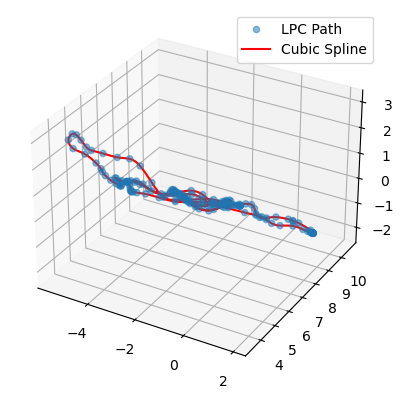

In [43]:
lpc.plot_cubic_spline_3d(0)

# plotting function

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_trajectories_3d(splines_final):
    """
    Plots PCA trajectories for different perturbations and datasets in a 3D Plotly plot.

    Parameters:
    splines_final (pd.DataFrame): DataFrame containing the trajectory data with columns
                                  ['dataset', 'Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']

    Returns:
    None
    """
    # Define perturbations and their corresponding colors
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    
    color_map = {
        "wnt-i": "red",
        "tgfb-i": "green",
        "wt": "blue",
        "lmx1b": "orange",
        "gdf3": "purple"
    }
    
    # Define dataset styles with dash styles
    dataset_styles = {
        "all": {"dash": "solid", "name": "all"},
        "hld": {"dash": "dash", "name": "hld"},
        "hld_aligned": {"dash": "dot", "name": "hld aligned"}
    }
    
    # Initialize the figure
    fig = go.Figure()

    # Iterate over each perturbation
    for pert in pert_comparisons:
        pert_data = splines_final[splines_final['Perturbation'] == pert]
        color = color_map.get(pert, "black")  # Default to black if perturbation not found
        
        # Iterate over each dataset
        for dataset, style in dataset_styles.items():
            dataset_data = pert_data[pert_data['dataset'] == dataset]
            
            if dataset_data.empty:
                continue  # Skip if there's no data for this dataset
            
            # Sort by point_index to ensure proper trajectory
            dataset_data = dataset_data.sort_values(by='point_index')
            
            # Add trace
            fig.add_trace(
                go.Scatter3d(
                    x=dataset_data['PCA_1'],
                    y=dataset_data['PCA_2'],
                    z=dataset_data['PCA_3'],
                    mode='lines',
                    name=f"{pert} - {style['name']}",
                    line=dict(color=color, dash=style['dash'], width=4),
                    )
                )
            
    
    # Show the plot
    return fig

# Example usage:
# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_78.html")

# Now we axtract covariance of splines 



In [123]:
# Required Libraries
import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity

def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation,
    based on the difference vectors (point[i+1] - point[i]) rather than the raw points.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Sort and filter data for this perturbation
        splines_hld_aligned_sorted = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values(by="point_index")
        splines_all_sorted = splines_all[splines_all["Perturbation"] == pert].sort_values(by="point_index")

        data_aligned = splines_hld_aligned_sorted[pca_columns].reset_index(drop=True)
        data_all = splines_all_sorted[pca_columns].reset_index(drop=True)

        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)

        # If fewer than 2 points, we cannot form difference vectors
        if len(data_aligned) < 2:
            print(f"Warning: Perturbation '{pert}' has fewer than 2 points. Cannot compute difference vectors. Skipping.")
            results.append({
                "Perturbation": pert,
                "Colinearity": np.nan,
                "Covariance": np.nan
            })
            continue

        # Compute difference vectors for aligned and all data
        aligned_diffs = data_aligned.diff().dropna().values  # shape: (n-1, 3)
        all_diffs = data_all.diff().dropna().values  # shape: (n-1, 3)

        # Ensure same number of difference vectors
        min_diff_len = min(len(aligned_diffs), len(all_diffs))
        aligned_diffs = aligned_diffs[:min_diff_len]
        all_diffs = all_diffs[:min_diff_len]

        # Compute cosine similarity for each difference vector pair
        cosine_similarities = []
        for i in range(min_diff_len):
            vec_aligned = aligned_diffs[i].reshape(1, -1)
            vec_all_current = all_diffs[i].reshape(1, -1)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)

        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities) if len(cosine_similarities) > 0 else np.nan

        # Calculate covariance between corresponding PCA components on the difference vectors
        # Convert difference arrays back to DataFrame for convenience
        aligned_diff_df = pd.DataFrame(aligned_diffs, columns=pca_columns)
        all_diff_df = pd.DataFrame(all_diffs, columns=pca_columns)

        covariances = []
        for pca in pca_columns:
            cov = np.cov(aligned_diff_df[pca], all_diff_df[pca], bias=True)[0, 1]
            covariances.append(cov)
        avg_covariance = np.mean(covariances) if len(covariances) > 0 else np.nan
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def global_direction_consistency(splines_hld_aligned, splines_all):
    """
    Measures how well the start-to-end direction vectors of each perturbation align
    between the aligned and all datasets.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'GlobalColinearity', 'GlobalCovariance'].
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []
    for pert in perturbations:
        data_a = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns].values
        data_b = splines_all[splines_all["Perturbation"] == pert][pca_columns].values

        # Ensure same length
        min_len = min(len(data_a), len(data_b))
        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        if len(data_a) < 2:
            results.append({"Perturbation": pert, "GlobalColinearity": np.nan, "GlobalCovariance": np.nan})
            continue

        start_a, end_a = data_a[0], data_a[-1]
        start_b, end_b = data_b[0], data_b[-1]

        vec_a = end_a - start_a
        vec_b = end_b - start_b

        # Normalize
        norm_a = np.linalg.norm(vec_a)
        norm_b = np.linalg.norm(vec_b)
        if norm_a == 0 or norm_b == 0:
            sim = np.nan
        else:
            sim = cosine_similarity(vec_a.reshape(1, -1), vec_b.reshape(1, -1))[0][0]

        # Covariance between end-to-end vectors
        # Since covariance is not meaningful for single pairs, use dot product as a placeholder
        if norm_a > 0 and norm_b > 0:
            dot_prod = np.dot(vec_a / norm_a, vec_b / norm_b)
        else:
            dot_prod = np.nan

        results.append({"Perturbation": pert, "GlobalColinearity": sim, "GlobalCovariance": dot_prod})

    return pd.DataFrame(results)

def sliding_window_directionality(splines_hld_aligned, splines_all, window_size=5):
    """
    Uses a sliding window approach to measure directionality. For each window in the trajectory,
    compute a direction vector and compare these between aligned and all datasets.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - window_size (int): Number of points in each sliding window (default=5).

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'WindowedColinearity', 'WindowedCovariance'].
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []

    for pert in perturbations:
        data_a = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns].values
        data_b = splines_all[splines_all["Perturbation"] == pert][pca_columns].values

        min_len = min(len(data_a), len(data_b))
        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        if min_len < window_size + 1:
            # Not enough points for at least one window
            results.append({"Perturbation": pert, "WindowedColinearity": np.nan, "WindowedCovariance": np.nan})
            continue

        aligned_vectors = []
        all_vectors = []
        for i in range(min_len - window_size):
            vec_a = data_a[i+window_size] - data_a[i]
            vec_b = data_b[i+window_size] - data_b[i]

            norm_a = np.linalg.norm(vec_a)
            norm_b = np.linalg.norm(vec_b)
            if norm_a > 0:
                vec_a = vec_a / norm_a
            else:
                vec_a = np.zeros(3)
            if norm_b > 0:
                vec_b = vec_b / norm_b
            else:
                vec_b = np.zeros(3)

            aligned_vectors.append(vec_a)
            all_vectors.append(vec_b)

        aligned_vectors = np.array(aligned_vectors)
        all_vectors = np.array(all_vectors)

        if len(aligned_vectors) == 0:
            results.append({"Perturbation": pert, "WindowedColinearity": np.nan, "WindowedCovariance": np.nan})
            continue

        # Compute cosine similarities
        cos_sims = []
        for i in range(len(aligned_vectors)):
            va = aligned_vectors[i].reshape(1, -1)
            vb = all_vectors[i].reshape(1, -1)
            sim = cosine_similarity(va, vb)[0][0]
            cos_sims.append(sim)

        avg_cosine_sim = np.mean(cos_sims) if len(cos_sims) > 0 else np.nan

        # Compute covariance dimension-wise across windows
        covariances = []
        for dim_idx in range(3):
            dim_a = aligned_vectors[:, dim_idx]
            dim_b = all_vectors[:, dim_idx]
            if len(dim_a) > 1:
                cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
            else:
                cov = np.nan
            covariances.append(cov)

        avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        results.append({"Perturbation": pert, "WindowedColinearity": avg_cosine_sim, "WindowedCovariance": avg_cov})

    return pd.DataFrame(results)


def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df
def calculate_within_dataset_colinearity_covariance(dataset_df):
    """
    Calculates colinearity (average cosine similarity) and covariance within a single dataset by examining
    the covariance between each unique pair of perturbations based on their difference vectors.

    Parameters:
    - dataset_df (pd.DataFrame): DataFrame containing at least the columns:
        ['Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']
      representing a single dataset (e.g., all, hld_aligned, etc.)

    Returns:
    - pd.DataFrame: A DataFrame with columns:
        ['average_pairwise_covariance', 'variance_of_pairwise_covariances',
         'average_pairwise_cosine_similarity', 'variance_of_pairwise_cosine_similarities']
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    
    # Validate presence of required PCA columns
    for col in pca_columns:
        if col not in dataset_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Get unique perturbations
    perturbations = dataset_df["Perturbation"].unique()
    
    # Initialize lists to store pairwise covariances and cosine similarities
    pairwise_covariances = []
    pairwise_cosine_similarities = []
    
    # Generate all unique perturbation pairs
    for pert1, pert2 in combinations(perturbations, 2):
        # Filter and sort data for each perturbation
        data_pert1 = dataset_df[dataset_df["Perturbation"] == pert1].sort_values(by="point_index")[pca_columns].values
        data_pert2 = dataset_df[dataset_df["Perturbation"] == pert2].sort_values(by="point_index")[pca_columns].values
        
        # Ensure both perturbations have at least two points to form difference vectors
        if len(data_pert1) < 2 or len(data_pert2) < 2:
            print(f"Warning: Perturbations '{pert1}' and/or '{pert2}' have fewer than 2 points. Skipping this pair.")
            continue
        
        # Compute difference vectors for each perturbation
        diffs_pert1 = data_pert1[1:] - data_pert1[:-1]  # Shape: (n-1, 3)
        diffs_pert2 = data_pert2[1:] - data_pert2[:-1]  # Shape: (m-1, 3)
        
        # Align the number of difference vectors by truncating to the minimum length
        min_diff_len = min(len(diffs_pert1), len(diffs_pert2))
        if min_diff_len == 0:
            print(f"Warning: Perturbations '{pert1}' and/or '{pert2}' have no overlapping difference vectors. Skipping this pair.")
            continue
        diffs_pert1 = diffs_pert1[:min_diff_len]
        diffs_pert2 = diffs_pert2[:min_diff_len]
        
        # Compute cosine similarities for each pair of difference vectors
        cosine_similarities = []
        for i in range(min_diff_len):
            vec1 = diffs_pert1[i].reshape(1, -1)
            vec2 = diffs_pert2[i].reshape(1, -1)
            sim = cosine_similarity(vec1, vec2)[0][0]
            cosine_similarities.append(sim)
        
        # Average cosine similarity for this perturbation pair
        avg_cos_sim = np.mean(cosine_similarities) if len(cosine_similarities) > 0 else np.nan
        pairwise_cosine_similarities.append(avg_cos_sim)
        
        # Compute covariance between corresponding PCA components
        covariances = []
        for dim_idx, pca in enumerate(pca_columns):
            cov_matrix = np.cov(diffs_pert1[:, dim_idx], diffs_pert2[:, dim_idx], bias=True)
            cov = cov_matrix[0, 1]
            covariances.append(cov)
        
        # Average covariance across PCA components for this perturbation pair
        avg_cov = np.mean(covariances) if len(covariances) > 0 else np.nan
        pairwise_covariances.append(avg_cov)
    
    # Compute aggregate metrics
    if len(pairwise_covariances) == 0:
        avg_pairwise_cov = np.nan
        var_pairwise_cov = np.nan
        avg_pairwise_cos_sim = np.nan
        var_pairwise_cos_sim = np.nan
        print("Warning: No valid perturbation pairs found for covariance and cosine similarity calculations.")
    else:
        avg_pairwise_cov = np.mean(pairwise_covariances)
        var_pairwise_cov = np.var(pairwise_covariances)
        avg_pairwise_cos_sim = np.mean(pairwise_cosine_similarities)
        var_pairwise_cos_sim = np.var(pairwise_cosine_similarities)
    
    # Create the results DataFrame
    results_df = pd.DataFrame([{
        "average_pairwise_covariance": avg_pairwise_cov,
        "variance_of_pairwise_covariances": var_pairwise_cov,
        "average_pairwise_cosine_similarity": avg_pairwise_cos_sim,
        "variance_of_pairwise_cosine_similarities": var_pairwise_cos_sim
    }])
    
    return results_df

# ================================
# Example Usage of the Functions
# ================================
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def segment_direction_consistency(splines_hld_aligned, splines_all, k=10):
    """
    Divide the 'all' trajectory into k segments. For each segment, find the closest points in the 'hld_aligned'
    dataset to the start and end points of that segment. Construct direction vectors based on these closest points
    in 'hld_aligned' and compare them to the segment direction vector in 'all'.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - k (int): Number of segments to divide the trajectory into (default=10).

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'SegmentColinearity', 'SegmentCovariance'].
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []
    for pert in perturbations:
        # Extract and sort data by point_index
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values("point_index")
        data_b_df = splines_all[splines_all["Perturbation"] == pert].sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        # Ensure same length
        min_len = min(len(data_a), len(data_b))
        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        if min_len < k + 1:
            # Not enough points for k segments
            results.append({"Perturbation": pert, "SegmentColinearity": np.nan, "SegmentCovariance": np.nan})
            continue

        # We define segments using splines_all (data_b)
        segment_indices = np.linspace(0, min_len - 1, k + 1, dtype=int)

        aligned_segment_vecs = []
        all_segment_vecs = []

        for i in range(k):
            start_idx = segment_indices[i]
            end_idx = segment_indices[i + 1]

            # Segment in 'all' data
            start_b = data_b[start_idx]
            end_b = data_b[end_idx]

            # Find closest points in 'hld_aligned' to start_b and end_b
            # Compute distances for start
            start_dists = np.linalg.norm(data_a - start_b, axis=1)
            closest_start_idx = np.argmin(start_dists)
            closest_start_a = data_a[closest_start_idx]

            # Compute distances for end
            end_dists = np.linalg.norm(data_a - end_b, axis=1)
            closest_end_idx = np.argmin(end_dists)
            closest_end_a = data_a[closest_end_idx]

            # Construct vectors
            vec_a = closest_end_a - closest_start_a  # from hld_aligned closest points
            vec_b = end_b - start_b  # from all dataset directly

            # Normalize
            norm_a = np.linalg.norm(vec_a)
            norm_b = np.linalg.norm(vec_b)
            if norm_a > 0:
                vec_a = vec_a / norm_a
            else:
                vec_a = np.zeros(3)
            if norm_b > 0:
                vec_b = vec_b / norm_b
            else:
                vec_b = np.zeros(3)

            aligned_segment_vecs.append(vec_a)
            all_segment_vecs.append(vec_b)

        aligned_segment_vecs = np.array(aligned_segment_vecs)
        all_segment_vecs = np.array(all_segment_vecs)

        # Compute cosine similarities for segments
        cos_sims = []
        for i in range(len(aligned_segment_vecs)):
            va = aligned_segment_vecs[i].reshape(1, -1)
            vb = all_segment_vecs[i].reshape(1, -1)
            sim = cosine_similarity(va, vb)[0][0]
            cos_sims.append(sim)

        avg_cosine_sim = np.mean(cos_sims) if len(cos_sims) > 0 else np.nan

        # Compute covariance dimension-wise
        covariances = []
        for dim_idx in range(3):
            dim_a = aligned_segment_vecs[:, dim_idx]
            dim_b = all_segment_vecs[:, dim_idx]
            if len(dim_a) > 1:
                cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
            else:
                cov = np.nan
            covariances.append(cov)
        avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        results.append({"Perturbation": pert, "SegmentColinearity": avg_cosine_sim, "SegmentCovariance": avg_cov})

    return pd.DataFrame(results)


def centroid_based_colinearity(splines_hld_aligned, splines_all):
    """
    For each perturbation, computes direction vectors with respect to each dataset's centroid
    and measures how well these direction vectors align between the aligned and all datasets.

    Steps:
    1. Extract data for a given perturbation from both splines_hld_aligned and splines_all.
    2. Match the number of samples by truncation if necessary.
    3. Compute centroid for each dataset (aligned and all) for that perturbation.
    4. For each point i, compute vector from centroid_aligned to point_aligned[i], and from centroid_all to point_all[i].
    5. Compute cosine similarity of these pairs of vectors.
    6. Average these similarities to get colinearity.
    7. Also compute covariance dimension-wise of these centroid-relative vectors between aligned and all datasets, then average.

    Returns:
    A DataFrame with ['Perturbation', 'CentroidColinearity', 'CentroidCovariance'].
    """

    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []
    
    for pert in perturbations:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        # Extract PCA data and ensure sorted by point_index (if point_index exists)
        if "point_index" in data_a_df.columns and "point_index" in data_b_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        # Match lengths by truncation
        min_len = min(len(data_a), len(data_b))
        if min_len == 0:
            # No data to compare
            results.append({"Perturbation": pert, "CentroidColinearity": np.nan, "CentroidCovariance": np.nan})
            continue

        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        # Compute centroids
        centroid_a = np.mean(data_a, axis=0)
        centroid_b = np.mean(data_b, axis=0)

        # Compute vectors relative to centroids
        rel_a = data_a - centroid_a  # shape (min_len, 3)
        rel_b = data_b - centroid_b  # shape (min_len, 3)

        # If there's only one point, can't compute direction or covariance meaningfully
        if min_len == 1:
            # With a single point, direction from centroid is well-defined, but we can't get much variability
            # We'll just compute cosine similarity of these single vectors and no covariance
            va = rel_a[0].reshape(1, -1)
            vb = rel_b[0].reshape(1, -1)
            norm_va = np.linalg.norm(rel_a[0])
            norm_vb = np.linalg.norm(rel_b[0])
            if norm_va > 0 and norm_vb > 0:
                sim = cosine_similarity(va, vb)[0][0]
            else:
                sim = np.nan
            # Covariance with one sample each doesn't make sense, set to NaN
            cov = np.nan
            results.append({"Perturbation": pert, "CentroidColinearity": sim, "CentroidCovariance": cov})
            continue

        # Compute cosine similarities for each point
        # Note: If vectors are zero-length (coincides with centroid), similarity is not defined
        cos_sims = []
        for i in range(min_len):
            va = rel_a[i].reshape(1, -1)
            vb = rel_b[i].reshape(1, -1)
            norm_va = np.linalg.norm(rel_a[i])
            norm_vb = np.linalg.norm(rel_b[i])
            if norm_va > 0 and norm_vb > 0:
                sim = cosine_similarity(va, vb)[0][0]
                cos_sims.append(sim)
            else:
                # If one vector is zero, skip or consider similarity as NaN
                cos_sims.append(np.nan)

        # Average cosine similarity, ignoring NaNs
        if len(cos_sims) > 0:
            avg_cosine_sim = np.nanmean(cos_sims)
        else:
            avg_cosine_sim = np.nan

        # Compute covariance dimension-wise
        # We have multiple samples now (min_len) from rel_a and rel_b
        # We'll compute covariance across matched samples dimension-wise
        covariances = []
        for dim_idx in range(3):
            dim_a = rel_a[:, dim_idx]
            dim_b = rel_b[:, dim_idx]
            # If we have at least 2 samples, we can compute covariance
            if len(dim_a) > 1:
                cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
            else:
                cov = np.nan
            covariances.append(cov)

        avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        results.append({"Perturbation": pert, "CentroidColinearity": avg_cosine_sim, "CentroidCovariance": avg_cov})

    return pd.DataFrame(results)




def combined_centroid_colinearity(splines_hld_aligned, splines_all):
    """
    For each perturbation, computes direction vectors with respect to a combined centroid derived from both datasets.
    This ensures a common reference frame.

    Steps:
    1. For each perturbation, gather all points from both splines_hld_aligned and splines_all.
    2. Compute a single combined centroid from all these points (aligned + all).
    3. For each dataset (aligned and all), compute vectors from this combined centroid to each point.
    4. Match the number of samples by truncation (min length).
    5. For each matched point index, compute cosine similarity between the aligned and all vectors (both relative to the combined centroid).
    6. Average these similarities to get colinearity.
    7. Compute covariance dimension-wise between the sets of relative vectors and average to get covariance.

    Returns:
    A DataFrame with ['Perturbation', 'CombinedCentroidColinearity', 'CombinedCentroidCovariance'].
    """

    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []

    for pert in perturbations:
        # Extract data for the perturbation
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        # Sort by point_index if available
        if "point_index" in data_a_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
        if "point_index" in data_b_df.columns:
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        # If no data in either dataset, skip
        if len(data_a) == 0 or len(data_b) == 0:
            results.append({"Perturbation": pert, "CombinedCentroidColinearity": np.nan, "CombinedCentroidCovariance": np.nan})
            continue

        # Combine all points from both datasets to find a common centroid
        combined_data = np.vstack([data_a, data_b])
        combined_centroid = np.mean(combined_data, axis=0)  # shape (3,)

        # Compute relative vectors to the combined centroid
        rel_a = data_a - combined_centroid
        rel_b = data_b - combined_centroid

        # Truncate to min length if needed
        min_len = min(len(rel_a), len(rel_b))
        if min_len == 0:
            # No comparison possible
            results.append({"Perturbation": pert, "CombinedCentroidColinearity": np.nan, "CombinedCentroidCovariance": np.nan})
            continue

        rel_a = rel_a[:min_len]
        rel_b = rel_b[:min_len]

        if min_len == 1:
            # With a single point, just compute cosine similarity if possible
            va = rel_a[0].reshape(1, -1)
            vb = rel_b[0].reshape(1, -1)
            norm_va = np.linalg.norm(rel_a[0])
            norm_vb = np.linalg.norm(rel_b[0])
            if norm_va > 0 and norm_vb > 0:
                sim = cosine_similarity(va, vb)[0][0]
            else:
                sim = np.nan
            cov = np.nan  # Covariance not defined for single sample
            results.append({"Perturbation": pert, "CombinedCentroidColinearity": sim, "CombinedCentroidCovariance": cov})
            continue

        # Compute cosine similarities point-by-point
        cos_sims = []
        for i in range(min_len):
            va = rel_a[i].reshape(1, -1)
            vb = rel_b[i].reshape(1, -1)
            norm_va = np.linalg.norm(rel_a[i])
            norm_vb = np.linalg.norm(rel_b[i])
            if norm_va > 0 and norm_vb > 0:
                sim = cosine_similarity(va, vb)[0][0]
                cos_sims.append(sim)
            else:
                # If zero vector, can't compute meaningful similarity
                cos_sims.append(np.nan)

        avg_cosine_sim = np.nanmean(cos_sims) if len(cos_sims) > 0 else np.nan

        # Compute covariance dimension-wise
        covariances = []
        for dim_idx in range(3):
            dim_a = rel_a[:, dim_idx]
            dim_b = rel_b[:, dim_idx]
            if len(dim_a) > 1:
                c = np.cov(dim_a, dim_b, bias=True)[0, 1]
            else:
                c = np.nan
            covariances.append(c)
        avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        results.append({"Perturbation": pert, "CombinedCentroidColinearity": avg_cosine_sim, "CombinedCentroidCovariance": avg_cov})

    return pd.DataFrame(results)


for key in splines_final_dict.keys():
    print(key)
    splines_final_df = splines_final_dict[key]

    splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

    # -------------------------------------
    # 1. Original Colinearity & Covariance
    # -------------------------------------
    print("=== Original Colinearity & Covariance ===")
    original_results = calculate_colinearity_covariance(splines_hld_aligned, splines_all)
    print(original_results)
    print("\n")


    results_df = combined_centroid_colinearity(splines_hld_aligned, splines_all)
    print(results_df)


    results_df = combined_centroid_segment_direction_consistency_with_closest_points(splines_hld_aligned, splines_all)
    print(results_df)
    # -----------------------------------
    # 2. Global Direction Consistency
    # -----------------------------------
    print("=== Global Direction Consistency ===")
    global_dir_results = global_direction_consistency(splines_hld_aligned, splines_all)
    print(global_dir_results)
    print("\n")

    # ----------------------------------------
    # 3. Sliding Window Directionality
    # ----------------------------------------
    print("=== Sliding Window Directionality ===")
    sliding_window_results = sliding_window_directionality(splines_hld_aligned, splines_all, window_size=1)
    print(sliding_window_results)
    print("\n")

    # ------------------------------------------------
    # 4. Segment-Based Direction Consistency (k=2)
    # ------------------------------------------------
    print("=== Segment-Based Direction Consistency ===")
    segment_results = segment_direction_consistency(splines_hld_aligned, splines_all, k=100)
    print(segment_results)
    print("\n")

    # # ------------------------------------------------
    # # 5. Within-Dataset Colinearity & Covariance
    # # ------------------------------------------------
    # Example using 'splines_all' dataset
    print("=== Within-Dataset Colinearity & Covariance (splines_all) ===")
    within_cov_results_all = calculate_within_dataset_colinearity_covariance(splines_all)
    print(within_cov_results_all)
    print("\n")

    # # Example using 'splines_hld_aligned' dataset
    print("=== Within-Dataset Colinearity & Covariance (splines_hld_aligned) ===")
    within_cov_results_hld = calculate_within_dataset_colinearity_covariance(splines_hld_aligned)
    print(within_cov_results_hld)

    # Example usage:
    results_df = centroid_based_colinearity(splines_hld_aligned, splines_all)
    print(results_df)
    # Example usage:
    results_df = segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=10)
    print(results_df)


# splines_final_df = splines_final_dict[71]

    import numpy as np
    import scipy.linalg as la

    #############################
    # 1. Hybrid Similarity (Direction + Magnitude)
    #############################
    def hybrid_similarity(x, y):
        """
        Computes a hybrid similarity measure between two vectors x and y.
        This measure accounts for both direction (cosine similarity) and magnitude differences.
        
        hybrid_sim = cosine_similarity(x, y) * (min(||x||, ||y||) / max(||x||, ||y||))
        """
        norm_x = np.linalg.norm(x)
        norm_y = np.linalg.norm(y)
        if norm_x == 0 or norm_y == 0:
            return np.nan
        cos_sim = np.dot(x, y) / (norm_x * norm_y)
        mag_ratio = min(norm_x, norm_y) / max(norm_x, norm_y)
        return cos_sim * mag_ratio

    #############################
    # 2. Principal Angles Between Subspaces
    #############################
    def principal_angles(U, V):
        """
        Compute principal angles between two subspaces defined by orthonormal basis vectors in U and V.
        
        U and V should be matrices with shape (n, r) where columns are orthonormal basis vectors.
        Principal angles are computed from the singular values of U^T V:
        cos(theta_i) = singular_values[i].
        
        Returns:
        angles: array of principal angles (in radians).
        """
        # Orthonormalize U and V if they are not already
        # Here we assume U and V are already orthonormal. If not, consider QR decomposition.
        M = np.dot(U.T, V)
        # SVD of M
        _, s, _ = la.svd(M)
        # s are cosines of principal angles
        s = np.clip(s, -1.0, 1.0)  # numerical stability
        angles = np.arccos(s)
        return angles

    def subspace_similarity(U, V):
        """
        Compute a similarity measure between two subspaces based on their principal angles.
        A simple way: similarity = average of cosines of principal angles.
        Smaller angles mean higher similarity.
        
        Steps:
        1. Compute principal angles between subspaces U and V.
        2. Convert angles back to cosines.
        3. Take average cosine as similarity measure.
        """
        angles = principal_angles(U, V)
        # cosines of angles were s, we can just reconstruct
        # But we have angles, so cos them
        cosines = np.cos(angles)
        return np.mean(cosines)

    #############################
    # 3. Procrustes Analysis
    #############################
    def procrustes_analysis(X, Y, scaling=True, reflection=True):
        """
        Perform a simplified Procrustes analysis to align matrix Y to X.
        X and Y are matrices of shape (n, d), where n is number of points and d dimensions.
        This finds the best translation, (optionally) scaling, and rotation (and reflection) that maps Y onto X.
        
        Returns:
        disparity: a measure of how different X and Y are after alignment. Lower is more similar.
        
        You can convert disparity to a similarity measure by something like:
        similarity = 1 / (1 + disparity)
        """
        # Center X and Y
        X_mean = np.mean(X, axis=0)
        Y_mean = np.mean(Y, axis=0)
        X_centered = X - X_mean
        Y_centered = Y - Y_mean

        # Compute norms
        normX = np.linalg.norm(X_centered, 'fro')
        normY = np.linalg.norm(Y_centered, 'fro')
        if normX == 0 or normY == 0:
            # If either is zero variation, can't align meaningfully
            return np.nan

        # Optionally scale
        if scaling:
            s = normX / normY
        else:
            s = 1.0

        Y_scaled = Y_centered * s

        # Compute rotation/reflection
        A = np.dot(X_centered.T, Y_scaled)
        U, sigma, Vt = la.svd(A, full_matrices=False)
        R = np.dot(U, Vt)
        # If no reflection allowed and det(R)<0, fix it
        if not reflection and la.det(R) < 0:
            U[:, -1] *= -1
            R = np.dot(U, Vt)

        Y_aligned = np.dot(Y_scaled, R)

        # Compute disparity (sum of squared differences)
        diff = X_centered - Y_aligned
        disparity = np.sum(diff**2)

        return disparity

    def procrustes_similarity(X, Y, scaling=True, reflection=True):
        """
        Convert Procrustes disparity into a similarity measure.
        similarity = 1 / (1 + disparity)
        """
        disp = procrustes_analysis(X, Y, scaling=scaling, reflection=reflection)
        if disp is np.nan:
            return np.nan
        return 1 / (1 + disp)

    #############################
    # 4. Correlation-Based Similarity
    #############################


71
=== Original Colinearity & Covariance ===
  Perturbation  Colinearity  Covariance
0        lmx1b    -0.247321   -0.328111
1        wnt-i     0.381638   -0.336238
2         gdf3    -0.084955   -0.450503
3       tgfb-i     0.033203   -0.381043
4           wt    -0.172726   -0.184991


  Perturbation  CombinedCentroidColinearity  CombinedCentroidCovariance
0        lmx1b                     0.992172                    1.061981
1        wnt-i                     0.994929                    0.433795
2         gdf3                     0.998296                    0.674187
3       tgfb-i                     0.998379                    0.601633
4           wt                     0.999571                    1.151202


NameError: name 'combined_centroid_segment_direction_consistency_with_closest_points' is not defined

In [154]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import scipy.linalg as la

#############################
# 1. Hybrid Similarity (Direction + Magnitude)
#############################
def hybrid_similarity(x, y):
    """
    Computes a hybrid similarity measure between two vectors x and y.
    This measure accounts for both direction (cosine similarity) and magnitude differences.
    
    hybrid_sim = cosine_similarity(x, y) * (min(||x||, ||y||) / max(||x||, ||y||))
    
    Parameters:
    - x (np.ndarray): First vector.
    - y (np.ndarray): Second vector.
    
    Returns:
    - float: Hybrid similarity score.
    """
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    if norm_x == 0 or norm_y == 0:
        return np.nan
    cos_sim = np.dot(x, y) / (norm_x * norm_y)
    mag_ratio = min(norm_x, norm_y) / max(norm_x, norm_y)
    return cos_sim * mag_ratio

#############################
# 2. Principal Angles Between Subspaces
#############################
def principal_angles(U, V):
    """
    Compute principal angles between two subspaces defined by orthonormal basis vectors in U and V.
    
    U and V should be matrices with shape (n, r) where columns are orthonormal basis vectors.
    Principal angles are computed from the singular values of U^T V:
    cos(theta_i) = singular_values[i].
    
    Parameters:
    - U (np.ndarray): Orthonormal basis matrix for subspace U.
    - V (np.ndarray): Orthonormal basis matrix for subspace V.
    
    Returns:
    - np.ndarray: Array of principal angles in radians.
    """
    M = np.dot(U.T, V)
    _, s, _ = la.svd(M)
    s = np.clip(s, -1.0, 1.0)  # Numerical stability
    angles = np.arccos(s)
    return angles

def subspace_similarity(U, V):
    """
    Compute a similarity measure between two subspaces based on their principal angles.
    A higher similarity indicates smaller principal angles.
    
    Steps:
    1. Compute principal angles between subspaces U and V.
    2. Convert angles back to cosines.
    3. Take average cosine as similarity measure.
    
    Parameters:
    - U (np.ndarray): Orthonormal basis matrix for subspace U.
    - V (np.ndarray): Orthonormal basis matrix for subspace V.
    
    Returns:
    - float: Subspace similarity score.
    """
    angles = principal_angles(U, V)
    cosines = np.cos(angles)
    return np.mean(cosines)

#############################
# 3. Procrustes Analysis
#############################
def procrustes_analysis(X, Y, scaling=True, reflection=True):
    """
    Perform Procrustes analysis to align matrix Y to X.
    
    Parameters:
    - X (np.ndarray): Reference matrix of shape (n, d).
    - Y (np.ndarray): Matrix to align to X of shape (n, d).
    - scaling (bool): Whether to allow scaling.
    - reflection (bool): Whether to allow reflection.
    
    Returns:
    - float: Procrustes disparity (sum of squared differences after alignment).
    """
    # Center the matrices
    X_mean = np.mean(X, axis=0)
    Y_mean = np.mean(Y, axis=0)
    X_centered = X - X_mean
    Y_centered = Y - Y_mean

    # Compute norms
    normX = np.linalg.norm(X_centered, 'fro')
    normY = np.linalg.norm(Y_centered, 'fro')
    if normX == 0 or normY == 0:
        return np.nan

    # Optionally scale
    if scaling:
        s = normX / normY
    else:
        s = 1.0

    Y_scaled = Y_centered * s

    # Compute rotation/reflection
    A = np.dot(X_centered.T, Y_scaled)
    U, sigma, Vt = la.svd(A, full_matrices=False)
    R = np.dot(U, Vt)
    if not reflection and la.det(R) < 0:
        U[:, -1] *= -1
        R = np.dot(U, Vt)

    Y_aligned = np.dot(Y_scaled, R)

    # Compute disparity (sum of squared differences)
    diff = X_centered - Y_aligned
    disparity = np.sum(diff**2)

    return disparity

def procrustes_similarity(X, Y, scaling=True, reflection=True):
    """
    Convert Procrustes disparity into a similarity measure.
    similarity = 1 / (1 + disparity)
    
    Parameters:
    - X (np.ndarray): Reference matrix of shape (n, d).
    - Y (np.ndarray): Matrix to align to X of shape (n, d).
    - scaling (bool): Whether to allow scaling.
    - reflection (bool): Whether to allow reflection.
    
    Returns:
    - float: Procrustes similarity score.
    """
    disp = procrustes_analysis(X, Y, scaling=scaling, reflection=reflection)
    if np.isnan(disp):
        return np.nan
    return 1 / (1 + disp)

#############################
# 4. Correlation-Based Similarity (Per-Dimension)
#############################
def correlation_similarity(X, Y):
    """
    Compute correlation-based similarity between two sets of matched points X and Y.
    X and Y: shape (n, d)
    For each dimension, compute correlation between X[:, dim] and Y[:, dim].
    Then average correlations across dimensions.
    
    Parameters:
    - X (np.ndarray): First matrix of shape (n, d).
    - Y (np.ndarray): Second matrix of shape (n, d).
    
    Returns:
    - float: Average Pearson correlation across dimensions.
    """
    if X.shape != Y.shape:
        # Truncate to min length
        min_len = min(len(X), len(Y))
        X = X[:min_len]
        Y = Y[:min_len]

    n, d = X.shape
    if n < 2:
        return np.nan

    corrs = []
    for dim in range(d):
        x_dim = X[:, dim]
        y_dim = Y[:, dim]
        # If constant, correlation is not defined
        if np.allclose(x_dim, x_dim[0]) or np.allclose(y_dim, y_dim[0]):
            corrs.append(np.nan)
            continue
        c = np.corrcoef(x_dim, y_dim)[0, 1]
        corrs.append(c)

    return np.nanmean(corrs)

#############################
# 5. Multivariate Correlation Similarity
#############################
def multivariate_correlation_similarity(X, Y):
    """
    Compute a multivariate Pearson correlation similarity between two sets of 3D points X and Y.
    This captures inter-dimensional correlations, considering the entire 3D vectors jointly.
    
    Steps:
    1. Ensure X and Y have the same shape, truncate if necessary.
    2. Flatten the 3D vectors into 9-dimensional vectors (for 3D points).
    3. Compute the Pearson correlation coefficient between the flattened X and Y.
    
    Alternatively, compute the full 3x3 correlation matrix and summarize it.
    
    Here, we'll compute the full 3x3 correlation matrix and take the mean of its absolute values.
    
    Parameters:
    - X (np.ndarray): First matrix of shape (n, 3).
    - Y (np.ndarray): Second matrix of shape (n, 3).
    
    Returns:
    - float: Average absolute Pearson correlation across all dimensions and inter-dimension pairs.
    """
    if X.shape != Y.shape:
        # Truncate to min length
        min_len = min(len(X), len(Y))
        X = X[:min_len]
        Y = Y[:min_len]

    n, d = X.shape
    if n < 2:
        return np.nan

    # Initialize a list to store correlations
    correlations = []

    # Compute Pearson correlation for each pair of dimensions (including inter-dimensional)
    for i in range(d):
        for j in range(d):
            x_dim = X[:, i]
            y_dim = Y[:, j]
            if np.allclose(x_dim, x_dim[0]) or np.allclose(y_dim, y_dim[0]):
                correlations.append(0)  # Define correlation with constant vector as 0
                continue
            c = np.corrcoef(x_dim, y_dim)[0, 1]
            correlations.append(abs(c))  # Take absolute to capture similarity regardless of direction

    # Average the absolute correlations
    avg_multivar_corr = np.mean(correlations)
    return avg_multivar_corr

#############################
# Combined Analysis Function
#############################
def analyze_datasets(splines_hld_aligned, splines_all):
    """
    Analyze similarity between splines_hld_aligned and splines_all datasets using multiple metrics:
    - Hybrid Similarity
    - Subspace Similarity
    - Procrustes Similarity
    - Correlation Similarity
    - Multivariate Correlation Similarity
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    
    Returns:
    - pd.DataFrame: DataFrame with similarity metrics for each perturbation.
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    # Validate presence of PCA columns
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Identify common perturbations
    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []

    for pert in perturbations:
        # Extract and sort data by point_index if available
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        if "point_index" in data_a_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
        if "point_index" in data_b_df.columns:
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        # Match lengths by truncation
        min_len = min(len(data_a), len(data_b))
        if min_len == 0:
            # No data to compare
            results.append({
                "Perturbation": pert,
                "HybridSimilarity": np.nan,
                "SubspaceSimilarity": np.nan,
                "ProcrustesSimilarity": np.nan,
                "CorrelationSimilarity": np.nan,
                "MultivariateCorrelationSimilarity": np.nan
            })
            continue

        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        # Hybrid Similarity
        hybrid_sims = []
        for i in range(min_len):
            sim = hybrid_similarity(data_a[i], data_b[i])
            hybrid_sims.append(sim)
        avg_hybrid_sim = np.nanmean(hybrid_sims) if len(hybrid_sims) > 0 else np.nan

        # Subspace Similarity
        # For subspace similarity, we'll use PCA on both datasets and compare the top components
        # Here, we consider the entire set of points as a single subspace
        # Or alternatively, compute PCA and take the top r components
        # For simplicity, we'll compute PCA-like orthonormal basis via SVD

        # Compute orthonormal bases
        # If the number of points < number of dimensions, reduce dimensions
        r = min(3, min_len)
        try:
            U_a, _, _ = la.svd(data_a, full_matrices=False)
            U_a = U_a[:, :r]
            U_b, _, _ = la.svd(data_b, full_matrices=False)
            U_b = U_b[:, :r]
            sub_sim = subspace_similarity(U_a, U_b)
        except Exception as e:
            print(f"Error computing subspace similarity for perturbation '{pert}': {e}")
            sub_sim = np.nan

        # Procrustes Similarity
        proc_sim = procrustes_similarity(data_a, data_b, scaling=True, reflection=True)

        # Correlation Similarity (Per-Dimension)
        corr_sim = correlation_similarity(data_a, data_b)

        # Multivariate Correlation Similarity
        multivar_corr_sim = multivariate_correlation_similarity(data_a, data_b)

        # Append results
        results.append({
            "Perturbation": pert,
            "HybridSimilarity": avg_hybrid_sim,
            "SubspaceSimilarity": sub_sim,
            "ProcrustesSimilarity": proc_sim,
            "CorrelationSimilarity": corr_sim,
            "MultivariateCorrelationSimilarity": multivar_corr_sim
        })

    return pd.DataFrame(results)

#############################
# Example Usage (commented out)
#############################
for key in splines_final_dict.keys():
    print(key)
    splines_final_df = splines_final_dict[key]

    splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

    # -------------------------------------
    # Analyze Datasets
    # -------------------------------------
    similarity_results = analyze_datasets(splines_hld_aligned, splines_all)
    print("=== Similarity Metrics Between splines_hld_aligned and splines_all ===")
    print(similarity_results)
    print("\n")

    # -----------------------------------
    # Additional: Display Summary Statistics
    # -----------------------------------
    print("=== Summary Statistics of Similarity Metrics ===")
    summary_stats = similarity_results.describe()
    print(summary_stats)

71
=== Similarity Metrics Between splines_hld_aligned and splines_all ===
  Perturbation  HybridSimilarity  SubspaceSimilarity  ProcrustesSimilarity  \
0        lmx1b          0.450651            0.667144              0.000346   
1         gdf3          0.648401            0.862183              0.001021   
2       tgfb-i          0.729011            0.874770              0.004942   
3        wnt-i          0.840035            0.879879              0.005009   
4           wt          0.616647            0.880801              0.001222   

   CorrelationSimilarity  MultivariateCorrelationSimilarity  
0               0.332809                           0.535118  
1               0.836458                           0.736015  
2               0.913953                           0.789725  
3               0.925438                           0.866894  
4               0.679850                           0.452220  


=== Summary Statistics of Similarity Metrics ===
       HybridSimilarity  SubspaceS

dict_keys([71, 77, 78])

In [169]:
splines_final_df = splines_final_dict[71]

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

# ------------------------------------------------
# 4. Segment-Based Direction Consistency (k=2)
# ------------------------------------------------
print("=== Segment-Based Direction Consistency ===")
segment_results = segment_direction_consistency(splines_hld_aligned, splines_all, k=100)
print(segment_results)
print("\n")


results_df = segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=10)
print(results_df)

# ------------------------------------------------
# 5. Within-Dataset Colinearity & Covariance
# ------------------------------------------------
# Example using 'splines_all' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_all) ===")
within_cov_results_all = calculate_within_dataset_colinearity_covariance(splines_all)
print(within_cov_results_all)
print("\n")

# Example using 'splines_hld_aligned' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_hld_aligned) ===")
within_cov_results_hld = calculate_within_dataset_colinearity_covariance(splines_hld_aligned)
print(within_cov_results_hld)

=== Segment-Based Direction Consistency ===
  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.480851           0.158734
1         gdf3            0.494776           0.125182
2       tgfb-i            0.572552           0.120258
3        wnt-i            0.504509           0.099917
4           wt            0.595342           0.172638


  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.562402           0.177374
1         gdf3            0.578451           0.145115
2       tgfb-i            0.780757           0.155639
3        wnt-i            0.683730           0.141769
4           wt            0.691878           0.204531
=== Within-Dataset Colinearity & Covariance (splines_all) ===
   average_pairwise_covariance  variance_of_pairwise_covariances  \
0                     0.000048                      1.549281e-09   

   average_pairwise_cosine_similarity  \
0                            0.506757   

   variance_of_pairwise_

In [170]:
splines_final_df = splines_final_dict[77]

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

# ------------------------------------------------
# 4. Segment-Based Direction Consistency (k=2)
# ------------------------------------------------
print("=== Segment-Based Direction Consistency ===")
segment_results = segment_direction_consistency(splines_hld_aligned, splines_all, k=100)
print(segment_results)
print("\n")

results_df = segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=100)
print(results_df)

# ------------------------------------------------
# 5. Within-Dataset Colinearity & Covariance
# ------------------------------------------------
# Example using 'splines_all' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_all) ===")
within_cov_results_all = calculate_within_dataset_colinearity_covariance(splines_all)
print(within_cov_results_all)
print("\n")

# Example using 'splines_hld_aligned' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_hld_aligned) ===")
within_cov_results_hld = calculate_within_dataset_colinearity_covariance(splines_hld_aligned)
print(within_cov_results_hld)

=== Segment-Based Direction Consistency ===
  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.286303           0.087361
1         gdf3            0.043424           0.014643
2       tgfb-i            0.043996           0.023260
3        wnt-i            0.291913           0.071262
4           wt            0.542593           0.154556


  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.286303           0.087361
1         gdf3            0.043424           0.014643
2       tgfb-i            0.043996           0.023260
3        wnt-i            0.291913           0.071262
4           wt            0.542593           0.154556
=== Within-Dataset Colinearity & Covariance (splines_all) ===


   average_pairwise_covariance  variance_of_pairwise_covariances  \
0                 7.136650e-07                      1.553817e-09   

   average_pairwise_cosine_similarity  \
0                            0.005887   

   variance_of_pairwise_cosine_similarities  
0                                  0.053551  


=== Within-Dataset Colinearity & Covariance (splines_hld_aligned) ===
   average_pairwise_covariance  variance_of_pairwise_covariances  \
0                     0.000021                      5.791133e-10   

   average_pairwise_cosine_similarity  \
0                             0.34438   

   variance_of_pairwise_cosine_similarities  
0                                  0.021579  


In [171]:
splines_final_df = splines_final_dict[78]

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

# ------------------------------------------------
# 4. Segment-Based Direction Consistency (k=2)
# ------------------------------------------------
print("=== Segment-Based Direction Consistency ===")
segment_results = segment_direction_consistency(splines_hld_aligned, splines_all, k=100)
print(segment_results)
print("\n")

results_df = segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=10)
print(results_df)


# ------------------------------------------------
# 5. Within-Dataset Colinearity & Covariance
# ------------------------------------------------
# Example using 'splines_all' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_all) ===")
within_cov_results_all = calculate_within_dataset_colinearity_covariance(splines_all)
print(within_cov_results_all)
print("\n")

# Example using 'splines_hld_aligned' dataset
print("=== Within-Dataset Colinearity & Covariance (splines_hld_aligned) ===")
within_cov_results_hld = calculate_within_dataset_colinearity_covariance(splines_hld_aligned)
print(within_cov_results_hld)

=== Segment-Based Direction Consistency ===
  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.289904           0.079963
1         gdf3            0.142984           0.046965
2       tgfb-i            0.170891           0.045870
3        wnt-i            0.304959           0.061936
4           wt            0.121527           0.036721


  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.543265           0.159492
1         gdf3            0.191599           0.022260
2       tgfb-i            0.404871           0.124636
3        wnt-i            0.639285           0.138161
4           wt            0.207348           0.044339
=== Within-Dataset Colinearity & Covariance (splines_all) ===
   average_pairwise_covariance  variance_of_pairwise_covariances  \
0                    -0.000088                      3.033434e-08   

   average_pairwise_cosine_similarity  \
0                            0.030972   

   variance_of_pairwise_

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=10):
    """
    Divide the 'all' trajectory into k segments. For each segment, find the closest points in the 'hld_aligned'
    dataset to the start and end points of that segment. Construct direction vectors based on these closest points
    in 'hld_aligned' and compare them to the segment direction vector in 'all'.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - k (int): Number of segments to divide the trajectory into (default=10).

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'SegmentColinearity', 'SegmentCovariance'].
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    perturbations = perts_aligned.intersection(perts_all)

    results = []
    for pert in perturbations:
        # Extract and sort data by point_index
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values("point_index")
        data_b_df = splines_all[splines_all["Perturbation"] == pert].sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        # Ensure same length
        min_len = min(len(data_a), len(data_b))
        data_a = data_a[:min_len]
        data_b = data_b[:min_len]

        if min_len < k + 1:
            # Not enough points for k segments
            results.append({"Perturbation": pert, "SegmentColinearity": np.nan, "SegmentCovariance": np.nan})
            continue

        # We define segments using splines_all (data_b)
        segment_indices = np.linspace(0, min_len - 1, k + 1, dtype=int)

        aligned_segment_vecs = []
        all_segment_vecs = []

        for i in range(k):
            start_idx = segment_indices[i]
            end_idx = segment_indices[i + 1]

            # Segment in 'all' data
            start_b = data_b[start_idx]
            end_b = data_b[end_idx]

            # Find closest points in 'hld_aligned' to start_b and end_b
            # Compute distances for start
            start_dists = np.linalg.norm(data_a - start_b, axis=1)
            closest_start_idx = np.argmin(start_dists)
            closest_start_a = data_a[closest_start_idx]

            # Compute distances for end
            end_dists = np.linalg.norm(data_a - end_b, axis=1)
            closest_end_idx = np.argmin(end_dists)
            closest_end_a = data_a[closest_end_idx]

            # Construct vectors
            vec_a = closest_end_a - closest_start_a  # from hld_aligned closest points
            vec_b = end_b - start_b  # from all dataset directly

            # Normalize
            norm_a = np.linalg.norm(vec_a)
            norm_b = np.linalg.norm(vec_b)
            if norm_a > 0:
                vec_a = vec_a / norm_a
            else:
                vec_a = np.zeros(3)
            if norm_b > 0:
                vec_b = vec_b / norm_b
            else:
                vec_b = np.zeros(3)

            aligned_segment_vecs.append(vec_a)
            all_segment_vecs.append(vec_b)

        aligned_segment_vecs = np.array(aligned_segment_vecs)
        all_segment_vecs = np.array(all_segment_vecs)

        # Compute cosine similarities for segments
        cos_sims = []
        for i in range(len(aligned_segment_vecs)):
            va = aligned_segment_vecs[i].reshape(1, -1)
            vb = all_segment_vecs[i].reshape(1, -1)
            sim = cosine_similarity(va, vb)[0][0]
            cos_sims.append(sim)

        avg_cosine_sim = np.mean(cos_sims) if len(cos_sims) > 0 else np.nan

        # Compute covariance dimension-wise
        covariances = []
        for dim_idx in range(3):
            dim_a = aligned_segment_vecs[:, dim_idx]
            dim_b = all_segment_vecs[:, dim_idx]
            if len(dim_a) > 1:
                cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
            else:
                cov = np.nan
            covariances.append(cov)
        avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        results.append({"Perturbation": pert, "SegmentColinearity": avg_cosine_sim, "SegmentCovariance": avg_cov})

    return pd.DataFrame(results)

# Example usage:
resuts_df = segment_direction_consistency_param_adjusted(splines_hld_aligned, splines_all, k=10)
print(results_df)

  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.543265           0.159492
1         gdf3            0.191599           0.022260
2       tgfb-i            0.404871           0.124636
3        wnt-i            0.639285           0.138161
4           wt            0.207348           0.044339


In [ ]:
splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [125]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial points to consider for initial dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize list to store initial dispersions
        initial_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index
            point_df = dataset_df[dataset_df["point_index"] == pid]
            
            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
        
        # Calculate average initial dispersion
        if len(initial_dispersions) == 0:
            dispersion_first_n = np.nan
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices. Setting dispersion_first_n to NaN.")
        else:
            dispersion_first_n = np.mean(initial_dispersions)
        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n
0          all          0.002718            0.116642
1  hld_aligned          0.002737            0.179883


# Test Run

In [60]:
#EXAMPLE
print("Model 71 (most linear and stable)")
splines_final_df = splines_final_dict[71]

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results
print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)

print("\n")

print("Model 77 (less stable and linear)")
splines_final_df = splines_final_dict[77]
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)
print("\n")

print("Model 78 (globular and struggles to fit)")
splines_final_df = splines_final_dict[78]
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)


print("\n")


Model 71 (most linear and stable)
  Perturbation  Colinearity  Covariance
0        lmx1b     0.389172    0.700225
1         gdf3     0.625412    0.694381
2       tgfb-i     0.724186    0.673256
3        wnt-i     0.839287    0.516499
4           wt     0.408344    0.812203
Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          1.861074            0.114492           1.355500
1  hld_aligned          1.282790            0.232890           1.601432
Colinearity Each Dataset:
splines_all
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.875251                          0.055126
splines_hld_aligned
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.609103                          0.041661


Model 77 (less stable and linear)
  Perturbation  Colinearity  Covariance
0        lmx1b     0.216168    0.522684
1         gdf3     0.722899    0.590668

In [ ]:
import numpy as np
import pandas as pd
from itertools import combinations

def calculate_within_dataset_colinearity(dataset_df):
    """
    Calculates colinearity within a single dataset by examining the covariance between each unique pair of perturbations.
    
    Steps:
    1. Identify unique perturbations.
    2. For each pair of perturbations, compute the average covariance across PCA_1, PCA_2, and PCA_3.
    3. Aggregate these pairwise covariances:
       - Compute the average of all pairwise covariances.
       - Compute the variance of these pairwise covariances.
    
    Parameters:
    - dataset_df (pd.DataFrame): DataFrame containing at least the columns:
        ['Perturbation', 'PCA_1', 'PCA_2', 'PCA_3']
      representing a single dataset (e.g., all, hld_aligned, etc.)
    
    Returns:
    - pd.DataFrame: A DataFrame with columns:
        ['average_pairwise_covariance', 'variance_of_pairwise_covariances']
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in dataset_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Get unique perturbations
    perturbations = dataset_df["Perturbation"].unique()
    
    pairwise_covariances = []
    
    # Iterate over unique pairs of perturbations
    for pert1, pert2 in combinations(perturbations, 2):
        # print(pert1, pert2)
        data_pert1 = dataset_df[dataset_df["Perturbation"] == pert1][pca_columns]
        data_pert2 = dataset_df[dataset_df["Perturbation"] == pert2][pca_columns]
        
        # Ensure both DataFrames have the same number of samples
        min_len = min(len(data_pert1), len(data_pert2))
        if min_len == 0:
            # Skip if no overlapping samples
            continue
        data_pert1 = data_pert1.iloc[:min_len].reset_index(drop=True)
        data_pert2 = data_pert2.iloc[:min_len].reset_index(drop=True)
        
        # Compute covariance for each PCA component and store it
        covariances = []
        for pca in pca_columns:
            cov_matrix = np.cov(data_pert1[pca], data_pert2[pca], bias=True)
            cov = cov_matrix[0, 1]  # Covariance between the two perturbations for this PCA component
            covariances.append(cov)

        
        
        # Average covariance across PCA components
        
        avg_cov = np.mean(covariances)
        pairwise_covariances.append(avg_cov)
        
        # print(avg_cov)
        # print(covariances)
    
    # Compute the average pairwise covariance
    if len(pairwise_covariances) == 0:
        # No pairs or insufficient data
        avg_pairwise_cov = np.nan
        var_pairwise_cov = np.nan
    else:
        avg_pairwise_cov = np.mean(pairwise_covariances)
        var_pairwise_cov = np.var(pairwise_covariances)
    
    results_df = pd.DataFrame([{
        "average_pairwise_covariance": avg_pairwise_cov,
        "variance_of_pairwise_covariances": var_pairwise_cov
    }])
    
    return results_df


# Calculate within-dataset colinearity metrics
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)

metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)

splines_all
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     -0.24396                          0.733506
splines_hld_aligned
   average_pairwise_covariance  variance_of_pairwise_covariances
0                      0.04027                          0.170759


In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    - Last Dispersion (average dispersion of the last n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial and last points to consider for initial and last dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n', 'dispersion_last_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    points_list = []
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize lists to store initial and last dispersions
        initial_dispersions = []
        last_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index

            point_df = dataset_df[dataset_df["point_index"] == pid]
            points_list.append(point_df)

            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
            
            # If within last n points, store for last dispersion
            if pid >= max(point_indices) - n + 1:
                last_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
            disp_coefficient *= len(point_indices) #this is to normalize it from 0 to 1
        
        # Calculate average initial dispersion
        dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
        if np.isnan(dispersion_first_n):
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")
        
        # Calculate average last dispersion
        dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
        if np.isnan(dispersion_last_n):
            print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")
        

        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n,
            "dispersion_last_n": dispersion_last_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
# Calculate within-dataset colinearity metrics
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]


dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          1.861074            0.114492           1.355500
1  hld_aligned          1.282790            0.237228           1.593353


In [ ]:
# Assuming you have the `splines_final` DataFrame loaded
fig = plot_trajectories_3d(splines_final_df_71)
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_71_test.html")

# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df_77)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_77.html")

In [ ]:

# Combine the two DataFrames


points_list = []
# Ensure PCA columns are present
pca_columns = ["PCA_1", "PCA_2", "PCA_3"]


results = []

dataset = splines_all
for pid in point_indices:
    # Filter data for the current point_index

    point_df = dataset_df[dataset_df["point_index"] == pid]
    points_list.append(point_df)

    # Calculate dispersion: average Euclidean distance from centroid
    dispersion = compute_dispersion(point_df, pca_columns)
    
    # Append to lists
    dispersion_list.append(dispersion)
    point_index_list.append(pid)
    
    # If within first n points, store for initial dispersion
    if pid < n:
        initial_dispersions.append(dispersion)
    
    # If within last n points, store for last dispersion
    if pid >= max(point_indices) - n + 1:
        last_dispersions.append(dispersion)

# Check if there are enough points for regression
if len(point_index_list) < 2:
    print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
    disp_coefficient = np.nan
else:
    # Prepare data for linear regression
    X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
    y = np.array(dispersion_list)  # Shape: (num_points,)
    
    # Fit linear regression
    reg = LinearRegression().fit(X, y)
    disp_coefficient = reg.coef_[0]

# Calculate average initial dispersion
dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
if np.isnan(dispersion_first_n):
    print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")

# Calculate average last dispersion
dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
if np.isnan(dispersion_last_n):
    print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")


NameError: name 'point_indices' is not defined

In [ ]:
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [ ]:
splines_all[splines_all["point_index"]==499]

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
499,all,wnt-i,499,1.799041,1.613181,-0.445037
999,all,tgfb-i,499,-0.373282,-0.160782,1.733626
1499,all,wt,499,1.786313,1.869246,-0.190262
1999,all,lmx1b,499,-1.674569,1.274914,1.720163
2499,all,gdf3,499,1.728057,1.733506,-0.304950


In [ ]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = [ "wt"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

####                        ####
#### HERE WE FIT THE SPLINE ####
####                        ####    

for df_label, df in [("all", df_all), ("hld", df_hld)]:
 
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    for pert in pert_comparisons:
        print(f"Processing {pert} in {df_label} dataset...")


        pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


        avg_early_timepoint = pert_df[
            (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
            (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
        ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsampling logic
        if pert == "wt":
            pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
        else:
            pert_df_subset = pert_df.sample(frac=.1, random_state=42)
        
        print(f"Subset size: {len(pert_df_subset)}")

        pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


        # Fit the Local Principal Curve on the subset
        lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=3)
        paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

        # Extract the first path (assuming one main path)
        spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

        # Store the spline points in the dictionary
        splines_dict[(df_label, pert)] = spline_points

rows = []

for (df_label, pert), spline_points in splines_dict.items():
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline_points):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": df_label,
            "Perturbation": pert,
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2]
        })

# Convert to DataFrame
splines_df = pd.DataFrame(rows)


####                               ####
#### HERE WE ALIGN AND MEASURE FIT ####
####                               ####  
scaffold_align_metrics = []
splines_dict_aligned = []

all_combined = []
hld_combined = []
hld_aligned_combined = []

for pert in pert_comparisons:
    all_points = extract_spline(splines_df, "all", pert)
    hld_points = extract_spline(splines_df, "hld", pert)
    
    # Resample so they have the same number of points
    min_len = min(len(all_points), len(hld_points))
    all_resampled = resample_spline(all_points, min_len)
    hld_resampled = resample_spline(hld_points, min_len)
    
    # Compute initial errors before alignment
    initial_rmse = rmse(all_resampled, hld_resampled)
    initial_l1 = mean_l1_error(all_resampled, hld_resampled)

    # Perform Kabsch alignment
    R, t = kabsch_alignment(all_resampled, hld_resampled)
    hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
    
    # Compute errors after alignment
    aligned_rmse = rmse(all_resampled, hld_aligned)
    aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
    
    # Print in the organized format (optional)
    print(f"Perturbation: {pert}")
    print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
    print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
    
    # Accumulate for scaffold comparison if desired
    all_combined.append(all_resampled)
    hld_combined.append(hld_resampled)
    hld_aligned_combined.append(hld_aligned)
    
    splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
    # Record metrics for this perturbation
    scaffold_align_metrics.append({
        'Perturbation': pert,
        'Initial_RMSE': initial_rmse,
        'Aligned_RMSE': aligned_rmse,
        'Initial_L1': initial_l1,
        'Aligned_L1': aligned_l1
    })


# Concatenate all perturbation data for scaffold metrics
all_combined = np.concatenate(all_combined, axis=0)
hld_combined = np.concatenate(hld_combined, axis=0)
hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

# Compute scaffold-level errors
scaffold_initial_rmse = rmse(all_combined, hld_combined)
scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

#apend this 
scaffold_align_metrics.append({
    'Perturbation': 'avg_pert',
    'Initial_RMSE': scaffold_initial_rmse,
    'Aligned_RMSE': scaffold_aligned_rmse,
    'Initial_L1': scaffold_initial_l1,
    'Aligned_L1': scaffold_aligned_l1
    })


print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


# Convert per-perturbation metrics to a DataFrame
scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

# Initialize a list to store rows


for  spline in splines_dict_aligned:
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline["spline"]):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": "hld_aligned",
            "Perturbation": spline["Perturbation"],
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2],
        })

# Convert to DataFrame
splines_final_df = pd.DataFrame(rows)



scaffold_align_metrics_df
splines_final_df

71
0.713932407655193


/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:32: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngine

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wt,0,-1.736484,2.449214,0.216783
1,all,wt,1,-1.736484,2.449214,0.216783
2,all,wt,2,-1.736484,2.449214,0.216783
3,all,wt,3,-1.736484,2.449214,0.216783
4,all,wt,4,-1.736484,2.449214,0.216783
...,...,...,...,...,...,...
1495,hld_aligned,wt,495,1.996002,1.759814,-0.226461
1496,hld_aligned,wt,496,1.996706,1.779548,-0.226172
1497,hld_aligned,wt,497,1.994883,1.799125,-0.225818
1498,hld_aligned,wt,498,1.991752,1.818620,-0.225429


In [ ]:

splines_final_df_71["point_index"]==0

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wnt-i,0,0.512206,-0.449847,1.558961
1,all,wnt-i,1,0.512206,-0.449847,1.558961
2,all,wnt-i,2,0.512206,-0.449847,1.558961
3,all,wnt-i,3,0.512206,-0.449847,1.558961
4,all,wnt-i,4,0.512206,-0.449847,1.558961
...,...,...,...,...,...,...
7495,hld_aligned,gdf3,495,1.486828,1.502898,0.070546
7496,hld_aligned,gdf3,496,1.482534,1.514485,0.067204
7497,hld_aligned,gdf3,497,1.477771,1.525734,0.063336
7498,hld_aligned,gdf3,498,1.472810,1.536804,0.059235


In [ ]:
#EXAMPLE
print("Model 71 (most linear and stable)")
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

Model 71 (most linear and stable)


In [ ]:
df = splines_all[splines_all["point_index"]==0] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())
print("\n")
df = splines_all[splines_all["point_index"]==499] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())

     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
499      all        wnt-i            0  1.799041  1.613181 -0.445037
999      all       tgfb-i            0  1.848949  1.627183 -0.369211
1499     all           wt            0  1.786313  1.869246 -0.190262
1999     all        lmx1b            0  1.817386  1.704213 -0.308498
2499     all         gdf3            0  1.728057  1.733506 -0.304950
[ 1.79594902  1.70946558 -0.32359152]
[0.15501396 0.10798393 0.20832525 0.02673841 0.07439595]
0.11449150025259544


     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
0        all        wnt-i          499  0.512206 -0.449847  1.558961
500      all       tgfb-i          499 -0.373282 -0.160782  1.733626
1000     all           wt          499 -1.736484  2.449214  0.216783
1500     all        lmx1b          499 -1.674569  1.274914  1.720163
2000     all         gdf3          499 -0.859779  0.222505  1.831343
[-0.82638183  0.66720073  1.41217515]
[1.74961681 0.997

In [ ]:
df = splines_hld_aligned[splines_hld_aligned["point_index"]==0]

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
5000,hld_aligned,wnt-i,0,0.107504,-0.352820,1.499300
5500,hld_aligned,tgfb-i,0,1.852333,1.490546,-0.553248
6000,hld_aligned,wt,0,-1.356716,2.731663,0.532165
6500,hld_aligned,lmx1b,0,1.741836,1.535228,0.942026
7000,hld_aligned,gdf3,0,-1.575292,-0.026114,1.797284


In [ ]:
splines_all[splines_all["point_index"]==0]

In [ ]:

def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df



,Perturbation,Colinearity,Covariance
0,wnt-i,0.094770,-0.514986
1,gdf3,-0.413302,-0.688313
2,tgfb-i,-0.344526,-0.669047
3,wt,-0.471369,-0.772056
4,lmx1b,-0.412483,-0.671586


In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import (split_train_test, 
                                                        logistic_regression_multiclass, 
                                                        f1_score_over_time_multiclass,
                                                        plot_f1_score_over_time,
                                                        create_f1_score_dataframe,
                                                        compute_average_f1_score,
                                                        plot_average_f1_score_difference,
                                                        compute_metrics_for_dataframes,
                                                        compute_differences,
                                                        compute_graph_metrics,
                                                        compute_histogram,
                                                        compute_kl_divergence,
                                                        plot_differences_together,
                                                        random_subsample,
                                                        compute_jaccard_similarities,
                                                        plot_jaccard_results,
                                                        produce_performance_metrics,)

import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px
from scipy.interpolate import CubicSpline

pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
#these arefunctions that will search for the embryo_stats_csv file and then attempt to create it
def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.
    Parameters:
        model_path (str): The base path to start searching.
    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path


def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample=True,
    wt_downsample_frac=0.05,
    non_wt_downsample_frac=0.05,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample data if enabled
    if downsample:
        # Identify unique perturbation groups
        groups = df['phenotype'].unique()
        downsampled_dfs = []

        for group in groups:
            group_df = df[df['phenotype'] == group]
            unique_embryos = group_df['embryo_id'].unique()
            
            # Set downsampling fraction
            if group == 'wt':
                downsample_frac = wt_downsample_frac
            else:
                downsample_frac = non_wt_downsample_frac
            
            # Calculate the number of embryos to sample
            n_sample = max(1, int(len(unique_embryos) * downsample_frac))
            
            # Randomly sample embryo_ids
            sampled_embryos = np.random.RandomState(random_state).choice(
                unique_embryos, size=n_sample, replace=False
            )
            
            # Filter the group dataframe
            group_df_sampled = group_df[group_df['embryo_id'].isin(sampled_embryos)]
            downsampled_dfs.append(group_df_sampled)

        # Combine downsampled data
        df = pd.concat(downsampled_dfs, ignore_index=True)
        
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            # color='phenotype',
            size='marker_size',
            opacity=opacity,
            title=title,
            color_discrete_map=color_discrete_map
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the figure object for further use

    
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

plt.style.use('default')

def plot_pca_2d_highlighted_embryos_matplotlib(test_df, z_mu_biological_columns, downsample_wt=False, wt_downsample_frac=0.1, marker_size=3, pert_comparisons=pert_comparisons,title=None):
    """
    Plots a 2D PCA projection of the data with wild-type embryos optionally downsampled.
    
    Parameters:
        test_df (pd.DataFrame): Test dataset.
        z_mu_biological_columns (list): Columns representing latent variables.
        downsample_wt (bool): Whether to downsample wild-type data.
        wt_downsample_frac (float): Fraction of wild-type data to keep if downsampling.
        marker_size (int): Size of the scatterplot markers.
        pert_comparisons (list): List of phenotypes to include in the plot.
    """
    # Perform PCA
    pca = PCA(n_components=2)
    if pert_comparisons:
        test_df = test_df[test_df["phenotype"].isin(pert_comparisons)]
    pca_result = pca.fit_transform(test_df[z_mu_biological_columns])

    # Add PCA columns to the dataframe
    test_df['PCA1'] = pca_result[:, 0]
    test_df['PCA2'] = pca_result[:, 1]

    # Optional: Downsample wild-type embryos
    if downsample_wt:
        wt_mask = test_df['phenotype'] == 'wt'
        non_wt_df = test_df[~wt_mask]
        wt_df = test_df[wt_mask].sample(frac=wt_downsample_frac, random_state=42)
        test_df = pd.concat([wt_df, non_wt_df])

    # Get unique phenotypes and assign seaborn colors
    unique_phenotypes = test_df['phenotype'].unique()
    palette = sns.color_palette("deep", len(unique_phenotypes))
    color_map = dict(zip(unique_phenotypes, palette))
    test_df['color'] = test_df['phenotype'].map(color_map)

    # Plot the data
    plt.figure(figsize=(10, 8))
    for phenotype, group_df in test_df.groupby('phenotype'):
        plt.scatter(
            group_df['PCA1'], 
            group_df['PCA2'], 
            c=[color_map[phenotype]], 
            label=phenotype, 
            s=marker_size, 
            alpha=0.7
        )

    # Add a legend
    plt.legend(title="Phenotypes")
    if title:
        plt.title(title)
    else:
        plt.title('PCA 2D Projection with Highlighted Embryos')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Show the plot
    plt.show()

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-11 14:42:48.940563: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 14:42:48.952322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477

In [ ]:
import numpy as np
from scipy.interpolate import CubicSpline

class LocalPrincipalCurve:
    def __init__(self, bandwidth=0.5, max_iter=100, tol=1e-4, angle_penalty_exp=2, h=None):
        """
        Initialize the Local Principal Curve solver.

        Parameters:
        - bandwidth: The kernel bandwidth (h). If h is not provided, bandwidth is used as h.
        - max_iter: Maximum number of iterations for forward/backward runs.
        - tol: Tolerance for stopping criterion based on changes in µ_x.
        - angle_penalty_exp: Exponent k used in angle penalization: a_x(i) = |cos(alpha_x(i))|^k.
        - h: Step size t0. If None, set t0 = bandwidth.
        """

        self.bandwidth = bandwidth
        self.h = h if h is not None else self.bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.angle_penalty_exp = angle_penalty_exp

        self.initializations = []
        self.paths = []
        self.cubic_splines_eq = []
        self.cubic_splines = []

    def _kernel_weights(self, dataset, x):
        """Compute Gaussian kernel weights w_i = K_h(X_i - x)."""
        dists = np.linalg.norm(dataset - x, axis=1)
        weights = np.exp(- (dists**2) / (2 * self.bandwidth**2))
        w = weights / np.sum(weights)
        return w

    def _local_center_of_mass(self, dataset, x):
        """Compute µ_x, the local center of mass around x."""
        w = self._kernel_weights(dataset, x)
        mu = np.sum(dataset.T * w, axis=1)
        return mu

    def _local_covariance(self, dataset, x, mu):
        """Compute the local covariance matrix Σ_x."""
        w = self._kernel_weights(dataset, x)
        centered = dataset - mu
        cov = np.zeros((dataset.shape[1], dataset.shape[1]))
        for i in range(len(dataset)):
            cov += w[i] * np.outer(centered[i], centered[i])
        return cov

    def _principal_component(self, cov, prev_vec=None):
        """Compute the first local principal component γ_x, with angle penalization."""
        vals, vecs = np.linalg.eig(cov)
        idx = np.argsort(vals)[::-1]
        vals = vals[idx]
        vecs = vecs[:, idx]

        gamma = vecs[:, 0]  # first principal component

        # Sign flipping to maintain direction if prev_vec is given
        if prev_vec is not None and np.linalg.norm(prev_vec) != 0:
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            if cos_alpha < 0:
                gamma = -gamma

            # Angle penalization
            cos_alpha = np.dot(gamma, prev_vec) / (np.linalg.norm(gamma)*np.linalg.norm(prev_vec))
            a_x = (abs(cos_alpha))**self.angle_penalty_exp
            gamma = a_x * gamma + (1 - a_x) * prev_vec
            gamma /= np.linalg.norm(gamma)

        return gamma

    def _forward_run(self, dataset, x_start):
        """Run the algorithm forward from a starting point using the full dataset."""
        x = x_start
        path_x = [x]
        prev_gamma = None

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            # Check convergence
            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _backward_run(self, dataset, x0, gamma0):
        """Run the algorithm backwards from x(0) along -γ_x(0) using the full dataset."""
        x = x0
        path_x = [x]
        prev_gamma = -gamma0

        for _ in range(self.max_iter):
            mu = self._local_center_of_mass(dataset, x)
            cov = self._local_covariance(dataset, x, mu)
            gamma = self._principal_component(cov, prev_vec=prev_gamma)

            x_new = mu + self.h * gamma

            if np.linalg.norm(mu - x) < self.tol:
                path_x.append(x_new)
                break

            path_x.append(x_new)
            x = x_new
            prev_gamma = gamma

        return np.array(path_x)

    def _find_starting_point(self, dataset, start_point):
        """Ensure starting point is in dataset or choose closest."""
        if start_point is None:
            idx = np.random.choice(len(dataset))
            return dataset[idx], idx
        else:
            diffs = dataset - start_point
            dists = np.linalg.norm(diffs, axis=1)
            min_idx = np.argmin(dists)
            closest_pt = dataset[min_idx]
            if not np.allclose(closest_pt, start_point):
                print(f"Starting point not in dataset. Using closest point: {closest_pt}")
            return closest_pt, min_idx

    def fit(self, dataset, start_points=None):
        """
        Fit LPC on the dataset using possibly multiple starting points.

        Parameters:
        - dataset: n x p array
        - start_points: List of starting points or None.

        Returns:
        - self.paths: List of arrays, each array is a path from one initialization.
        """
        dataset = np.array(dataset)
        self.paths = []
        self.initializations = []

        if start_points is None:
            start_points = [None]

        for sp in start_points:
            x0, _ = self._find_starting_point(dataset, sp)

            forward_path = self._forward_run(dataset, x0)
            if len(forward_path) > 1:
                initial_gamma_direction = (forward_path[1] - forward_path[0]) / self.h
            else:
                initial_gamma_direction = np.zeros(dataset.shape[1])

            if np.linalg.norm(initial_gamma_direction) > 0:
                backward_path = self._backward_run(dataset, x0, initial_gamma_direction)
                full_path = np.vstack([backward_path[::-1], forward_path[1:]])
            else:
                full_path = forward_path

            # Check orientation: which end of the path is closer to the starting point x0?
            dist_start_to_first = np.linalg.norm(x0 - full_path[0])
            dist_start_to_last = np.linalg.norm(x0 - full_path[-1])

            if dist_start_to_last < dist_start_to_first:
                # Reverse the path if the last point is closer to the starting point
                full_path = full_path[::-1]

            self.paths.append(full_path)
            self.initializations.append(x0)

        self._fit_cubic_splines_eq()
        self._compute_cubic_spline_points()
        return self.paths

    def _fit_cubic_splines_eq(self):
        """Fit cubic splines (equations) for all paths."""
        self.cubic_splines_eq = []
        for path in self.paths:
            if len(path) < 4:
                self.cubic_splines_eq.append(None)
                continue
            t = np.arange(len(path))
            splines_dict = {}
            for dim in range(path.shape[1]):
                splines_dict[dim] = CubicSpline(t, path[:, dim])
            self.cubic_splines_eq.append(splines_dict)

    def _compute_cubic_spline_points(self, num_points=500):
        """
        Compute parameterized points from each cubic spline equation.
        This fills self.cubic_splines with arrays of evaluated points.
        """
        self.cubic_splines = []
        for i, eq in enumerate(self.cubic_splines_eq):
            if eq is None:
                self.cubic_splines.append(None)
                continue
            path = self.paths[i]
            t_values = np.linspace(0, len(path) - 1, num_points)
            spline_points = self.evaluate_cubic_spline(i, t_values)
            self.cubic_splines.append(spline_points)

    def evaluate_cubic_spline(self, path_idx, t_values):
        """Evaluate the cubic spline equation for a specific path at given parameter values."""
        if path_idx >= len(self.cubic_splines_eq) or self.cubic_splines_eq[path_idx] is None:
            raise ValueError(f"No cubic spline found for path index {path_idx}.")
        spline = self.cubic_splines_eq[path_idx]
        points = np.array([spline[dim](t_values) for dim in range(len(spline))]).T
        return points

    def plot_path_3d(self, dataset, path_idx=0):
        """Plot dataset and one LPC path in 3D for visualization."""
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        dataset = np.array(dataset)
        path = self.paths[path_idx]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dataset[:,0], dataset[:,1], dataset[:,2], alpha=0.5, label='Data')
        ax.plot(path[:,0], path[:,1], path[:,2], 'r-', label='Local Principal Curve')
        ax.legend()
        plt.show()

    def plot_cubic_spline_3d(self, path_idx, t_values=None, show_path=True):
        """
        Plot the cubic spline for a specific path in 3D.

        Parameters:
        - path_idx: Index of the path to plot the spline for.
        - t_values: Optional parameter values to plot the spline at.
                    If None, t_values will be automatically generated.
        - show_path: Boolean flag to indicate whether to plot the LPC path points.
        """
        import matplotlib.pyplot as plt
        from mpl_toolkits.mplot3d import Axes3D

        if path_idx >= len(self.paths):
            raise IndexError(f"Path index {path_idx} is out of range. Total paths: {len(self.paths)}.")

        path = self.paths[path_idx]
        if t_values is None:
            t_values = np.linspace(0, len(path) - 1, 500)

        spline_points = self.evaluate_cubic_spline(path_idx, t_values)

        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        if show_path:
            ax.scatter(path[:, 0], path[:, 1], path[:, 2], label="LPC Path", alpha=0.5)

        ax.plot(spline_points[:, 0], spline_points[:, 1], spline_points[:, 2], color="red", label="Cubic Spline")
        ax.legend()
        plt.show()

In [ ]:
merged_df = pd.read_csv("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241130/sweep_analysis/paired_models_and_metrics_df.csv")
merged_df_avg = merged_df[merged_df["Perturbation"]=="avg_pert"]

In [251]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

####                        ####
#### HERE WE FIT THE SPLINE ####
####                        ####    

for df_label, df in [("all", df_all), ("hld", df_hld)]:
 
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    for pert in pert_comparisons:
        print(f"Processing {pert} in {df_label} dataset...")


        pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


        avg_early_timepoint = pert_df[
            (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
            (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
        ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsampling logic
        if pert == "wt":
            pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
        else:
            pert_df_subset = pert_df.sample(frac=.1, random_state=42)
        
        print(f"Subset size: {len(pert_df_subset)}")

        pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


        # Fit the Local Principal Curve on the subset
        lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=3)
        paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

        # Extract the first path (assuming one main path)
        spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

        # Store the spline points in the dictionary
        splines_dict[(df_label, pert)] = spline_points

rows = []

for (df_label, pert), spline_points in splines_dict.items():
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline_points[::-1], start=1):
        # point is [PCA_1, PCA_2, PCA_3]
        num_points = len(spline_points)
        rows.append({
            "dataset": df_label,
            "Perturbation": pert,
            "point_index":  num_points - i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2]
        })

# Convert to DataFrame
splines_df = pd.DataFrame(rows)


####                               ####
#### HERE WE ALIGN AND MEASURE FIT ####
####                               ####  
scaffold_align_metrics = []
splines_dict_aligned = []

all_combined = []
hld_combined = []
hld_aligned_combined = []

for pert in pert_comparisons:
    all_points = extract_spline(splines_df, "all", pert)
    hld_points = extract_spline(splines_df, "hld", pert)
    
    # Resample so they have the same number of points
    min_len = min(len(all_points), len(hld_points))
    all_resampled = resample_spline(all_points, min_len)
    hld_resampled = resample_spline(hld_points, min_len)
    
    # Compute initial errors before alignment
    initial_rmse = rmse(all_resampled, hld_resampled)
    initial_l1 = mean_l1_error(all_resampled, hld_resampled)

    # Perform Kabsch alignment
    R, t = kabsch_alignment(all_resampled, hld_resampled)
    hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
    
    # Compute errors after alignment
    aligned_rmse = rmse(all_resampled, hld_aligned)
    aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
    
    # Print in the organized format (optional)
    print(f"Perturbation: {pert}")
    print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
    print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
    
    # Accumulate for scaffold comparison if desired
    all_combined.append(all_resampled)
    hld_combined.append(hld_resampled)
    hld_aligned_combined.append(hld_aligned)
    
    splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
    # Record metrics for this perturbation
    scaffold_align_metrics.append({
        'Perturbation': pert,
        'Initial_RMSE': initial_rmse,
        'Aligned_RMSE': aligned_rmse,
        'Initial_L1': initial_l1,
        'Aligned_L1': aligned_l1
    })


# Concatenate all perturbation data for scaffold metrics
all_combined = np.concatenate(all_combined, axis=0)
hld_combined = np.concatenate(hld_combined, axis=0)
hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

# Compute scaffold-level errors
scaffold_initial_rmse = rmse(all_combined, hld_combined)
scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

#apend this 
scaffold_align_metrics.append({
    'Perturbation': 'avg_pert',
    'Initial_RMSE': scaffold_initial_rmse,
    'Aligned_RMSE': scaffold_aligned_rmse,
    'Initial_L1': scaffold_initial_l1,
    'Aligned_L1': scaffold_aligned_l1
    })


print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


# Convert per-perturbation metrics to a DataFrame
scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

# Initialize a list to store rows


for  spline in splines_dict_aligned:
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline["spline"]):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": "hld_aligned",
            "Perturbation": spline["Perturbation"],
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2],
        })

# Convert to DataFrame
splines_final_df = pd.DataFrame(rows)



scaffold_align_metrics_df
splines_final_df

71
0.713932407655193


/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2730488816.py:32: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2730488816.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wnt-i in all dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.82168643  1.29012443 -0.26144278]
Processing tgfb-i in all dataset...
Subset size: 245
Starting point not in dataset. Using closest point: [ 1.83927206  1.28596941 -0.29201842]
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
Processing lmx1b in all dataset...
Subset size: 776
Starting point not in dataset. Using closest point: [ 1.84002696  1.34803321 -0.23661037]
Processing gdf3 in all dataset...
Subset size: 747
Starting point not in dataset. Using closest point: [ 1.82765235  1.39959051 -0.05014554]
Processing wnt-i in hld dataset...
Subset size: 187
Starting point not in dataset. Using closest point: [ 1.99630838  1.3154439  -0.20895961]
Processing tgfb-i in hld dataset...
Subset size: 245
Starting point not in dataset. Using 

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wnt-i,499,0.512206,-0.449847,1.558961
1,all,wnt-i,498,0.512206,-0.449847,1.558961
2,all,wnt-i,497,0.512206,-0.449847,1.558961
3,all,wnt-i,496,0.512206,-0.449847,1.558961
4,all,wnt-i,495,0.512206,-0.449847,1.558961
...,...,...,...,...,...,...
7495,hld_aligned,gdf3,495,-1.029545,-0.023356,1.491482
7496,hld_aligned,gdf3,496,-1.033645,-0.015561,1.500772
7497,hld_aligned,gdf3,497,-1.037077,-0.007891,1.510444
7498,hld_aligned,gdf3,498,-1.040198,-0.000297,1.520273


# plotting function

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_trajectories_3d(splines_final):
    """
    Plots PCA trajectories for different perturbations and datasets in a 3D Plotly plot.

    Parameters:
    splines_final (pd.DataFrame): DataFrame containing the trajectory data with columns
                                  ['dataset', 'Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']

    Returns:
    None
    """
    # Define perturbations and their corresponding colors
    pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
    
    color_map = {
        "wnt-i": "red",
        "tgfb-i": "green",
        "wt": "blue",
        "lmx1b": "orange",
        "gdf3": "purple"
    }
    
    # Define dataset styles with dash styles
    dataset_styles = {
        "all": {"dash": "solid", "name": "all"},
        "hld": {"dash": "dash", "name": "hld"},
        "hld_aligned": {"dash": "dot", "name": "hld aligned"}
    }
    
    # Initialize the figure
    fig = go.Figure()

    # Iterate over each perturbation
    for pert in pert_comparisons:
        pert_data = splines_final[splines_final['Perturbation'] == pert]
        color = color_map.get(pert, "black")  # Default to black if perturbation not found
        
        # Iterate over each dataset
        for dataset, style in dataset_styles.items():
            dataset_data = pert_data[pert_data['dataset'] == dataset]
            
            if dataset_data.empty:
                continue  # Skip if there's no data for this dataset
            
            # Sort by point_index to ensure proper trajectory
            dataset_data = dataset_data.sort_values(by='point_index')
            
            # Add trace
            fig.add_trace(
                go.Scatter3d(
                    x=dataset_data['PCA_1'],
                    y=dataset_data['PCA_2'],
                    z=dataset_data['PCA_3'],
                    mode='lines',
                    name=f"{pert} - {style['name']}",
                    line=dict(color=color, dash=style['dash'], width=4),
                    )
                )
            
    
    # Show the plot
    return fig

# Example usage:
# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_78.html")

# Now we axtract covariance of splines 



In [ ]:
splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [ ]:




from sklearn.metrics.pairwise import cosine_similarity

def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
        # Filter data for the current perturbation
        data_aligned = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert][pca_columns]
        data_all = splines_all[splines_all["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [150]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial points to consider for initial dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize list to store initial dispersions
        initial_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index
            point_df = dataset_df[dataset_df["point_index"] == pid]
            
            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
        
        # Calculate average initial dispersion
        if len(initial_dispersions) == 0:
            dispersion_first_n = np.nan
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices. Setting dispersion_first_n to NaN.")
        else:
            dispersion_first_n = np.mean(initial_dispersions)
        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n
0          all               0.0                 0.0
1  hld_aligned               0.0                 0.0


In [ ]:
#EXAMPLE
print("Model 71 (most linear and stable)")
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results
print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)

print("\n")

print("Model 77 (less stable and linear)")
splines_final_df = splines_final_df_77 
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)
print("\n")

print("Model 78 (globular and struggles to fit)")
splines_final_df = splines_final_df_78 
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)

# Display the results

print(results_df)
# Calculate Dispersion Metrics
dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=1)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

# Calculate within-dataset colinearity metrics
print("Colinearity Each Dataset:")
metrics_df = calculate_within_dataset_colinearity(splines_all)
print("splines_all")
print(metrics_df)
metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
print("splines_hld_aligned")
print(metrics_df)


print("\n")


Model 71 (most linear and stable)
  Perturbation  Colinearity  Covariance
0        wnt-i     0.094770   -0.514986
1         gdf3    -0.413302   -0.688313
2       tgfb-i    -0.344526   -0.669047
3           wt    -0.471369   -0.772056
4        lmx1b    -0.412483   -0.671586
Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          0.003722            0.114492           1.355500
1  hld_aligned          0.002566            0.232890           1.601432
Colinearity Each Dataset:
splines_all
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.875251                          0.055126
splines_hld_aligned
   average_pairwise_covariance  variance_of_pairwise_covariances
0                     0.609103                          0.041661


Model 77 (less stable and linear)
  Perturbation  Colinearity  Covariance
0        wnt-i     0.297164   -0.441582
1         gdf3    -0.105559   -0.590176

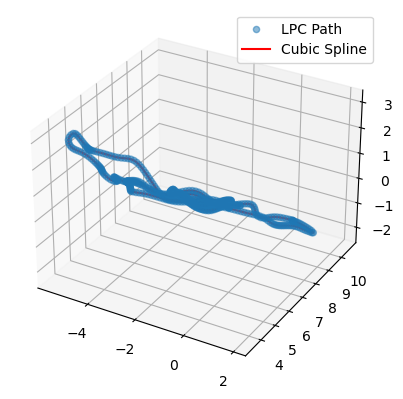

In [117]:
lpc.plot_cubic_spline_3d(0)

In [59]:
import numpy as np
import pandas as pd
from itertools import combinations

def calculate_within_dataset_colinearity(dataset_df):
    """
    Calculates colinearity within a single dataset by examining the covariance between each unique pair of perturbations.
    
    Steps:
    1. Identify unique perturbations.
    2. For each pair of perturbations, compute the average covariance across PCA_1, PCA_2, and PCA_3.
    3. Aggregate these pairwise covariances:
       - Compute the average of all pairwise covariances.
       - Compute the variance of these pairwise covariances.
    
    Parameters:
    - dataset_df (pd.DataFrame): DataFrame containing at least the columns:
        ['Perturbation', 'PCA_1', 'PCA_2', 'PCA_3']
      representing a single dataset (e.g., all, hld_aligned, etc.)
    
    Returns:
    - pd.DataFrame: A DataFrame with columns:
        ['average_pairwise_covariance', 'variance_of_pairwise_covariances']
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in dataset_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Get unique perturbations
    perturbations = dataset_df["Perturbation"].unique()
    
    pairwise_covariances = []
    
    # Iterate over unique pairs of perturbations
    for pert1, pert2 in combinations(perturbations, 2):
        # print(pert1, pert2)
        data_pert1 = dataset_df[dataset_df["Perturbation"] == pert1][pca_columns]
        data_pert2 = dataset_df[dataset_df["Perturbation"] == pert2][pca_columns]
        
        # Ensure both DataFrames have the same number of samples
        min_len = min(len(data_pert1), len(data_pert2))
        if min_len == 0:
            # Skip if no overlapping samples
            continue
        data_pert1 = data_pert1.iloc[:min_len].reset_index(drop=True)
        data_pert2 = data_pert2.iloc[:min_len].reset_index(drop=True)
        
        # Compute covariance for each PCA component and store it
        covariances = []
        for pca in pca_columns:
            cov_matrix = np.cov(data_pert1[pca], data_pert2[pca], bias=True)
            cov = cov_matrix[0, 1]  # Covariance between the two perturbations for this PCA component
            covariances.append(cov)

        
        
        # Average covariance across PCA components
        
        avg_cov = np.mean(covariances)
        pairwise_covariances.append(avg_cov)
        
        # print(avg_cov)
        # print(covariances)
    
    # Compute the average pairwise covariance
    if len(pairwise_covariances) == 0:
        # No pairs or insufficient data
        avg_pairwise_cov = np.nan
        var_pairwise_cov = np.nan
    else:
        avg_pairwise_cov = np.mean(pairwise_covariances)
        var_pairwise_cov = np.var(pairwise_covariances)
    
    results_df = pd.DataFrame([{
        "average_pairwise_covariance": avg_pairwise_cov,
        "variance_of_pairwise_covariances": var_pairwise_cov
    }])
    
    return results_df


# # Calculate within-dataset colinearity metrics
# splines_final_df = splines_final_df_71

# splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
# splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

# metrics_df = calculate_within_dataset_colinearity(splines_all)
# print("splines_all")
# print(metrics_df)

# metrics_df = calculate_within_dataset_colinearity(splines_hld_aligned)
# print("splines_hld_aligned")
# print(metrics_df)

In [ ]:
# Required Libraries
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

def calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index)
    - Initial Dispersion (average dispersion of the first n points)
    - Last Dispersion (average dispersion of the last n points)
    
    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - n (int): Number of initial and last points to consider for initial and last dispersion.
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n', 'dispersion_last_n'].
    """
    
    # Combine the two DataFrames
    combined_df = pd.concat([splines_all, splines_hld_aligned], ignore_index=True)
    
    points_list = []
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in combined_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique datasets
    datasets = combined_df["dataset"].unique()
    
    # Initialize list to store results
    results = []
    
    for dataset in datasets:
        # Filter data for the current dataset
        dataset_df = combined_df[combined_df["dataset"] == dataset]
        
        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())
        
        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []
        
        # Initialize lists to store initial and last dispersions
        initial_dispersions = []
        last_dispersions = []
        
        for pid in point_indices:
            # Filter data for the current point_index

            point_df = dataset_df[dataset_df["point_index"] == pid]
            points_list.append(point_df)

            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)
            
            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)
            
            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)
            
            # If within last n points, store for last dispersion
            if pid >= max(point_indices) - n + 1:
                last_dispersions.append(dispersion)
        
        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)
            
            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
            disp_coefficient *= len(point_indices) #this is to normalize it from 0 to 1
        
        # Calculate average initial dispersion
        dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
        if np.isnan(dispersion_first_n):
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")
        
        # Calculate average last dispersion
        dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
        if np.isnan(dispersion_last_n):
            print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")
        

        
        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n,
            "dispersion_last_n": dispersion_last_n
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

# Example Usage

# Calculate Dispersion Metrics
# Calculate within-dataset colinearity metrics
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]


dispersion_metrics_df = calculate_dispersion_metrics(splines_hld_aligned, splines_all, n=5)

print("Dispersion Metrics for Each Dataset:")
print(dispersion_metrics_df)

Dispersion Metrics for Each Dataset:
       Dataset  disp_coefficient  dispersion_first_n  dispersion_last_n
0          all          1.861074            0.114492           1.355500
1  hld_aligned          1.282790            0.237228           1.593353


In [ ]:
# Assuming you have the `splines_final` DataFrame loaded
fig = plot_trajectories_3d(splines_final_df_71)
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_71_test.html")

# # Assuming you have the `splines_final` DataFrame loaded
# fig = plot_trajectories_3d(splines_final_df_77)
# fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_77.html")

In [ ]:

# Combine the two DataFrames


points_list = []
# Ensure PCA columns are present
pca_columns = ["PCA_1", "PCA_2", "PCA_3"]


results = []

dataset = splines_all
for pid in point_indices:
    # Filter data for the current point_index

    point_df = dataset_df[dataset_df["point_index"] == pid]
    points_list.append(point_df)

    # Calculate dispersion: average Euclidean distance from centroid
    dispersion = compute_dispersion(point_df, pca_columns)
    
    # Append to lists
    dispersion_list.append(dispersion)
    point_index_list.append(pid)
    
    # If within first n points, store for initial dispersion
    if pid < n:
        initial_dispersions.append(dispersion)
    
    # If within last n points, store for last dispersion
    if pid >= max(point_indices) - n + 1:
        last_dispersions.append(dispersion)

# Check if there are enough points for regression
if len(point_index_list) < 2:
    print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
    disp_coefficient = np.nan
else:
    # Prepare data for linear regression
    X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
    y = np.array(dispersion_list)  # Shape: (num_points,)
    
    # Fit linear regression
    reg = LinearRegression().fit(X, y)
    disp_coefficient = reg.coef_[0]

# Calculate average initial dispersion
dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
if np.isnan(dispersion_first_n):
    print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")

# Calculate average last dispersion
dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
if np.isnan(dispersion_last_n):
    print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")


NameError: name 'point_indices' is not defined

In [ ]:
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [ ]:
splines_all[splines_all["point_index"]==499]

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
499,all,wnt-i,499,1.799041,1.613181,-0.445037
999,all,tgfb-i,499,-0.373282,-0.160782,1.733626
1499,all,wt,499,1.786313,1.869246,-0.190262
1999,all,lmx1b,499,-1.674569,1.274914,1.720163
2499,all,gdf3,499,1.728057,1.733506,-0.304950


In [ ]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

# pert_comparisons = ["wnt-i", "wt"]
pert_comparisons = [ "wt"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


# Dictionary to store spline points for each dataset and perturbation
# Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
splines_dict = {}

# Replace this with your actual class or method for fitting local principal curves

####                        ####
#### HERE WE FIT THE SPLINE ####
####                        ####    

for df_label, df in [("all", df_all), ("hld", df_hld)]:
 
    X = df[z_mu_biological_columns].values
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)

    perturbations = pert_comparisons

    # Map perturbations to colors
    if perturbations is None:
        perturbations = df['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


    # Prepare the color array
    df['color'] = df['phenotype'].map(color_discrete_map)


    df["PCA_1"] = pcs[:,0]
    df["PCA_2"] = pcs[:,1]
    df["PCA_3"] = pcs[:,2]

    for pert in pert_comparisons:
        print(f"Processing {pert} in {df_label} dataset...")


        pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


        avg_early_timepoint = pert_df[
            (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
            (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
        ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsampling logic
        if pert == "wt":
            pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
        else:
            pert_df_subset = pert_df.sample(frac=.1, random_state=42)
        
        print(f"Subset size: {len(pert_df_subset)}")

        pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


        # Fit the Local Principal Curve on the subset
        lpc = LocalPrincipalCurve(bandwidth=.5, max_iter=500, tol=1e-4, angle_penalty_exp=3)
        paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

        # Extract the first path (assuming one main path)
        spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

        # Store the spline points in the dictionary
        splines_dict[(df_label, pert)] = spline_points

rows = []

for (df_label, pert), spline_points in splines_dict.items():
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline_points):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": df_label,
            "Perturbation": pert,
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2]
        })

# Convert to DataFrame
splines_df = pd.DataFrame(rows)


####                               ####
#### HERE WE ALIGN AND MEASURE FIT ####
####                               ####  
scaffold_align_metrics = []
splines_dict_aligned = []

all_combined = []
hld_combined = []
hld_aligned_combined = []

for pert in pert_comparisons:
    all_points = extract_spline(splines_df, "all", pert)
    hld_points = extract_spline(splines_df, "hld", pert)
    
    # Resample so they have the same number of points
    min_len = min(len(all_points), len(hld_points))
    all_resampled = resample_spline(all_points, min_len)
    hld_resampled = resample_spline(hld_points, min_len)
    
    # Compute initial errors before alignment
    initial_rmse = rmse(all_resampled, hld_resampled)
    initial_l1 = mean_l1_error(all_resampled, hld_resampled)

    # Perform Kabsch alignment
    R, t = kabsch_alignment(all_resampled, hld_resampled)
    hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
    
    # Compute errors after alignment
    aligned_rmse = rmse(all_resampled, hld_aligned)
    aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
    
    # Print in the organized format (optional)
    print(f"Perturbation: {pert}")
    print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
    print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
    
    # Accumulate for scaffold comparison if desired
    all_combined.append(all_resampled)
    hld_combined.append(hld_resampled)
    hld_aligned_combined.append(hld_aligned)
    
    splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
    # Record metrics for this perturbation
    scaffold_align_metrics.append({
        'Perturbation': pert,
        'Initial_RMSE': initial_rmse,
        'Aligned_RMSE': aligned_rmse,
        'Initial_L1': initial_l1,
        'Aligned_L1': aligned_l1
    })


# Concatenate all perturbation data for scaffold metrics
all_combined = np.concatenate(all_combined, axis=0)
hld_combined = np.concatenate(hld_combined, axis=0)
hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

# Compute scaffold-level errors
scaffold_initial_rmse = rmse(all_combined, hld_combined)
scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

#apend this 
scaffold_align_metrics.append({
    'Perturbation': 'avg_pert',
    'Initial_RMSE': scaffold_initial_rmse,
    'Aligned_RMSE': scaffold_aligned_rmse,
    'Initial_L1': scaffold_initial_l1,
    'Aligned_L1': scaffold_aligned_l1
    })


print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


# Convert per-perturbation metrics to a DataFrame
scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

# Initialize a list to store rows


for  spline in splines_dict_aligned:
    # spline_points is an array of shape (num_points, 3)
    for i, point in enumerate(spline["spline"]):
        # point is [PCA_1, PCA_2, PCA_3]
        rows.append({
            "dataset": "hld_aligned",
            "Perturbation": spline["Perturbation"],
            "point_index": i,
            "PCA_1": point[0],
            "PCA_2": point[1],
            "PCA_3": point[2],
        })

# Convert to DataFrame
splines_final_df = pd.DataFrame(rows)



scaffold_align_metrics_df
splines_final_df

71
0.713932407655193


/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:32: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7168192.1.trapnell-login.q/ipykernel_2936537/2785807863.py:33: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]
1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "_pydevd_bundle.pydevd_constants.Null"}]

1[{"variableName": "ID_TO_MEANING", "type": "dictionary", "supportedEngines": ["pandas"], "isLocalVariable": true, "rawType": "builtins.dict"}, {"variableName": "NULL", "type": "unknown", "supportedEngine

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
0,all,wt,0,-1.736484,2.449214,0.216783
1,all,wt,1,-1.736484,2.449214,0.216783
2,all,wt,2,-1.736484,2.449214,0.216783
3,all,wt,3,-1.736484,2.449214,0.216783
4,all,wt,4,-1.736484,2.449214,0.216783
...,...,...,...,...,...,...
1495,hld_aligned,wt,495,1.996002,1.759814,-0.226461
1496,hld_aligned,wt,496,1.996706,1.779548,-0.226172
1497,hld_aligned,wt,497,1.994883,1.799125,-0.225818
1498,hld_aligned,wt,498,1.991752,1.818620,-0.225429


In [ ]:

#this one
def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    # Initialize list to store results
    results = []
    
    for pert in perturbations:
    # Filter data for the current perturbation
        
        # Sort the splines_hld_aligned dataframe by the 'point_index' column
        splines_hld_aligned_sorted = splines_hld_aligned.sort_values(by="point_index")
        splines_all_sorted = splines_all.sort_values(by="point_index")
        
        # Extract PCA data for the specified perturbation
        data_aligned = splines_hld_aligned_sorted[splines_hld_aligned_sorted["Perturbation"] == pert][pca_columns]
        data_all = splines_all_sorted[splines_all_sorted["Perturbation"] == pert][pca_columns]
        
        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)
        
        # Compute Cosine Similarity for each pair of 3D points
        cosine_similarities = []
        for idx in range(len(data_aligned)):
            vec_aligned = data_aligned.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            vec_all_current = data_all.iloc[idx].values.reshape(1, -1)  # Shape: (1, 3)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)
        
        # Calculate average cosine similarity (Colinearity) for this perturbation
        avg_cosine_sim = np.mean(cosine_similarities)
        
        # Calculate covariance between corresponding PCA components
        covariances = []
        for pca in pca_columns:
            cov = np.cov(
                data_aligned[pca],
                data_all[pca],
                bias=True
            )[0, 1]  # Covariance between aligned and all for this PCA component
            covariances.append(cov)
        avg_covariance = np.mean(covariances)
        
        # Append the results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

# import numpy as np
# import pandas as pd
# from sklearn.metrics.pairwise import cosine_similarity

# def calculate_within_dataset_colinearity_covariance(dataset_df):
#     """
#     Calculates colinearity (average cosine similarity) and covariance within a single dataset by examining
#     the covariance between each unique pair of perturbations based on their difference vectors.

#     Parameters:
#     - dataset_df (pd.DataFrame): DataFrame containing at least the columns:
#         ['Perturbation', 'point_index', 'PCA_1', 'PCA_2', 'PCA_3']
#       representing a single dataset (e.g., all, hld_aligned, etc.)

#     Returns:
#     - pd.DataFrame: A DataFrame with columns:
#         ['average_pairwise_covariance', 'variance_of_pairwise_covariances',
#          'average_pairwise_cosine_similarity', 'variance_of_pairwise_cosine_similarities']
#     """
#     pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    
#     # Validate presence of required PCA columns
#     for col in pca_columns:
#         if col not in dataset_df.columns:
#             raise ValueError(f"Missing required PCA column: {col}")

#     # Get unique perturbations
#     perturbations = dataset_df["Perturbation"].unique()
    
#     # Initialize lists to store pairwise covariances and cosine similarities
#     pairwise_covariances = []
#     pairwise_cosine_similarities = []
    
#     # Generate all unique perturbation pairs
#     for pert1, pert2 in combinations(perturbations, 2):
#         # Filter and sort data for each perturbation
#         data_pert1 = dataset_df[dataset_df["Perturbation"] == pert1].sort_values(by="point_index")
#         data_pert2 = dataset_df[dataset_df["Perturbation"] == pert2].sort_values(by="point_index")
        
#         # Reset index for proper alignment
#         data_pert1 = data_pert1.reset_index(drop=True)
#         data_pert2 = data_pert2.reset_index(drop=True)
        
#         # Ensure both perturbations have at least two points to form difference vectors
#         if len(data_pert1) < 2 or len(data_pert2) < 2:
#             print(f"Warning: Perturbations '{pert1}' and/or '{pert2}' have fewer than 2 points. Skipping this pair.")
#             continue
        
#         # Compute difference vectors for each perturbation
#         diffs_pert1 = data_pert1[pca_columns].diff().dropna().values  # Shape: (n-1, 3)
#         diffs_pert2 = data_pert2[pca_columns].diff().dropna().values  # Shape: (m-1, 3)
        
#         # Align the number of difference vectors by truncating to the minimum length
#         min_diff_len = min(len(diffs_pert1), len(diffs_pert2))
#         if min_diff_len == 0:
#             print(f"Warning: Perturbations '{pert1}' and/or '{pert2}' have no overlapping difference vectors. Skipping this pair.")
#             continue
#         diffs_pert1 = diffs_pert1[:min_diff_len]
#         diffs_pert2 = diffs_pert2[:min_diff_len]
        
#         # Compute cosine similarities for each pair of difference vectors
#         cosine_similarities = []
#         for i in range(min_diff_len):
#             vec1 = diffs_pert1[i].reshape(1, -1)  # Shape: (1, 3)
#             vec2 = diffs_pert2[i].reshape(1, -1)  # Shape: (1, 3)
#             sim = cosine_similarity(vec1, vec2)[0][0]
#             cosine_similarities.append(sim)
        
#         # Average cosine similarity for this perturbation pair
#         avg_cos_sim = np.mean(cosine_similarities) if len(cosine_similarities) > 0 else np.nan
#         pairwise_cosine_similarities.append(avg_cos_sim)
        
#         # Compute covariance between corresponding PCA components
#         covariances = []
#         for dim in pca_columns:
#             cov_matrix = np.cov(diffs_pert1[:, pca_columns.index(dim)], 
#                                 diffs_pert2[:, pca_columns.index(dim)], 
#                                 bias=True)
#             cov = cov_matrix[0, 1]  # Covariance between the two perturbations for this PCA component
#             covariances.append(cov)
        
#         # Average covariance across PCA components for this perturbation pair
#         avg_cov = np.mean(covariances) if len(covariances) > 0 else np.nan
#         pairwise_covariances.append(avg_cov)
    
#     # Compute aggregate metrics
#     if len(pairwise_covariances) == 0:
#         avg_pairwise_cov = np.nan
#         var_pairwise_cov = np.nan
#         avg_pairwise_cos_sim = np.nan
#         var_pairwise_cos_sim = np.nan
#         print("Warning: No valid perturbation pairs found for covariance and cosine similarity calculations.")
#     else:
#         avg_pairwise_cov = np.mean(pairwise_covariances)
#         var_pairwise_cov = np.var(pairwise_covariances)
#         avg_pairwise_cos_sim = np.mean(pairwise_cosine_similarities)
#         var_pairwise_cos_sim = np.var(pairwise_cosine_similarities)
    
#     # Create the results DataFrame
#     results_df = pd.DataFrame([{
#         "average_pairwise_covariance": avg_pairwise_cov,
#         "variance_of_pairwise_covariances": var_pairwise_cov,
#         "average_pairwise_cosine_similarity": avg_pairwise_cos_sim,
#         "variance_of_pairwise_cosine_similarities": var_pairwise_cos_sim
#     }])
    
#     return results_df

# Example usage (assuming splines_hld_aligned and splines_all are defined):
# results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)
# print(results_df)
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

# def calculate_colinearity_covariance(splines_hld_aligned, splines_all):
#     """
#     Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation,
#     based on the difference vectors (point[i+1] - point[i]) rather than the raw points.

#     Parameters:
#     - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
#     - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.

#     Returns:
#     - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
#     """
    
#     # Ensure PCA columns are present
#     pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
#     for col in pca_columns:
#         if col not in splines_hld_aligned.columns or col not in splines_all.columns:
#             raise ValueError(f"Missing required PCA column: {col}")
    
#     # Get unique perturbations present in both datasets
#     perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
#     perturbations_all = set(splines_all["Perturbation"].unique())
#     perturbations = perturbations_aligned.intersection(perturbations_all)
    
#     # Initialize list to store results
#     results = []
    
#     for pert in perturbations:
#         # Sort and filter data for this perturbation
#         splines_hld_aligned_sorted = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values(by="point_index")
#         splines_all_sorted = splines_all[splines_all["Perturbation"] == pert].sort_values(by="point_index")

#         data_aligned = splines_hld_aligned_sorted[pca_columns].reset_index(drop=True)
#         data_all = splines_all_sorted[pca_columns].reset_index(drop=True)

#         # Ensure both dataframes have the same number of samples
#         if len(data_aligned) != len(data_all):
#             print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
#             min_len = min(len(data_aligned), len(data_all))
#             data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
#             data_all = data_all.iloc[:min_len].reset_index(drop=True)

#         # If fewer than 2 points, we cannot form difference vectors
#         if len(data_aligned) < 2:
#             print(f"Warning: Perturbation '{pert}' has fewer than 2 points. Cannot compute difference vectors. Skipping.")
#             results.append({
#                 "Perturbation": pert,
#                 "Colinearity": np.nan,
#                 "Covariance": np.nan
#             })
#             continue

#         # Compute difference vectors for aligned and all data
#         aligned_diffs = data_aligned.diff().dropna().values  # shape: (n-1, 3)
#         all_diffs = data_all.diff().dropna().values  # shape: (n-1, 3)

#         # Ensure same number of difference vectors
#         min_diff_len = min(len(aligned_diffs), len(all_diffs))
#         aligned_diffs = aligned_diffs[:min_diff_len]
#         all_diffs = all_diffs[:min_diff_len]

#         # Compute cosine similarity for each difference vector pair
#         cosine_similarities = []
#         for i in range(min_diff_len):
#             vec_aligned = aligned_diffs[i].reshape(1, -1)
#             vec_all_current = all_diffs[i].reshape(1, -1)
#             sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
#             cosine_similarities.append(sim)

#         # Calculate average cosine similarity (Colinearity) for this perturbation
#         avg_cosine_sim = np.mean(cosine_similarities) if len(cosine_similarities) > 0 else np.nan

#         # Calculate covariance between corresponding PCA components on the difference vectors
#         # Convert difference arrays back to DataFrame for convenience
#         aligned_diff_df = pd.DataFrame(aligned_diffs, columns=pca_columns)
#         all_diff_df = pd.DataFrame(all_diffs, columns=pca_columns)

#         covariances = []
#         for pca in pca_columns:
#             cov = np.cov(aligned_diff_df[pca], all_diff_df[pca], bias=True)[0, 1]
#             covariances.append(cov)
#         avg_covariance = np.mean(covariances) if len(covariances) > 0 else np.nan
        
#         # Append the results
#         results.append({
#             "Perturbation": pert,
#             "Colinearity": avg_cosine_sim,
#             "Covariance": avg_covariance
#         })
    
#     # Convert results to DataFrame
#     results_df = pd.DataFrame(results)
    
#     return results_df

# Example usage (assuming splines_hld_aligned and splines_all are defined):
# results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)
# print(results_df)
results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all)
results_df

,Perturbation,Colinearity,Covariance
0,lmx1b,0.389172,0.700225
1,gdf3,0.625412,0.694381
2,tgfb-i,0.724186,0.673256
3,wnt-i,0.839287,0.516499
4,wt,0.408344,0.812203


In [50]:
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity



def calculate_colinearity_covariance(splines_hld_aligned, splines_all, k=10):
    """
    Calculates colinearity (average cosine similarity) and covariance between PCA trajectories for each perturbation,
    by dividing the trajectory into k segments, computing an average (normalized) direction vector for each segment, 
    and then comparing these segment-level direction vectors between aligned and all datasets.

    Parameters:
    - splines_hld_aligned (pd.DataFrame): DataFrame containing aligned PCA trajectories.
    - splines_all (pd.DataFrame): DataFrame containing all PCA trajectories.
    - k (int): Number of segments to divide the trajectory into (default=10).

    Returns:
    - pd.DataFrame: DataFrame with columns ['Perturbation', 'Colinearity', 'Covariance'].
    """
    
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")
    
    # Get unique perturbations present in both datasets
    perturbations_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perturbations_all = set(splines_all["Perturbation"].unique())
    perturbations = perturbations_aligned.intersection(perturbations_all)
    
    results = []
    
    for pert in perturbations:
        # Sort and filter data for this perturbation
        splines_hld_aligned_sorted = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values(by="point_index")
        splines_all_sorted = splines_all[splines_all["Perturbation"] == pert].sort_values(by="point_index")

        data_aligned = splines_hld_aligned_sorted[pca_columns].reset_index(drop=True)
        data_all = splines_all_sorted[pca_columns].reset_index(drop=True)

        # Ensure both dataframes have the same number of samples
        if len(data_aligned) != len(data_all):
            print(f"Warning: Perturbation '{pert}' has different number of samples in aligned ({len(data_aligned)}) and all ({len(data_all)}) data.")
            min_len = min(len(data_aligned), len(data_all))
            data_aligned = data_aligned.iloc[:min_len].reset_index(drop=True)
            data_all = data_all.iloc[:min_len].reset_index(drop=True)

        # Need at least 2 points to form direction vectors
        if len(data_aligned) < 2:
            print(f"Warning: Perturbation '{pert}' has fewer than 2 points. Cannot compute directions. Skipping.")
            results.append({
                "Perturbation": pert,
                "Colinearity": np.nan,
                "Covariance": np.nan
            })
            continue

        # Compute difference vectors (N-1 vectors if N is number of points)
        aligned_diffs = data_aligned.diff().dropna().values  # shape: (n-1, 3)
        all_diffs = data_all.diff().dropna().values  # shape: (n-1, 3)

        # Ensure same length of difference vectors
        min_diff_len = min(len(aligned_diffs), len(all_diffs))
        aligned_diffs = aligned_diffs[:min_diff_len]
        all_diffs = all_diffs[:min_diff_len]

        # If not enough difference vectors to form k segments
        if min_diff_len < k:
            # If we have fewer diffs than segments, we'll just form as many segments as possible 
            # (Some segments might be empty if we don't handle carefully)
            # But for simplicity, if min_diff_len < k, segments will produce empty sets for some segments.
            # We can warn and skip to avoid odd behavior.
            print(f"Warning: Perturbation '{pert}' has fewer difference vectors ({min_diff_len}) than segments ({k}). Skipping.")
            results.append({
                "Perturbation": pert,
                "Colinearity": np.nan,
                "Covariance": np.nan
            })
            continue

        # Divide difference vectors into k segments
        # We'll use integer boundaries. If min_diff_len not divisible by k, the last segment may have slightly different size.
        segment_indices = np.linspace(0, min_diff_len, k+1, dtype=int)

        aligned_segment_vectors = []
        all_segment_vectors = []

        for i in range(k):
            start_idx = segment_indices[i]
            end_idx = segment_indices[i+1]
            # Extract the diffs in this segment
            seg_aligned = aligned_diffs[start_idx:end_idx]
            seg_all = all_diffs[start_idx:end_idx]

            if len(seg_aligned) == 0 or len(seg_all) == 0:
                # If empty segment, append zeros (or skip)
                aligned_segment_vectors.append(np.array([np.nan, np.nan, np.nan]))
                all_segment_vectors.append(np.array([np.nan, np.nan, np.nan]))
                continue

            # Compute average direction for each segment
            avg_aligned = np.mean(seg_aligned, axis=0)
            avg_all = np.mean(seg_all, axis=0)

            # Normalize vectors
            norm_aligned = np.linalg.norm(avg_aligned)
            norm_all = np.linalg.norm(avg_all)

            if norm_aligned == 0:
                avg_aligned = np.array([0,0,0])
            else:
                avg_aligned = avg_aligned / norm_aligned

            if norm_all == 0:
                avg_all = np.array([0,0,0])
            else:
                avg_all = avg_all / norm_all

            aligned_segment_vectors.append(avg_aligned)
            all_segment_vectors.append(avg_all)

        aligned_segment_vectors = np.array(aligned_segment_vectors)
        all_segment_vectors = np.array(all_segment_vectors)

        # Remove any segments that contain NaNs (due to empty segment)
        valid_mask = ~np.isnan(aligned_segment_vectors).any(axis=1) & ~np.isnan(all_segment_vectors).any(axis=1)
        aligned_segment_vectors = aligned_segment_vectors[valid_mask]
        all_segment_vectors = all_segment_vectors[valid_mask]

        if len(aligned_segment_vectors) == 0:
            print(f"Warning: Perturbation '{pert}' resulted in no valid segment vectors after filtering. Skipping.")
            results.append({
                "Perturbation": pert,
                "Colinearity": np.nan,
                "Covariance": np.nan
            })
            continue

        # Compute cosine similarity for each segment pair
        cosine_similarities = []
        for i in range(len(aligned_segment_vectors)):
            vec_aligned = aligned_segment_vectors[i].reshape(1, -1)
            vec_all_current = all_segment_vectors[i].reshape(1, -1)
            sim = cosine_similarity(vec_aligned, vec_all_current)[0][0]
            cosine_similarities.append(sim)

        # Average cosine similarity
        avg_cosine_sim = np.mean(cosine_similarities) if len(cosine_similarities) > 0 else np.nan

        # Compute covariance dimension-wise across segments
        # aligned_segment_vectors and all_segment_vectors are Nx3
        # We'll treat each segment vector as a sample, and compute covariance dimension-wise.
        covariances = []
        for dim_idx, pca in enumerate(pca_columns):
            # Extract dimension data
            aligned_dim_data = aligned_segment_vectors[:, dim_idx]
            all_dim_data = all_segment_vectors[:, dim_idx]

            # Compute covariance
            if len(aligned_dim_data) > 1:
                cov = np.cov(aligned_dim_data, all_dim_data, bias=True)[0, 1]
            else:
                # If we only have one segment, covariance is not defined. Set to NaN.
                cov = np.nan
            covariances.append(cov)

        avg_covariance = np.nanmean(covariances) if len(covariances) > 0 else np.nan

        # Append results
        results.append({
            "Perturbation": pert,
            "Colinearity": avg_cosine_sim,
            "Covariance": avg_covariance
        })

    return pd.DataFrame(results)


    
# Compute segmented direction vectors
results_df = calculate_colinearity_covariance(splines_hld_aligned, splines_all, k=10)
print(results_df)

  Perturbation  Colinearity  Covariance
0        lmx1b     0.088875   -0.002164
1         gdf3     0.117205    0.015416
2       tgfb-i     0.186421    0.038999
3        wnt-i     0.140426    0.012548
4           wt    -0.046425   -0.016243


In [ ]:
#EXAMPLE
print("Model 71 (most linear and stable)")
# splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

Model 71 (most linear and stable)


In [36]:
pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
print("start")
df = splines_all[splines_all["point_index"]==0] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())
print("\n")

print("end")
df = splines_all[splines_all["point_index"]==499] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())


start
     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
499      all        wnt-i            0  1.799041  1.613181 -0.445037
999      all       tgfb-i            0  1.848949  1.627183 -0.369211
1499     all           wt            0  1.786313  1.869246 -0.190262
1999     all        lmx1b            0  1.817386  1.704213 -0.308498
2499     all         gdf3            0  1.728057  1.733506 -0.304950
[ 1.79594902  1.70946558 -0.32359152]
[0.15501396 0.10798393 0.20832525 0.02673841 0.07439595]
0.11449150025259539


end
     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
0        all        wnt-i          499  0.512206 -0.449847  1.558961
500      all       tgfb-i          499 -0.373282 -0.160782  1.733626
1000     all           wt          499 -1.736484  2.449214  0.216783
1500     all        lmx1b          499 -1.674569  1.274914  1.720163
2000     all         gdf3          499 -0.859779  0.222505  1.831343
[-0.82638183  0.66720073  1.41217515]
[1.7496

In [37]:
pca_columns = ["PCA_1", "PCA_2", "PCA_3"]

print("start")
df = splines_hld_aligned[splines_hld_aligned["point_index"]==0] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())

print("\n")
print("end")
df = splines_hld_aligned[splines_hld_aligned["point_index"]==499] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())

start
          dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
5000  hld_aligned        wnt-i            0  2.159240  1.773865 -0.443305
5500  hld_aligned       tgfb-i            0  2.111788  1.655099 -0.618078
6000  hld_aligned           wt            0  1.988497  1.838092 -0.225003
6500  hld_aligned        lmx1b            0  1.954562  1.739461 -0.203282
7000  hld_aligned         gdf3            0  1.810482  2.016731 -0.079626
[ 2.00491363  1.80464947 -0.31385921]
[0.20376586 0.35543922 0.09634968 0.13788452 0.37100876]
0.23288960828065633


end
          dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
5499  hld_aligned        wnt-i          499  0.107504 -0.352820  1.499300
5999  hld_aligned       tgfb-i          499 -0.608231 -0.158507  1.989983
6499  hld_aligned           wt          499 -1.356716  2.731663  0.532165
6999  hld_aligned        lmx1b          499 -1.510830  2.362368 -0.042723
7499  hld_aligned         gdf3          499 -1.042603  0.00

In [246]:
#EXAMPLE
print("Model 71 (most linear and stable)")
splines_final_df = splines_final_df_71

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

Model 71 (most linear and stable)


In [256]:
# Assuming you have the `splines_final` DataFrame loaded
fig = plot_trajectories_3d(splines_final_df)
fig.write_html("/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_71_test2.html")

In [18]:
splines_final_df = splines_final_dict[71]

splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

In [21]:
pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
df = splines_all[splines_all["point_index"]==0] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())
print("\n")
df = splines_all[splines_all["point_index"]==499] 
print(df)
centroid = df[pca_columns].mean().values
print(centroid)
distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
print(distances)
print(distances.mean())

     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
499      all        wnt-i            0  1.799041  1.613181 -0.445037
999      all       tgfb-i            0  1.848949  1.627183 -0.369211
1499     all           wt            0  1.786313  1.869246 -0.190262
1999     all        lmx1b            0  1.817386  1.704213 -0.308498
2499     all         gdf3            0  1.728057  1.733506 -0.304950
[ 1.79594902  1.70946558 -0.32359152]
[0.15501396 0.10798393 0.20832525 0.02673841 0.07439595]
0.11449150025259539


     dataset Perturbation  point_index     PCA_1     PCA_2     PCA_3
0        all        wnt-i          499  0.512206 -0.449847  1.558961
500      all       tgfb-i          499 -0.373282 -0.160782  1.733626
1000     all           wt          499 -1.736484  2.449214  0.216783
1500     all        lmx1b          499 -1.674569  1.274914  1.720163
2000     all         gdf3          499 -0.859779  0.222505  1.831343
[-0.82638183  0.66720073  1.41217515]
[1.74961681 0.997

In [217]:
df = splines_hld_aligned[splines_hld_aligned["point_index"]==0]

,dataset,Perturbation,point_index,PCA_1,PCA_2,PCA_3
5000,hld_aligned,wnt-i,0,0.107504,-0.352820,1.499300
5500,hld_aligned,tgfb-i,0,1.852333,1.490546,-0.553248
6000,hld_aligned,wt,0,-1.356716,2.731663,0.532165
6500,hld_aligned,lmx1b,0,1.741836,1.535228,0.942026
7000,hld_aligned,gdf3,0,-1.575292,-0.026114,1.797284


In [97]:
splines_final_df = splines_final_dict[78]
splines_final_df= splines_final_df[splines_final_df["Perturbation"]=="wt"]

In [ ]:
splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"][splines_final_df["dataset"]=="all"]

/tmp/7340897.1.trapnell-login.q/ipykernel_1084255/3973938691.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



71
0.713932407655193


/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/1418160436.py:34: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/7583594.1.trapnell-login.q/ipykernel_1507738/1418160436.py:35: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.



PCA plot model_idx 71: F1 score 0.71,mweight 25, timeonly 1
Processing wt in all dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.76878228  1.7100162  -0.174527  ]


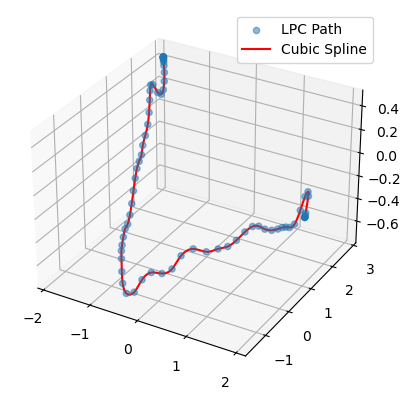

Processing wt in hld dataset...
Subset size: 2437
Starting point not in dataset. Using closest point: [ 1.96912577  1.7797467  -0.14410615]


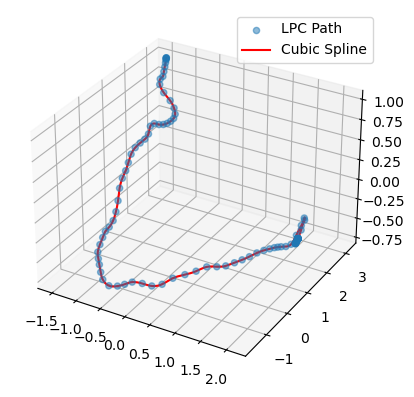

Perturbation: wt
  Initial RMSE: 0.2544, Aligned RMSE: 0.3709
  Initial L1:   0.5606, Aligned L1:   0.9541

Overall Scaffold (Individual Kabsch per Perturbation):
  Initial RMSE: 0.2544, Aligned RMSE: 0.3709
  Initial L1:   0.5606, Aligned L1:   0.9541


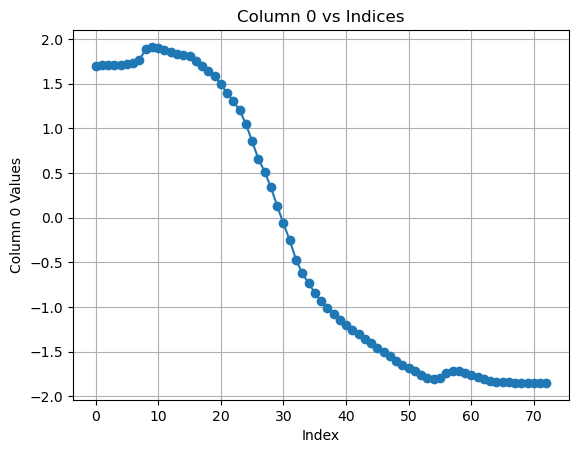

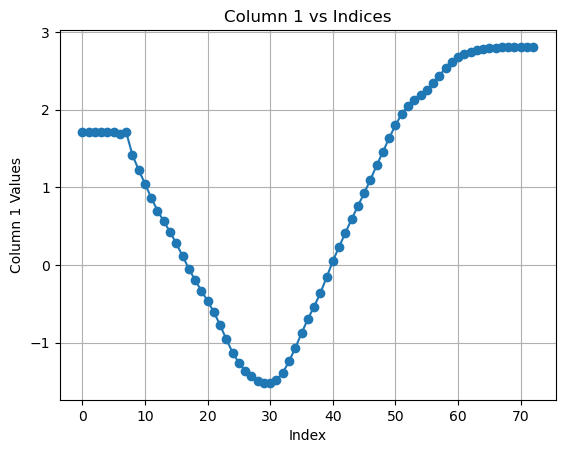

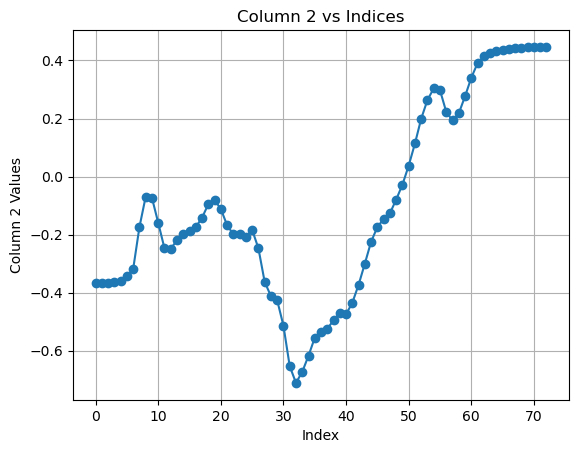

In [24]:
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import os
import plotly.express as px

pert_comparisons = [ "wt"]
# pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]

color_map = {
    "wnt-i": "red",
    "tgfb-i": "green",
    "wt": "blue",
    "lmx1b": "orange",
    "gdf3": "purple"
}

lpc_dict = {}
####                        ####
#### HERE WE LOAD  DATA     ####
####                        ####    
splines_final_dict = {}
for model_index in [71]:
    print(model_index)
    path_all = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_nohld"].iloc[0]
    path_hld = merged_df_avg[merged_df_avg["model_index"]==model_index]["embryo_df_path_hld"].iloc[0]

    print(merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0])

    score    = merged_df_avg[merged_df_avg["model_index"]==model_index]["F1_score_all"].iloc[0]
    mweight  = merged_df_avg[merged_df_avg["model_index"]==model_index]["metric_weight"].iloc[0]
    timeonly = merged_df_avg[merged_df_avg["model_index"]==model_index]["time_only_flag"].iloc[0]
 
    df_all = pd.read_csv(path_all)
    df_hld = pd.read_csv(path_hld)

    title = f"PCA plot model_idx {model_index}: F1 score {score:.2f},mweight {mweight}, timeonly {timeonly}"

    print(title)

    # Define the comparisons (Multiclass) and obtain coloumns for data

    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]


    # Dictionary to store spline points for each dataset and perturbation
    # Key: (dataset_label, perturbation), Value: array of spline points shape (num_spline_points, 3)
    splines_dict = {}


    # Replace this with your actual class or method for fitting local principal curves

    ####                        ####
    #### HERE WE FIT THE SPLINE ####
    ####                        ####    

    for df_label, df in [("all", df_all), ("hld", df_hld)]:
    
        X = df[z_mu_biological_columns].values
        pca = PCA(n_components=3)
        pcs = pca.fit_transform(X)

        perturbations = pert_comparisons

        # Map perturbations to colors
        if perturbations is None:
            perturbations = df['phenotype'].unique()
        color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}


        # Prepare the color array
        df['color'] = df['phenotype'].map(color_discrete_map)


        df["PCA_1"] = pcs[:,0]
        df["PCA_2"] = pcs[:,1]
        df["PCA_3"] = pcs[:,2]

        for pert in pert_comparisons:
            print(f"Processing {pert} in {df_label} dataset...")


            pert_df = df[df["phenotype"] == pert].reset_index(drop=True)


            avg_early_timepoint = pert_df[
                (pert_df["predicted_stage_hpf"] >= pert_df["predicted_stage_hpf"].min()) &
                (pert_df["predicted_stage_hpf"] < pert_df["predicted_stage_hpf"].min() + 1)
            ][["PCA_1", "PCA_2", "PCA_3"]].mean().values

            # Downsampling logic
            if pert == "wt":
                pert_df_subset = pert_df.sample(frac=0.05, random_state=42)
            else:
                pert_df_subset = pert_df.sample(frac=.1, random_state=42)
            
            print(f"Subset size: {len(pert_df_subset)}")

            pert_3d_subset = pert_df_subset[["PCA_1", "PCA_2", "PCA_3"]].values


            # Fit the Local Principal Curve on the subset
            lpc = LocalPrincipalCurve(bandwidth=.2, max_iter=500, tol=1e-3, angle_penalty_exp=2)
            paths = lpc.fit(pert_3d_subset, start_points=[avg_early_timepoint])

    

            # Extract the first path (assuming one main path)
            spline_points = lpc.cubic_splines[0]  # shape: (num_points, 3)

            # Store the spline points in the dictionary
            splines_dict[(df_label, pert)] = spline_points

            lpc_dict[(df_label, pert)] =  lpc

            lpc.plot_cubic_spline_3d(0)

    rows = []

    for (df_label, pert), spline_points in splines_dict.items():
        # spline_points is an array of shape (num_points, 3)
        for i, point in enumerate(spline_points[::-1], start=1):
            # point is [PCA_1, PCA_2, PCA_3]
            num_points = len(spline_points)
            rows.append({
                "dataset": df_label,
                "Perturbation": pert,
                "point_index":  num_points - i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2]
            })

    # Convert to DataFrame
    splines_df = pd.DataFrame(rows)


    ####                               ####
    #### HERE WE ALIGN AND MEASURE FIT ####
    ####                               ####  
    scaffold_align_metrics = []
    splines_dict_aligned = []

    all_combined = []
    hld_combined = []
    hld_aligned_combined = []

    for pert in pert_comparisons:
        all_points = extract_spline(splines_df, "all", pert)
        hld_points = extract_spline(splines_df, "hld", pert)
        
        # Resample so they have the same number of points
        min_len = min(len(all_points), len(hld_points))
        all_resampled = resample_spline(all_points, min_len)
        hld_resampled = resample_spline(hld_points, min_len)
        
        # Compute initial errors before alignment
        initial_rmse = rmse(all_resampled, hld_resampled)
        initial_l1 = mean_l1_error(all_resampled, hld_resampled)

        # Perform Kabsch alignment
        R, t = kabsch_alignment(all_resampled, hld_resampled)
        hld_aligned = (hld_resampled @ R.T) + t  # This is the aligned one we want.
        
        # Compute errors after alignment
        aligned_rmse = rmse(all_resampled, hld_aligned)
        aligned_l1 = mean_l1_error(all_resampled, hld_aligned)
        
        # Print in the organized format (optional)
        print(f"Perturbation: {pert}")
        print(f"  Initial RMSE: {initial_rmse:.4f}, Aligned RMSE: {aligned_rmse:.4f}")
        print(f"  Initial L1:   {initial_l1:.4f}, Aligned L1:   {aligned_l1:.4f}")
        
        # Accumulate for scaffold comparison if desired
        all_combined.append(all_resampled)
        hld_combined.append(hld_resampled)
        hld_aligned_combined.append(hld_aligned)
        
        splines_dict_aligned.append({"Perturbation":pert, "spline":hld_aligned})
        # Record metrics for this perturbation
        scaffold_align_metrics.append({
            'Perturbation': pert,
            'Initial_RMSE': initial_rmse,
            'Aligned_RMSE': aligned_rmse,
            'Initial_L1': initial_l1,
            'Aligned_L1': aligned_l1
        })


    # Concatenate all perturbation data for scaffold metrics
    all_combined = np.concatenate(all_combined, axis=0)
    hld_combined = np.concatenate(hld_combined, axis=0)
    hld_aligned_combined = np.concatenate(hld_aligned_combined, axis=0)

    # Compute scaffold-level errors
    scaffold_initial_rmse = rmse(all_combined, hld_combined)
    scaffold_aligned_rmse = rmse(all_combined, hld_aligned_combined)
    scaffold_initial_l1 = mean_l1_error(all_combined, hld_combined)
    scaffold_aligned_l1 = mean_l1_error(all_combined, hld_aligned_combined)

    #apend this 
    scaffold_align_metrics.append({
        'Perturbation': 'avg_pert',
        'Initial_RMSE': scaffold_initial_rmse,
        'Aligned_RMSE': scaffold_aligned_rmse,
        'Initial_L1': scaffold_initial_l1,
        'Aligned_L1': scaffold_aligned_l1
        })


    print("\nOverall Scaffold (Individual Kabsch per Perturbation):")
    print(f"  Initial RMSE: {scaffold_initial_rmse:.4f}, Aligned RMSE: {scaffold_aligned_rmse:.4f}")
    print(f"  Initial L1:   {scaffold_initial_l1:.4f}, Aligned L1:   {scaffold_aligned_l1:.4f}")


    # Convert per-perturbation metrics to a DataFrame
    scaffold_align_metrics_df = pd.DataFrame(scaffold_align_metrics)

    # Initialize a list to store rows


    for  spline in splines_dict_aligned:
        # spline_points is an array of shape (num_points, 3)
        for i, point in enumerate(spline["spline"]):
            # point is [PCA_1, PCA_2, PCA_3]
            rows.append({
                "dataset": "hld_aligned",
                "Perturbation": spline["Perturbation"],
                "point_index": i,
                "PCA_1": point[0],
                "PCA_2": point[1],
                "PCA_3": point[2],
            })

    # Convert to DataFrame
    splines_final_df = pd.DataFrame(rows)



    scaffold_align_metrics_df
    splines_final_df

    splines_final_dict[model_index] = splines_final_df
    
import matplotlib.pyplot as plt

# Assuming `data` is your array, replace this with your actual data source
# For example: data = lpc_dict[('all', 'wt')].paths[0][0:20]
data = lpc_dict[('all', 'wt')].paths[0]

# Plotting each column over its indices
for i in range(data.shape[1]):  # Loop over columns
    plt.figure()
    plt.plot(data[:, i], marker='o')
    plt.title(f"Column {i} vs Indices")
    plt.xlabel("Index")
    plt.ylabel(f"Column {i} Values")
    plt.grid(True)
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming `data` is your array, replace this with your actual data source
# For example: data = lpc_dict[('all', 'wt')].paths[0][0:20]
data = lpc_dict[('all', 'wt')].paths[0]

# Plotting each column over its indices
for i in range(data.shape[1]):  # Loop over columns
    plt.figure()
    plt.plot(data[:, i], marker='o')
    plt.title(f"Column {i} vs Indices")
    plt.xlabel("Index")
    plt.ylabel(f"Column {i} Values")
    plt.grid(True)
    plt.show()

NameError: name 'lpc_dict' is not defined

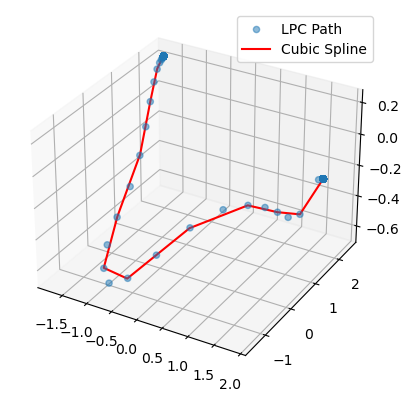

In [121]:
lpc_dict[('all', 'wt')].plot_cubic_spline_3d(0)

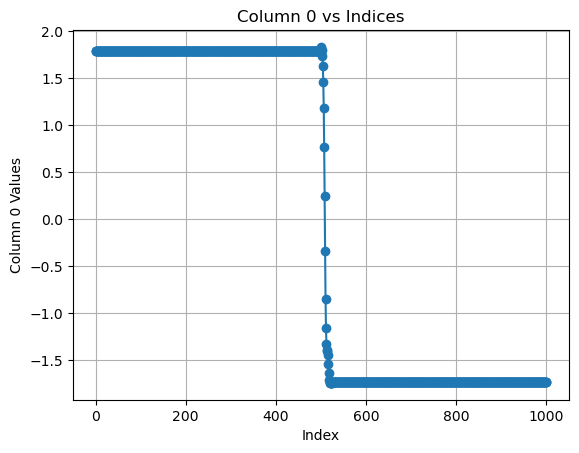

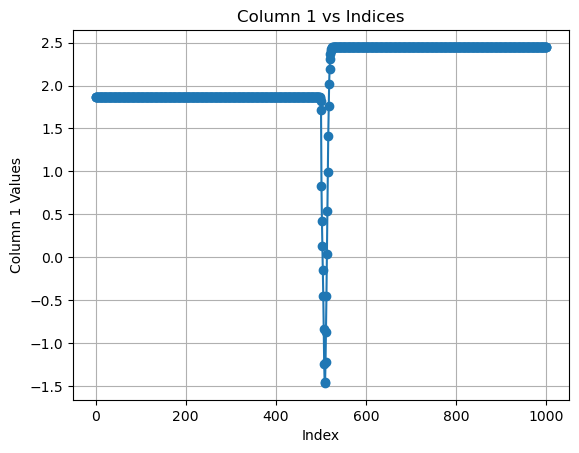

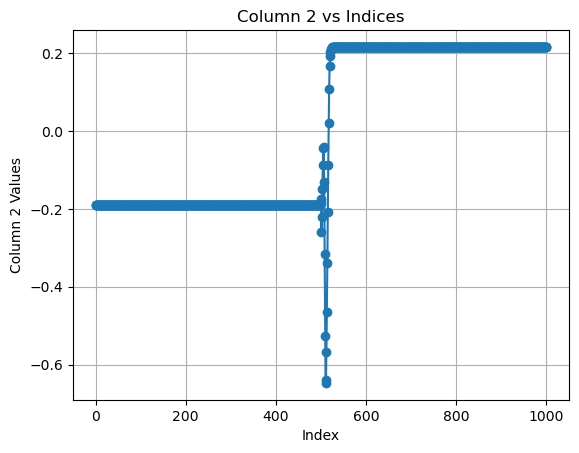

In [115]:
import matplotlib.pyplot as plt

# Assuming `data` is your array, replace this with your actual data source
# For example: data = lpc_dict[('all', 'wt')].paths[0][0:20]
data = lpc_dict[('all', 'wt')].paths[0]

# Plotting each column over its indices
for i in range(data.shape[1]):  # Loop over columns
    plt.figure()
    plt.plot(data[:, i], marker='o')
    plt.title(f"Column {i} vs Indices")
    plt.xlabel("Index")
    plt.ylabel(f"Column {i} Values")
    plt.grid(True)
    plt.show()

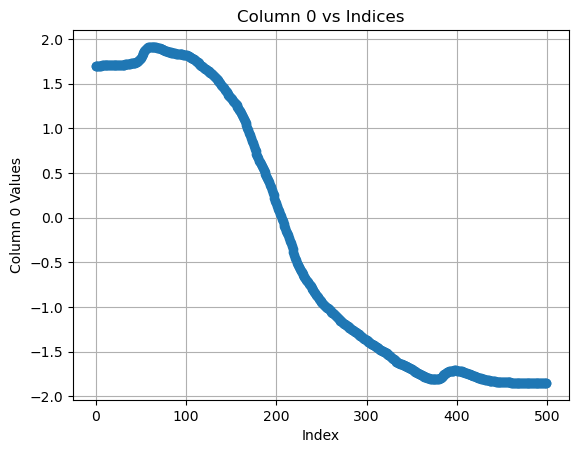

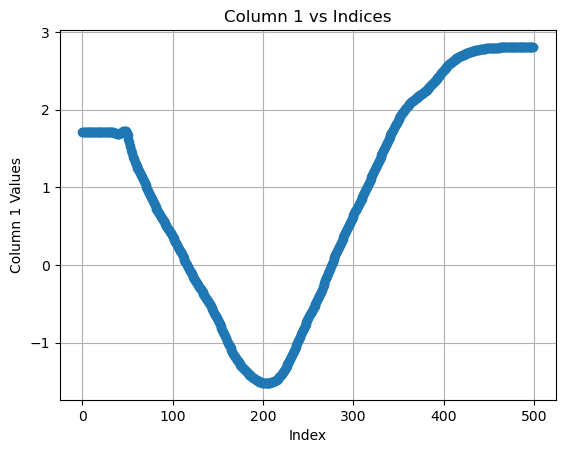

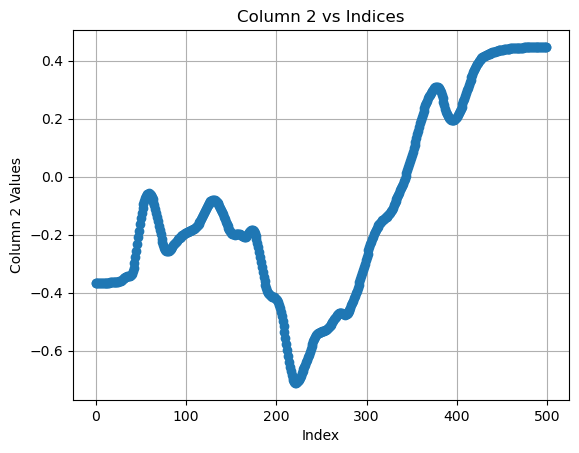

In [88]:
import matplotlib.pyplot as plt

# Assuming `data` is your array, replace this with your actual data source
# For example: data = lpc_dict[('all', 'wt')].paths[0][0:20]
data = lpc_dict[('all', 'wt')].cubic_splines[0]

# Plotting each column over its indices
for i in range(data.shape[1]):  # Loop over columns
    plt.figure()
    plt.plot(data[:, i], marker='o')
    plt.title(f"Column {i} vs Indices")
    plt.xlabel("Index")
    plt.ylabel(f"Column {i} Values")
    plt.grid(True)
    plt.show()

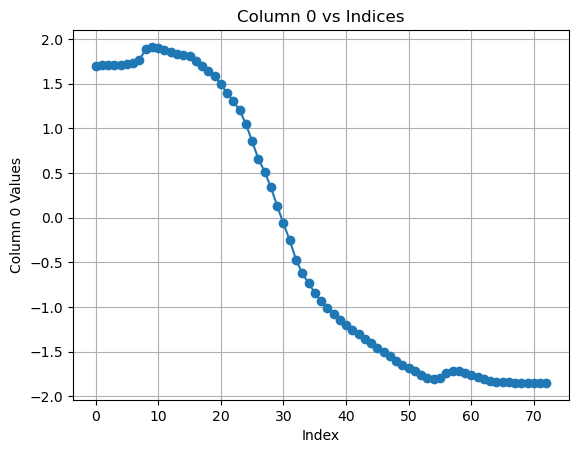

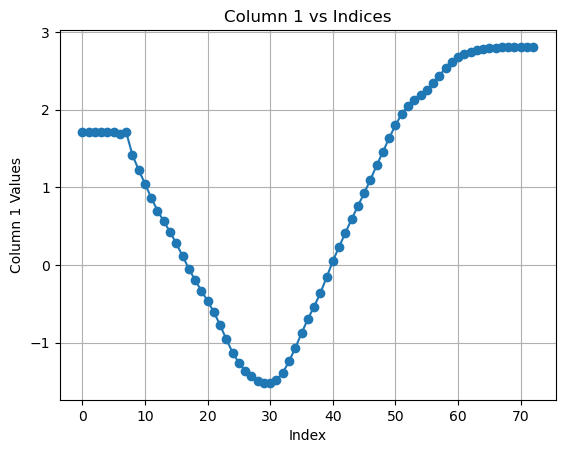

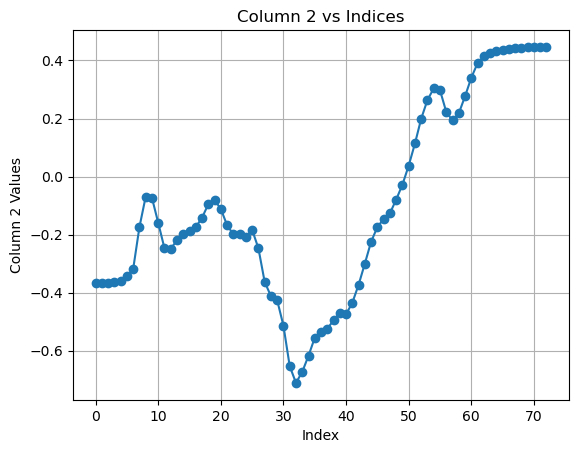

In [143]:
import matplotlib.pyplot as plt

# Assuming `data` is your array, replace this with your actual data source
# For example: data = lpc_dict[('all', 'wt')].paths[0][0:20]
data = lpc_dict[('all', 'wt')].paths[0]

# Plotting each column over its indices
for i in range(data.shape[1]):  # Loop over columns
    plt.figure()
    plt.plot(data[:, i], marker='o')
    plt.title(f"Column {i} vs Indices")
    plt.xlabel("Index")
    plt.ylabel(f"Column {i} Values")
    plt.grid(True)
    plt.show()

In [148]:
np.linalg.norm(lpc_dict[('all', 'wt')].cubic_splines[0][0] - lpc_dict[('all', 'wt')].cubic_splines[0][499])


3.8038785461276166

In [183]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def _segment_direction_metrics(data_a, data_b, k=10):
    """
    Compute SegmentColinearity and SegmentCovariance for two given sets of points `data_a` and `data_b`.
    This is a helper function that encapsulates the logic used in the across and within computations.
    Both data_a and data_b are np.ndarray of shape (n, 3).
    
    If there aren't enough points for k segments, returns (np.nan, np.nan).
    """
    min_len = min(len(data_a), len(data_b))
    data_a = data_a[:min_len]
    data_b = data_b[:min_len]

    if min_len < k + 1 or min_len == 0:
        return (np.nan, np.nan)

    # Define segments using data_b
    segment_indices = np.linspace(0, min_len - 1, k + 1, dtype=int)

    aligned_segment_vecs = []
    all_segment_vecs = []

    for i in range(k):
        start_idx = segment_indices[i]
        end_idx = segment_indices[i + 1]

        start_b = data_b[start_idx]
        end_b = data_b[end_idx]

        # Find closest points in data_a to start_b and end_b
        start_dists = np.linalg.norm(data_a - start_b, axis=1)
        closest_start_idx = np.argmin(start_dists)
        closest_start_a = data_a[closest_start_idx]

        end_dists = np.linalg.norm(data_a - end_b, axis=1)
        closest_end_idx = np.argmin(end_dists)
        closest_end_a = data_a[closest_end_idx]

        # Construct vectors
        vec_a = closest_end_a - closest_start_a
        vec_b = end_b - start_b

        # Normalize
        norm_a = np.linalg.norm(vec_a)
        norm_b = np.linalg.norm(vec_b)
        if norm_a > 0:
            vec_a = vec_a / norm_a
        else:
            vec_a = np.zeros(3)
        if norm_b > 0:
            vec_b = vec_b / norm_b
        else:
            vec_b = np.zeros(3)

        aligned_segment_vecs.append(vec_a)
        all_segment_vecs.append(vec_b)

    aligned_segment_vecs = np.array(aligned_segment_vecs)
    all_segment_vecs = np.array(all_segment_vecs)

    # Cosine similarities
    cos_sims = []
    for i in range(len(aligned_segment_vecs)):
        va = aligned_segment_vecs[i].reshape(1, -1)
        vb = all_segment_vecs[i].reshape(1, -1)
        sim = cosine_similarity(va, vb)[0][0]
        cos_sims.append(sim)

    avg_cosine_sim = np.mean(cos_sims) if len(cos_sims) > 0 else np.nan

    # Covariances
    covariances = []
    for dim_idx in range(3):
        dim_a = aligned_segment_vecs[:, dim_idx]
        dim_b = all_segment_vecs[:, dim_idx]
        if len(dim_a) > 1:
            cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
        else:
            cov = np.nan
        covariances.append(cov)
    avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

    return (avg_cosine_sim, avg_cov)


def segment_direction_consistency(splines_hld_aligned, splines_all, k=10):
    """
    Step 1 (Across): For each perturbation present in both datasets, compute SegmentColinearity and SegmentCovariance
    by comparing splines_hld_aligned and splines_all as before.

    Step 2 (Within): Using only splines_hld_aligned (for example), take every pair of distinct perturbations 
    within that dataset and compute the same metrics (SegmentColinearity and SegmentCovariance) for them.
    Then compute the average and normalized variance (std) of these within-dataset pairwise metrics.

    Returns:
    - across_df: DataFrame with columns ['Perturbation', 'SegmentColinearity', 'SegmentCovariance'] 
      for across-dataset comparisons.
    - within_df: DataFrame with columns ['Metric', 'Mean', 'Std'] for the pairwise within-dataset measurements.
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Across computations
    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    common_perts = perts_aligned.intersection(perts_all)

    across_results = []
    for pert in common_perts:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values("point_index")
        data_b_df = splines_all[splines_all["Perturbation"] == pert].sort_values("point_index")
        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        sim, cov = _segment_direction_metrics(data_a, data_b, k=k)
        across_results.append({"Perturbation": pert, "SegmentColinearity": sim, "SegmentCovariance": cov})

    across_df = pd.DataFrame(across_results)

    # Within computations (only in one dataset, here we choose splines_hld_aligned)
    # We will take each pair of distinct perturbations and compute the metrics
    perts_in_aligned = list(perts_aligned)
    within_values_colinearity = []
    within_values_covariance = []

    for i in range(len(perts_in_aligned)):
        for j in range(i+1, len(perts_in_aligned)):
            pert1 = perts_in_aligned[i]
            pert2 = perts_in_aligned[j]

            data_pert1 = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _segment_direction_metrics(data_pert1, data_pert2, k=k)
            if not np.isnan(sim):
                within_values_colinearity.append(sim)
            if not np.isnan(cov):
                within_values_covariance.append(cov)

    # Compute mean and std for within dataset
    metrics = []
    for metric_name, vals in [("SegmentColinearity", within_values_colinearity), 
                              ("SegmentCovariance", within_values_covariance)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_df = pd.DataFrame(metrics)

    return across_df, within_df


def _centroid_based_metrics(data_a, data_b):
    """
    Compute CentroidColinearity and CentroidCovariance for two given sets of points.
    Both data_a and data_b are np.ndarray of shape (n, 3).
    """
    min_len = min(len(data_a), len(data_b))
    if min_len == 0:
        return (np.nan, np.nan)
    data_a = data_a[:min_len]
    data_b = data_b[:min_len]

    combined_data = np.vstack([data_a, data_b])
    combined_centroid = np.mean(combined_data, axis=0)

    rel_a = data_a - combined_centroid
    rel_b = data_b - combined_centroid

    if min_len == 1:
        va = rel_a[0].reshape(1, -1)
        vb = rel_b[0].reshape(1, -1)
        norm_va = np.linalg.norm(rel_a[0])
        norm_vb = np.linalg.norm(rel_b[0])
        sim = cosine_similarity(va, vb)[0][0] if (norm_va > 0 and norm_vb > 0) else np.nan
        return (sim, np.nan)

    # Compute cos_sims for each point
    cos_sims = []
    for i in range(min_len):
        va = rel_a[i].reshape(1, -1)
        vb = rel_b[i].reshape(1, -1)
        norm_va = np.linalg.norm(rel_a[i])
        norm_vb = np.linalg.norm(rel_b[i])
        if norm_va > 0 and norm_vb > 0:
            sim = cosine_similarity(va, vb)[0][0]
            cos_sims.append(sim)
        else:
            cos_sims.append(np.nan)

    avg_cosine_sim = np.nanmean(cos_sims) if len(cos_sims) > 0 else np.nan

    covariances = []
    for dim_idx in range(3):
        dim_a = rel_a[:, dim_idx]
        dim_b = rel_b[:, dim_idx]
        if len(dim_a) > 1:
            c = np.cov(dim_a, dim_b, bias=True)[0, 1]
        else:
            c = np.nan
        covariances.append(c)

    avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

    return avg_cosine_sim, avg_cov


def centroid_based_colinearity(splines_hld_aligned, splines_all):
    """
    Step 1 (Across): For each perturbation present in both datasets, compute CentroidColinearity and CentroidCovariance
    by comparing splines_hld_aligned and splines_all.

    Step 2 (Within): Using only splines_hld_aligned (for example), take every pair of distinct perturbations 
    within that dataset and compute CentroidColinearity and CentroidCovariance for them.
    Then compute the average and std of these within-dataset pairwise metrics.

    Returns:
    - across_df: DataFrame with ['Perturbation', 'CentroidColinearity', 'CentroidCovariance'] per perturbation.
    - within_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing the pairwise within-dataset metrics.
    """
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    common_perts = perts_aligned.intersection(perts_all)

    # Across computations
    across_results = []
    for pert in common_perts:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        if "point_index" in data_a_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
        if "point_index" in data_b_df.columns:
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        sim, cov = _centroid_based_metrics(data_a, data_b)
        across_results.append({"Perturbation": pert, "CentroidColinearity": sim, "CentroidCovariance": cov})

    across_df = pd.DataFrame(across_results)

    # Within computations (using splines_hld_aligned)
    perts_in_aligned = list(perts_aligned)
    within_values_colinearity = []
    within_values_covariance = []

    for i in range(len(perts_in_aligned)):
        for j in range(i+1, len(perts_in_aligned)):
            pert1 = perts_in_aligned[i]
            pert2 = perts_in_aligned[j]

            data_pert1 = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
            if not np.isnan(sim):
                within_values_colinearity.append(sim)
            if not np.isnan(cov):
                within_values_covariance.append(cov)

    metrics = []
    for metric_name, vals in [("CentroidColinearity", within_values_colinearity), 
                              ("CentroidCovariance", within_values_covariance)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_df = pd.DataFrame(metrics)

    return across_df, within_df


for key in splines_final_dict.keys():
    print(f"Processing dataset: {key}")
    splines_final_df = splines_final_dict[key]

    # Split the dataset into 'all' and 'hld_aligned'
    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

    # Compute Segment Direction Consistency metrics
    try:
        across_seg_df, within_hld_aligned_seg_df = segment_direction_consistency(splines_hld_aligned, splines_all, k=5)
        print("\nSegment Direction Consistency Across-Dataset Results:")
        print(across_seg_df)

        print("\nSegment Direction Consistency Within-Dataset Results (HLD Aligned):")
        print(within_hld_aligned_seg_df)
    except Exception as e:
        print(f"Error in Segment Direction Consistency for {key}: {e}")

    # Compute Centroid-Based Colinearity metrics
    try:
        across_centroid_df, within_hld_aligned_centroid_df = centroid_based_colinearity(splines_hld_aligned, splines_all)
        print("\nCentroid-Based Colinearity Across-Dataset Results:")
        print(across_centroid_df)

        print("\nCentroid-Based Colinearity Within-Dataset Results (HLD Aligned):")
        print(within_hld_aligned_centroid_df)
    except Exception as e:
        print(f"Error in Centroid-Based Colinearity for {key}: {e}")

    print("\n---\n")

Processing dataset: 71

Segment Direction Consistency Across-Dataset Results:
  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.636556           0.175030
1         gdf3            0.764478           0.179751
2       tgfb-i            0.972680           0.177087
3        wnt-i            0.784323           0.162245
4           wt            0.794742           0.241719

Segment Direction Consistency Within-Dataset Results (HLD Aligned):
               Metric      Mean       Std
0  SegmentColinearity  0.825284  0.127434
1   SegmentCovariance  0.163103  0.066595

Centroid-Based Colinearity Across-Dataset Results:
  Perturbation  CentroidColinearity  CentroidCovariance
0        lmx1b             0.448799            0.779112
1         gdf3             0.719305            0.722730
2       tgfb-i             0.806860            0.717798
3        wnt-i             0.841588            0.534085
4           wt             0.706890            1.161675

Centroid-Based

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import scipy.linalg as la

def _segment_direction_metrics(data_a, data_b, k=10):
    """
    Compute SegmentColinearity and SegmentCovariance for two given sets of points `data_a` and `data_b`.
    Both data_a and data_b are np.ndarray of shape (n, 3).

    If there aren't enough points for k segments, returns (np.nan, np.nan).
    """
    min_len = min(len(data_a), len(data_b))
    data_a = data_a[:min_len]
    data_b = data_b[:min_len]

    if min_len < k + 1 or min_len == 0:
        return (np.nan, np.nan)

    # Define segments using data_b
    segment_indices = np.linspace(0, min_len - 1, k + 1, dtype=int)

    aligned_segment_vecs = []
    all_segment_vecs = []

    for i in range(k):
        start_idx = segment_indices[i]
        end_idx = segment_indices[i + 1]

        start_b = data_b[start_idx]
        end_b = data_b[end_idx]

        # Find closest points in data_a to start_b and end_b
        start_dists = np.linalg.norm(data_a - start_b, axis=1)
        closest_start_idx = np.argmin(start_dists)
        closest_start_a = data_a[closest_start_idx]

        end_dists = np.linalg.norm(data_a - end_b, axis=1)
        closest_end_idx = np.argmin(end_dists)
        closest_end_a = data_a[closest_end_idx]

        # Construct vectors
        vec_a = closest_end_a - closest_start_a
        vec_b = end_b - start_b

        # Normalize
        norm_a = np.linalg.norm(vec_a)
        norm_b = np.linalg.norm(vec_b)
        if norm_a > 0:
            vec_a = vec_a / norm_a
        else:
            vec_a = np.zeros(3)
        if norm_b > 0:
            vec_b = vec_b / norm_b
        else:
            vec_b = np.zeros(3)

        aligned_segment_vecs.append(vec_a)
        all_segment_vecs.append(vec_b)

    aligned_segment_vecs = np.array(aligned_segment_vecs)
    all_segment_vecs = np.array(all_segment_vecs)

    # Cosine similarities
    cos_sims = []
    for i in range(len(aligned_segment_vecs)):
        va = aligned_segment_vecs[i].reshape(1, -1)
        vb = all_segment_vecs[i].reshape(1, -1)
        sim = cosine_similarity(va, vb)[0][0]
        cos_sims.append(sim)

    avg_cosine_sim = np.mean(cos_sims) if len(cos_sims) > 0 else np.nan

    # Covariances
    covariances = []
    for dim_idx in range(3):
        dim_a = aligned_segment_vecs[:, dim_idx]
        dim_b = all_segment_vecs[:, dim_idx]
        if len(dim_a) > 1:
            cov = np.cov(dim_a, dim_b, bias=True)[0, 1]
        else:
            cov = np.nan
        covariances.append(cov)
    avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

    return (avg_cosine_sim, avg_cov)


    # Split the dataset into 'all' and 'hld_aligned'
    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

def segment_direction_consistency(splines_final_df, k=10):
    """
    Step 1 (Across): For each perturbation present in both datasets, compute SegmentColinearity and SegmentCovariance
    by comparing splines_hld_aligned and splines_all.

    Step 2 (Within): Compute these metrics for all unique pairs of perturbations within each dataset
    (both splines_hld_aligned and splines_all separately).
    Then compute the mean and std of these pairwise metrics for each dataset.

    Returns:
    - across_df: DataFrame with ['Perturbation', 'SegmentColinearity', 'SegmentCovariance']
    - within_hld_aligned_df: DataFrame with ['Metric', 'Mean', 'Std'] for pairwise metrics within splines_hld_aligned
    - within_all_df: DataFrame with ['Metric', 'Mean', 'Std'] for pairwise metrics within splines_all
    """

    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld = splines_final_df[splines_final_df["dataset"] == "hld"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]
    
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

            

    # Across computations
    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    common_perts = perts_aligned.intersection(perts_all)

    across_results = []
    for pert in common_perts:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert].sort_values("point_index")
        data_b_df = splines_all[splines_all["Perturbation"] == pert].sort_values("point_index")
        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        sim, cov = _segment_direction_metrics(data_a, data_b, k=k)
        across_results.append({"Perturbation": pert, "SegmentColinearity": sim, "SegmentCovariance": cov})

    across_df = pd.DataFrame(across_results)

    # Within computations for splines_hld
    perts_in_aligned = list(perts_aligned)
    within_values_colinearity_hld = []
    within_values_covariance_hld  = []

    for i in range(len(perts_in_aligned)):
        for j in range(i+1, len(perts_in_aligned)):
            pert1 = perts_in_aligned[i]
            pert2 = perts_in_aligned[j]

            data_pert1 = splines_hld[splines_hld["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_hld[splines_hld["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _segment_direction_metrics(data_pert1, data_pert2, k=k)
            if not np.isnan(sim):
                within_values_colinearity_hld.append(sim)
            if not np.isnan(cov):
                within_values_covariance_hld.append(cov)

    metrics_hld = []
    for metric_name, vals in [("SegmentColinearity", within_values_colinearity_hld), 
                              ("SegmentCovariance",  within_values_covariance_hld)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_hld.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_hld_df = pd.DataFrame(metrics_hld)

    # Within computations for splines_all
    perts_in_all = list(perts_all)
    within_values_colinearity_all = []
    within_values_covariance_all = []

    for i in range(len(perts_in_all)):
        for j in range(i+1, len(perts_in_all)):
            pert1 = perts_in_all[i]
            pert2 = perts_in_all[j]

            data_pert1 = splines_all[splines_all["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_all[splines_all["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _segment_direction_metrics(data_pert1, data_pert2, k=k)
            if not np.isnan(sim):
                within_values_colinearity_all.append(sim)
            if not np.isnan(cov):
                within_values_covariance_all.append(cov)

    metrics_all_list = []
    for metric_name, vals in [("SegmentColinearity", within_values_colinearity_all), 
                              ("SegmentCovariance", within_values_covariance_all)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_all_list.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_all_df = pd.DataFrame(metrics_all_list)

    return across_df, within_hld_df, within_all_df

def _centroid_based_metrics(data_a, data_b):
    """
    Compute CentroidColinearity and CentroidCovariance for two given sets of points.
    Both data_a and data_b are np.ndarray of shape (n, 3).
    """
    min_len = min(len(data_a), len(data_b))
    if min_len == 0:
        return (np.nan, np.nan)
    data_a = data_a[:min_len]
    data_b = data_b[:min_len]

    combined_data = np.vstack([data_a, data_b])
    combined_centroid = np.mean(combined_data, axis=0)

    rel_a = data_a - combined_centroid
    rel_b = data_b - combined_centroid

    if min_len == 1:
        va = rel_a[0].reshape(1, -1)
        vb = rel_b[0].reshape(1, -1)
        norm_va = np.linalg.norm(rel_a[0])
        norm_vb = np.linalg.norm(rel_b[0])
        sim = cosine_similarity(va, vb)[0][0] if (norm_va > 0 and norm_vb > 0) else np.nan
        return (sim, np.nan)

    # Compute cos_sims for each point
    cos_sims = []
    for i in range(min_len):
        va = rel_a[i].reshape(1, -1)
        vb = rel_b[i].reshape(1, -1)
        norm_va = np.linalg.norm(rel_a[i])
        norm_vb = np.linalg.norm(rel_b[i])
        if norm_va > 0 and norm_vb > 0:
            sim = cosine_similarity(va, vb)[0][0]
            cos_sims.append(sim)
        else:
            cos_sims.append(np.nan)

    avg_cosine_sim = np.nanmean(cos_sims) if len(cos_sims) > 0 else np.nan

    covariances = []
    for dim_idx in range(3):
        dim_a = rel_a[:, dim_idx]
        dim_b = rel_b[:, dim_idx]
        if len(dim_a) > 1:
            c = np.cov(dim_a, dim_b, bias=True)[0, 1]
        else:
            c = np.nan
        covariances.append(c)

    avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

    return (avg_cosine_sim, avg_cov)

def centroid_based_colinearity(splines_final_df):
    """
    Step 1 (Across): For each perturbation present in both 'hld_aligned' and 'all' subsets, 
    compute CentroidColinearity and CentroidCovariance by comparing them.

    Step 2 (Within): Compute these metrics for all unique pairs of perturbations within each dataset
    ('hld' and 'all'). Then compute the mean and std of these pairwise metrics for each dataset.

    Returns:
    - across_df: DataFrame with ['Perturbation', 'CentroidColinearity', 'CentroidCovariance']
    - within_hld_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'hld' dataset
    - within_all_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'all' dataset
    """
    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld = splines_final_df[splines_final_df["dataset"] == "hld"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Across computations
    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    common_perts = perts_aligned.intersection(perts_all)

    across_results = []
    for pert in common_perts:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        if "point_index" in data_a_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
        if "point_index" in data_b_df.columns:
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        sim, cov = _centroid_based_metrics(data_a, data_b)
        across_results.append({"Perturbation": pert, "CentroidColinearity": sim, "CentroidCovariance": cov})

    across_df = pd.DataFrame(across_results)

    # Within computations for splines_hld
    perts_in_hld = list(splines_hld["Perturbation"].unique())
    within_values_colinearity_hld = []
    within_values_covariance_hld = []

    for i in range(len(perts_in_hld)):
        for j in range(i+1, len(perts_in_hld)):
            pert1 = perts_in_hld[i]
            pert2 = perts_in_hld[j]

            data_pert1 = splines_hld[splines_hld["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_hld[splines_hld["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
            if not np.isnan(sim):
                within_values_colinearity_hld.append(sim)
            if not np.isnan(cov):
                within_values_covariance_hld.append(cov)

    metrics_hld = []
    for metric_name, vals in [("CentroidColinearity", within_values_colinearity_hld), 
                              ("CentroidCovariance", within_values_covariance_hld)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_hld.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_hld_df = pd.DataFrame(metrics_hld)

    # Within computations for splines_all
    perts_in_all = list(perts_all)
    within_values_colinearity_all = []
    within_values_covariance_all = []

    for i in range(len(perts_in_all)):
        for j in range(i+1, len(perts_in_all)):
            pert1 = perts_in_all[i]
            pert2 = perts_in_all[j]

            data_pert1 = splines_all[splines_all["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_all[splines_all["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
            if not np.isnan(sim):
                within_values_colinearity_all.append(sim)
            if not np.isnan(cov):
                within_values_covariance_all.append(cov)

    metrics_all_list = []
    for metric_name, vals in [("CentroidColinearity", within_values_colinearity_all), 
                              ("CentroidCovariance", within_values_covariance_all)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_all_list.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_all_df = pd.DataFrame(metrics_all_list)

    return across_df, within_hld_df, within_all_df

def calculate_dispersion_metrics(splines_final_df, n=5):
    """
    Calculates dispersion metrics for each dataset, including:
    - Dispersion Coefficient (slope of dispersion vs. point_index, normalized to [0, 1])
    - Initial Dispersion (average dispersion of the first n points)
    - Last Dispersion (average dispersion of the last n points)

    Parameters:
    - splines_final_df (pd.DataFrame): DataFrame containing all PCA trajectories with 'dataset' column.
    - n (int): Number of initial and last points to consider for initial and last dispersion.

    Returns:
    - pd.DataFrame: DataFrame with columns ['Dataset', 'disp_coefficient', 'dispersion_first_n', 'dispersion_last_n'].
    """
    # Extract subsets
    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld = splines_final_df[splines_final_df["dataset"] == "hld"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

    # Ensure PCA columns are present
    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_final_df.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Get unique datasets
    datasets = splines_final_df["dataset"].unique()

    # Initialize list to store results
    results = []

    for dataset in datasets:
        if dataset == "hld_aligned":
            continue
        # Filter data for the current dataset
        dataset_df = splines_final_df[splines_final_df["dataset"] == dataset]

        # Get unique point_indices
        point_indices = sorted(dataset_df["point_index"].unique())

        # Initialize lists to store dispersion and point_index
        dispersion_list = []
        point_index_list = []

        # Initialize lists to store initial and last dispersions
        initial_dispersions = []
        last_dispersions = []

        for pid in point_indices:
            # Filter data for the current point_index
            point_df = dataset_df[dataset_df["point_index"] == pid]

            # Calculate dispersion: average Euclidean distance from centroid
            dispersion = compute_dispersion(point_df, pca_columns)

            # Append to lists
            dispersion_list.append(dispersion)
            point_index_list.append(pid)

            # If within first n points, store for initial dispersion
            if pid < n:
                initial_dispersions.append(dispersion)

            # If within last n points, store for last dispersion
            if pid >= max(point_indices) - n + 1:
                last_dispersions.append(dispersion)

        # Check if there are enough points for regression
        if len(point_index_list) < 2:
            print(f"Warning: Dataset '{dataset}' has less than 2 unique point_indices. Setting disp_coefficient to NaN.")
            disp_coefficient = np.nan
        else:
            # Prepare data for linear regression
            X = np.array(point_index_list).reshape(-1, 1)  # Shape: (num_points, 1)
            y = np.array(dispersion_list)  # Shape: (num_points,)

            # Fit linear regression
            reg = LinearRegression().fit(X, y)
            disp_coefficient = reg.coef_[0]
            disp_coefficient *= len(point_indices)  # Normalize to [0, 1]

        # Calculate average initial dispersion
        dispersion_first_n = np.mean(initial_dispersions) if initial_dispersions else np.nan
        if np.isnan(dispersion_first_n):
            print(f"Warning: Dataset '{dataset}' has no points within the first {n} point_indices.")

        # Calculate average last dispersion
        dispersion_last_n = np.mean(last_dispersions) if last_dispersions else np.nan
        if np.isnan(dispersion_last_n):
            print(f"Warning: Dataset '{dataset}' has no points within the last {n} point_indices.")

        # Append results
        results.append({
            "Dataset": dataset,
            "disp_coefficient": disp_coefficient,
            "dispersion_first_n": dispersion_first_n,
            "dispersion_last_n": dispersion_last_n
        })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)



    return results_df

def compute_dispersion(df, pca_columns):
    """
    Computes the average Euclidean distance of points from their centroid.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing PCA coordinates.
    - pca_columns (list): List of PCA column names.
    
    Returns:
    - float: Average Euclidean distance (dispersion).
    """
    if df.empty:
        return np.nan
    
    # Calculate centroid
    centroid = df[pca_columns].mean().values
    
    # Calculate Euclidean distances from centroid
    distances = np.linalg.norm(df[pca_columns].values - centroid, axis=1)
    
    # Return average distance
    return distances.mean()

for key in splines_final_dict.keys():
    print(key)
    splines_final_df = splines_final_dict[key]

    splines_all = splines_final_df[splines_final_df["dataset"]=="all"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"]=="hld_aligned"]

    # -------------------------------------
    # Analyze Datasets
    # -------------------------------------
    # Segment Direction Consistency
    # After loading or creating splines_hld_aligned and splines_all DataFrames:
    across_seg_df, within_hld_seg_df, within_all_seg_df = segment_direction_consistency(splines_final_df, k=100)
    print("Segment Direction - Across Dataset k=100:")
    print(across_seg_df)
    print("\nWithin Dataset (HLD):")
    print(within_hld_aligned_seg_df)
    print("\nWithin Dataset (All):")
    print(within_all_seg_df)

    across_centroid_df, within_hld_centroid_df, within_all_centroid_df = centroid_based_colinearity(splines_final_df)
    print("\nCentroid Based Colinearity - Across Dataset:")
    print(across_centroid_df)
    print("\nWithin Dataset (HLD):")
    print(within_hld_aligned_centroid_df)
    print("\nWithin Dataset (All):")
    print(within_all_centroid_df)

    # Calculate Dispersion Metrics
    dispersion_metrics_df = calculate_dispersion_metrics(splines_final_df, n=5)

    print("Dispersion Metrics for Each Dataset:")
    print(dispersion_metrics_df)

    fig = plot_trajectories_3d(splines_final_df)
    fig.write_html(f"/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20241211/splines_aligned_{key}_quaternion_2.html")


71
Segment Direction - Across Dataset k=100:
  Perturbation  SegmentColinearity  SegmentCovariance
0        lmx1b            0.919742           0.245564
1        wnt-i            0.961767           0.145345
2         gdf3            0.969415           0.195387
3       tgfb-i            0.979616           0.183081
4           wt            0.993592           0.285032

Within Dataset (HLD):
               Metric      Mean       Std
0  SegmentColinearity  0.382809  0.107943
1   SegmentCovariance  0.114814  0.039440

Within Dataset (All):
               Metric      Mean       Std
0  SegmentColinearity  0.777822  0.101119
1   SegmentCovariance  0.161826  0.046127

Centroid Based Colinearity - Across Dataset:
  Perturbation  CentroidColinearity  CentroidCovariance
0        lmx1b             0.992172            1.061981
1        wnt-i             0.994929            0.433795
2         gdf3             0.998296            0.674187
3       tgfb-i             0.998379            0.601633
4      

In [ ]:
results_df = 
# def _centroid_based_metrics(data_a, data_b):
#     """
#     Compute CentroidColinearity and CentroidCovariance for two given sets of points.
#     Both data_a and data_b are np.ndarray of shape (n, 3).
#     """
#     min_len = min(len(data_a), len(data_b))
#     if min_len == 0:
#         return (np.nan, np.nan)
#     data_a = data_a[:min_len]
#     data_b = data_b[:min_len]

#     combined_data = np.vstack([data_a, data_b])
#     combined_centroid = np.mean(combined_data, axis=0)

#     rel_a = data_a - combined_centroid
#     rel_b = data_b - combined_centroid

#     if min_len == 1:
#         va = rel_a[0].reshape(1, -1)
#         vb = rel_b[0].reshape(1, -1)
#         norm_va = np.linalg.norm(rel_a[0])
#         norm_vb = np.linalg.norm(rel_b[0])
#         sim = cosine_similarity(va, vb)[0][0] if (norm_va > 0 and norm_vb > 0) else np.nan
#         return (sim, np.nan)

#     # Compute cos_sims for each point
#     cos_sims = []
#     for i in range(min_len):
#         va = rel_a[i].reshape(1, -1)
#         vb = rel_b[i].reshape(1, -1)
#         norm_va = np.linalg.norm(rel_a[i])
#         norm_vb = np.linalg.norm(rel_b[i])
#         if norm_va > 0 and norm_vb > 0:
#             sim = cosine_similarity(va, vb)[0][0]
#             cos_sims.append(sim)
#         else:
#             cos_sims.append(np.nan)

#     avg_cosine_sim = np.nanmean(cos_sims) if len(cos_sims) > 0 else np.nan

#     covariances = []
#     for dim_idx in range(3):
#         dim_a = rel_a[:, dim_idx]
#         dim_b = rel_b[:, dim_idx]
#         if len(dim_a) > 1:
#             c = np.cov(dim_a, dim_b, bias=True)[0, 1]
#         else:
#             c = np.nan
#         covariances.append(c)

#     avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

#     return (avg_cosine_sim, avg_cov)

# def centroid_based_colinearity(splines_final_df):
#     """
#     Step 1 (Across): For each perturbation present in both 'hld_aligned' and 'all' subsets, 
#     compute CentroidColinearity and CentroidCovariance by comparing them.

#     Step 2 (Within): Compute these metrics for all unique pairs of perturbations within each dataset
#     ('hld' and 'all'). Then compute the mean and std of these pairwise metrics for each dataset.

#     Returns:
#     - across_df: DataFrame with ['Perturbation', 'CentroidColinearity', 'CentroidCovariance']
#     - within_hld_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'hld' dataset
#     - within_all_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'all' dataset
#     """
#     splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
#     splines_hld = splines_final_df[splines_final_df["dataset"] == "hld"]
#     splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

#     pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
#     for col in pca_columns:
#         if col not in splines_hld_aligned.columns or col not in splines_all.columns:
#             raise ValueError(f"Missing required PCA column: {col}")

#     # Across computations
#     perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
#     perts_all = set(splines_all["Perturbation"].unique())
#     common_perts = perts_aligned.intersection(perts_all)

#     across_results = []
#     for pert in common_perts:
#         data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
#         data_b_df = splines_all[splines_all["Perturbation"] == pert]

#         if "point_index" in data_a_df.columns:
#             data_a_df = data_a_df.sort_values("point_index")
#         if "point_index" in data_b_df.columns:
#             data_b_df = data_b_df.sort_values("point_index")

#         data_a = data_a_df[pca_columns].values
#         data_b = data_b_df[pca_columns].values

#         sim, cov = _centroid_based_metrics(data_a, data_b)
#         across_results.append({"Perturbation": pert, "CentroidColinearity": sim, "CentroidCovariance": cov})

#     across_df = pd.DataFrame(across_results)

#     # Within computations for splines_hld
#     perts_in_hld = list(splines_hld["Perturbation"].unique())
#     within_values_colinearity_hld = []
#     within_values_covariance_hld = []

#     for i in range(len(perts_in_hld)):
#         for j in range(i+1, len(perts_in_hld)):
#             pert1 = perts_in_hld[i]
#             pert2 = perts_in_hld[j]

#             data_pert1 = splines_hld[splines_hld["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
#             data_pert2 = splines_hld[splines_hld["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

#             sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
#             if not np.isnan(sim):
#                 within_values_colinearity_hld.append(sim)
#             if not np.isnan(cov):
#                 within_values_covariance_hld.append(cov)

#     metrics_hld = []
#     for metric_name, vals in [("CentroidColinearity", within_values_colinearity_hld), 
#                               ("CentroidCovariance", within_values_covariance_hld)]:
#         mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
#         std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
#         metrics_hld.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

#     within_hld_df = pd.DataFrame(metrics_hld)

#     # Within computations for splines_all
#     perts_in_all = list(perts_all)
#     within_values_colinearity_all = []
#     within_values_covariance_all = []

#     for i in range(len(perts_in_all)):
#         for j in range(i+1, len(perts_in_all)):
#             pert1 = perts_in_all[i]
#             pert2 = perts_in_all[j]

#             data_pert1 = splines_all[splines_all["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
#             data_pert2 = splines_all[splines_all["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

#             sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
#             if not np.isnan(sim):
#                 within_values_colinearity_all.append(sim)
#             if not np.isnan(cov):
#                 within_values_covariance_all.append(cov)

#     metrics_all_list = []
#     for metric_name, vals in [("CentroidColinearity", within_values_colinearity_all), 
#                               ("CentroidCovariance", within_values_covariance_all)]:
#         mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
#         std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
#         metrics_all_list.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

#     within_all_df = pd.DataFrame(metrics_all_list)

#     return across_df, within_hld_df, within_all_df

import numpy as np



def hybrid_similarity(x, y):
    """
    Computes a hybrid similarity measure between two vectors x and y.
    This measure accounts for both direction (cosine similarity) and magnitude differences.
    
    hybrid_sim = cosine_similarity(x, y) * (min(||x||, ||y||) / max(||x||, ||y||))
    
    Parameters:
    - x: np.ndarray of shape (n_features,)
    - y: np.ndarray of shape (n_features,)
    
    Returns:
    - hybrid_sim: float
    """
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    if norm_x == 0 or norm_y == 0:
        return np.nan
    cos_sim = np.dot(x, y) / (norm_x * norm_y)
    mag_ratio = min(norm_x, norm_y) / max(norm_x, norm_y)
    return cos_sim * mag_ratio

def _centroid_based_metrics(data_a, data_b):
    """
    Compute CentroidColinearity and CentroidCovariance for two given sets of points.
    Both data_a and data_b are np.ndarray of shape (n, 3).
    
    CentroidColinearity is now based on hybrid similarity instead of cosine similarity.
    """
    min_len = min(len(data_a), len(data_b))
    if min_len == 0:
        return (np.nan, np.nan)
    data_a = data_a[:min_len]
    data_b = data_b[:min_len]

    combined_data = np.vstack([data_a, data_b])
    combined_centroid = np.mean(combined_data, axis=0)

    rel_a = data_a - combined_centroid
    rel_b = data_b - combined_centroid

    if min_len == 1:
        va = rel_a[0]
        vb = rel_b[0]
        sim = hybrid_similarity(va, vb)
        return (sim, np.nan)

    # Compute hybrid_sim for each point
    hybrid_sims = []
    for i in range(min_len):
        va = rel_a[i]
        vb = rel_b[i]
        sim = hybrid_similarity(va, vb)
        hybrid_sims.append(sim)

    avg_hybrid_sim = np.nanmean(hybrid_sims) if len(hybrid_sims) > 0 else np.nan

    covariances = []
    for dim_idx in range(3):
        dim_a = rel_a[:, dim_idx]
        dim_b = rel_b[:, dim_idx]
        if len(dim_a) > 1:
            c = np.cov(dim_a, dim_b, bias=True)[0, 1]
        else:
            c = np.nan
        covariances.append(c)

    avg_cov = np.nanmean(covariances) if len(covariances) > 0 else np.nan

    return (avg_hybrid_sim, avg_cov)

def centroid_based_colinearity(splines_final_df):
    """
    Step 1 (Across): For each perturbation present in both 'hld_aligned' and 'all' subsets, 
    compute CentroidColinearity and CentroidCovariance by comparing them.

    Step 2 (Within): Compute these metrics for all unique pairs of perturbations within each dataset
    ('hld' and 'all'). Then compute the mean and std of these pairwise metrics for each dataset.

    Returns:
    - across_df: DataFrame with ['Perturbation', 'CentroidColinearity', 'CentroidCovariance']
    - within_hld_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'hld' dataset
    - within_all_df: DataFrame with ['Metric', 'Mean', 'Std'] summarizing pairwise metrics within the 'all' dataset
    """
    # Ensure necessary libraries are imported
    # (Assuming numpy as np and pandas as pd are already imported)

    splines_all = splines_final_df[splines_final_df["dataset"] == "all"]
    splines_hld = splines_final_df[splines_final_df["dataset"] == "hld"]
    splines_hld_aligned = splines_final_df[splines_final_df["dataset"] == "hld_aligned"]

    pca_columns = ["PCA_1", "PCA_2", "PCA_3"]
    for col in pca_columns:
        if col not in splines_hld_aligned.columns or col not in splines_all.columns:
            raise ValueError(f"Missing required PCA column: {col}")

    # Across computations
    perts_aligned = set(splines_hld_aligned["Perturbation"].unique())
    perts_all = set(splines_all["Perturbation"].unique())
    common_perts = perts_aligned.intersection(perts_all)

    across_results = []
    for pert in common_perts:
        data_a_df = splines_hld_aligned[splines_hld_aligned["Perturbation"] == pert]
        data_b_df = splines_all[splines_all["Perturbation"] == pert]

        if "point_index" in data_a_df.columns:
            data_a_df = data_a_df.sort_values("point_index")
        if "point_index" in data_b_df.columns:
            data_b_df = data_b_df.sort_values("point_index")

        data_a = data_a_df[pca_columns].values
        data_b = data_b_df[pca_columns].values

        sim, cov = _centroid_based_metrics(data_a, data_b)
        across_results.append({"Perturbation": pert, "CentroidColinearity": sim, "CentroidCovariance": cov})

    across_df = pd.DataFrame(across_results)

    # Within computations for splines_hld
    perts_in_hld = list(splines_hld["Perturbation"].unique())
    within_values_colinearity_hld = []
    within_values_covariance_hld = []

    for i in range(len(perts_in_hld)):
        for j in range(i+1, len(perts_in_hld)):
            pert1 = perts_in_hld[i]
            pert2 = perts_in_hld[j]

            data_pert1 = splines_hld[splines_hld["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_hld[splines_hld["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
            if not np.isnan(sim):
                within_values_colinearity_hld.append(sim)
            if not np.isnan(cov):
                within_values_covariance_hld.append(cov)

    metrics_hld = []
    for metric_name, vals in [("CentroidColinearity", within_values_colinearity_hld), 
                              ("CentroidCovariance", within_values_covariance_hld)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_hld.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_hld_df = pd.DataFrame(metrics_hld)

    # Within computations for splines_all
    perts_in_all = list(perts_all)
    within_values_colinearity_all = []
    within_values_covariance_all = []

    for i in range(len(perts_in_all)):
        for j in range(i+1, len(perts_in_all)):
            pert1 = perts_in_all[i]
            pert2 = perts_in_all[j]

            data_pert1 = splines_all[splines_all["Perturbation"] == pert1].sort_values("point_index")[pca_columns].values
            data_pert2 = splines_all[splines_all["Perturbation"] == pert2].sort_values("point_index")[pca_columns].values

            sim, cov = _centroid_based_metrics(data_pert1, data_pert2)
            if not np.isnan(sim):
                within_values_colinearity_all.append(sim)
            if not np.isnan(cov):
                within_values_covariance_all.append(cov)

    metrics_all_list = []
    for metric_name, vals in [("CentroidColinearity", within_values_colinearity_all), 
                              ("CentroidCovariance", within_values_covariance_all)]:
        mean_val = np.nanmean(vals) if len(vals) > 0 else np.nan
        std_val = np.nanstd(vals) if len(vals) > 0 else np.nan
        metrics_all_list.append({"Metric": metric_name, "Mean": mean_val, "Std": std_val})

    within_all_df = pd.DataFrame(metrics_all_list)

    return across_df, within_hld_df, within_all_df



,Dataset,disp_coefficient,dispersion_first_n,dispersion_last_n
0,all,2.292462,4.585913,6.156511
1,hld,4.357817,1.744826,7.568886
